In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as graph
import seaborn as sns
import scipy.stats as scipy_stats

from sklearn.linear_model import LinearRegression

import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as Strvector

import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats as stats_models

from tqdm import tnrange, tqdm_notebook, trange, tqdm
import itertools

In [2]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
R = robjects.r
# robjects.globalenv['dataframe'] = df

In [3]:
trend = rpackages.importr('trend')
segmented = rpackages.importr('segmented')
r_stats = rpackages.importr('stats')
sizer = rpackages.importr('SiZer')

In [2]:
file_path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/May_25/'
dfs = []
lakes_data_length = []

for file in tqdm(os.listdir(file_path)):
    df = pd.read_csv(f'{file_path}{file}')
    lake_name = file.split('.')[0]
    start_year, last_year, length_data = df['start_year'].iloc[0], df['start_year'].iloc[-1], len(df)
    ice_on_missing, ice_off_missing = df['Missing Year_IceON'] == 'Yes', df['Missing Year_IceOFF'] == 'Yes'
    df['missing'] = np.where(ice_on_missing & ice_off_missing, 1, 0)
    missing_years = df['missing'].sum()
    dfs.append(df)
    lakes_data_length.append([lake_name, start_year, last_year, length_data, missing_years])
    
data = pd.concat(dfs, sort=False)
print(len(data))
display(data.head())
print(data['froze'].unique())

 66%|██████▌   | 40/61 [00:00<00:00, 63.20it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
100%|██████████| 61/61 [00:00<00:00, 79.94it/s]


8907


,lakecode,lake,start_year,ice_on,ice_off,Latitude,Longitude,Country,froze,source,...,Updated Year,ice_on_doy,ice_off_doy,duration,Missing Year_IceON,Missing Year_IceOFF,diff_ice_on_doy,diff_ice_off_doy,diff_duration,missing
0,GAH1,LAKE AUBURN,1835,NaN,1836-05-08,44.14,-70.25,NaN,Y,NaN,...,NaN,NaN,129.0,NaN,Yes,No,NaN,NaN,NaN,0
1,GAH1,LAKE AUBURN,1836,NaN,1837-04-30,44.14,-70.25,NaN,Y,NaN,...,NaN,NaN,120.0,NaN,Yes,No,NaN,-9.0,NaN,0
2,GAH1,LAKE AUBURN,1837,NaN,1838-04-27,44.14,-70.25,NaN,Y,NaN,...,NaN,NaN,117.0,NaN,Yes,No,NaN,-3.0,NaN,0
3,GAH1,LAKE AUBURN,1838,NaN,1839-04-18,44.14,-70.25,NaN,Y,NaN,...,NaN,NaN,108.0,NaN,Yes,No,NaN,-9.0,NaN,0
4,GAH1,LAKE AUBURN,1839,NaN,1840-04-28,44.14,-70.25,NaN,Y,NaN,...,NaN,NaN,119.0,NaN,Yes,No,NaN,11.0,NaN,0


['Y' 'N' nan]


### Length of data for each lakes

In [3]:
length_years_df = pd.DataFrame(lakes_data_length).sort_values(by=3, ascending=False)
length_years_df.rename(columns={0: 'lake', 1: 'start_year', 2: 'last_start_year', 
                                3: 'length_data', 4: 'number_missing_years'}, inplace=True)

# length_years_df['number_years'] = length_years_df['last_start_year'] + 1 - length_years_df['start_year']
# length_years_df['number_missing_years'] = length_years_df['number_years'] - length_years_df['non_missing_years']
# length_years_df.drop(columns=['number_years_without_missing_data', 'number_years_if_we_impute'], inplace=True)

length_years_df.to_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Length_data_lakes_july_9_no_swiss.csv', index=False)
display(length_years_df.head(20))

,lake,start_year,last_start_year,length_data,number_missing_years
5,Champlain,1815,2018,204,2
21,Lej de San Murezzan,1831,2018,188,3
16,Kallavesi,1833,2018,186,0
0,Auburn,1835,2018,184,9
9,Damariscotta,1836,2018,183,1
30,Nasijarvi,1836,2018,183,0
8,Cobbosseecontee,1839,2018,180,2
32,Oneida,1840,2018,179,0
4,Cazenovia,1842,2018,177,11
27,Moosehead,1847,2018,172,0


### Proportion of no freeze data

In [4]:
non_freeze = data[data['froze'] == 'N']
print(len(non_freeze))
display(non_freeze.head())

146


,lakecode,lake,start_year,ice_on,ice_off,Latitude,Longitude,Country,froze,source,...,Updated Year,ice_on_doy,ice_off_doy,duration,Missing Year_IceON,Missing Year_IceOFF,diff_ice_on_doy,diff_ice_off_doy,diff_duration,missing
2,xTAK01,Lake Balaton,1887,0,0,46.9073,18.0448,NaN,N,NaN,...,NaN,56.0,-5.0,0.0,No,No,56.0,-67.0,-62.0,0
4,xTAK01,Lake Balaton,1889,0,0,46.9073,18.0448,NaN,N,NaN,...,NaN,56.0,-5.0,0.0,No,No,72.0,-57.0,-68.0,0
34,xTAK01,Lake Balaton,1919,0,0,46.8346,17.7023,NaN,N,NaN,...,NaN,56.0,-5.0,0.0,No,No,56.0,-57.0,-52.0,0
35,xTAK01,Lake Balaton,1920,0,0,46.8346,17.7023,NaN,N,NaN,...,NaN,56.0,-5.0,0.0,No,No,0.0,0.0,0.0,0
65,xTAK01,Lake Balaton,1950,0,0,46.9073,18.0448,NaN,N,NaN,...,NaN,56.0,-5.0,0.0,No,No,44.0,-60.0,-43.0,0


In [5]:
indices = np.arange(data['start_year'].min(), data['start_year'].max()+1)

no_freeze_freq = pd.DataFrame(non_freeze['start_year'].value_counts().reindex(index=indices, fill_value=0).sort_index())
all_years_counts = pd.DataFrame(data['start_year'].value_counts().sort_index())

year_counts = pd.merge(no_freeze_freq, all_years_counts, left_index=True, right_index=True)
year_counts.reset_index(level=0, inplace=True)

year_counts.rename(columns={'index': 'start_year', 'start_year_x': 'number_no_freeze_lakes', 
                            'start_year_y': 'number_lakes'}, 
                   inplace=True)
year_counts['proportion'] = year_counts['number_no_freeze_lakes'] / year_counts['number_lakes'] * 100
display(year_counts.tail(10))
year_counts.to_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Proportion_no_freeze_july_9_no_swiss.csv', 
                   index=False)

,start_year,number_no_freeze_lakes,number_lakes,proportion
195,2010,2,61,3.278689
196,2011,6,61,9.836066
197,2012,2,61,3.278689
198,2013,1,61,1.639344
199,2014,3,60,5.000000
200,2015,5,57,8.771930
201,2016,6,55,10.909091
202,2017,1,50,2.000000
203,2018,1,46,2.173913
204,2019,0,2,0.000000


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


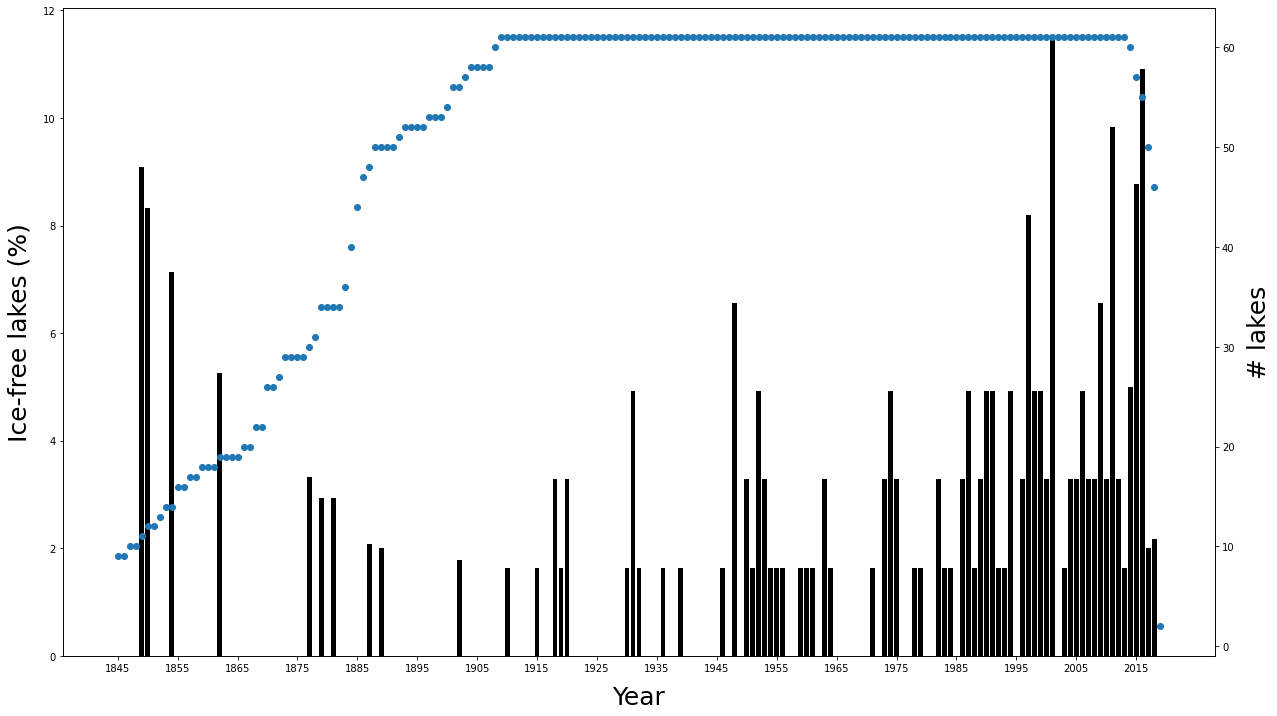

In [7]:
fig = graph.figure(figsize=(16,9))

ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax2 = ax1.twinx()

year_threshold = 1844
df_yr_subset = year_counts.loc[year_counts['start_year'] > year_threshold]

ax1.bar(df_yr_subset['start_year'], df_yr_subset['proportion'], color='black')
ax2.scatter(df_yr_subset['start_year'], df_yr_subset['number_lakes'])
ax1.set_ylabel('Ice-free lakes (%)', fontsize=25, labelpad=12)
ax2.set_ylabel('# lakes', fontsize=25, labelpad=12)
graph.xticks(np.arange(df_yr_subset['start_year'].min(), df_yr_subset['start_year'].max(), 10), fontsize=15)
ax1.set_xlabel('Year', fontsize=25, labelpad=12)
graph.tight_layout()
# graph.xlim(1845, 2020)
graph.xticks(fontsize=20)
graph.savefig('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/proportion_non_freezejuly_9_no_swiss.png', 
              bbox_inches='tight')
graph.show()


In [44]:
year_threshold=1845

df_yr_subset = year_counts.loc[year_counts['start_year'] > year_threshold]
df_yr_subset

,start_year,number_no_freeze_lakes,number_lakes,proportion
31,1846,0,9,0.000000
32,1847,0,10,0.000000
33,1848,0,10,0.000000
34,1849,1,11,9.090909
35,1850,1,12,8.333333
...,...,...,...,...
200,2015,5,56,8.928571
201,2016,6,54,11.111111
202,2017,1,49,2.040816
203,2018,1,45,2.222222


# Linear regression and Theil-sen estimator

In [317]:
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
# utils.install_packages(Strvector('trend'))

<rpy2.rinterface.NULLType object at 0x7f0f94a40280> [RTYPES.NILSXP]

In [1]:
# utils.install_packages('SiZer')

In [3]:
trend = rpackages.importr('trend')
segmented = rpackages.importr('segmented')
r_stats = rpackages.importr('stats')
sizer = rpackages.importr('SiZer')
# base = rpackages.importr('base')

In [319]:
%load_ext rpy2.ipython

In [14]:
file_path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/May_25/'
dfs = []

for file in os.listdir(file_path):
    lake = file.split('.')[0]
    df = pd.read_csv(f'{file_path}{file}')
#     df.drop(df.index[0], inplace=True)
    initial_yr = df['start_year'].min()
    final_yr = df['start_year'].max()
    yr_range = str(initial_yr) + '-' + str(final_yr)
    
    new_sens = []
    new_linear = []
    
    for var in ['ice_on_doy', 'ice_off_doy', 'duration']:
#         y = df[var].dropna(axis=0)
    
        if df[var].isna().any():
            slope_sens, p_sens = np.nan, np.nan
            new_sens.append([var, slope_sens, p_sens])
            new_linear.append([var, slope_sens, p_sens])
        else:
            r_var = robjects.IntVector(df[var])
            sens = trend.sens_slope(r_var)
            slope_sens = np.array(sens[0]).item()
            p_sens = np.array(sens[2]).item()
            new_sens.append([var, slope_sens, p_sens])
            
            slope_linear, intercept_linear, r_linear, p_linear, std_err = stats.linregress(df['start_year'], df[var])
            new_linear.append([var, slope_linear, intercept_linear, r_linear**2, p_linear])
            
#     dfs.append([lake, yr_range, new_sens])        
    dfs.append([lake, yr_range, new_sens, new_linear])

In [16]:
df = pd.DataFrame(dfs)
df.rename(columns={0: 'lake', 1: 'year_range', 2: 'sens_rem', 3: 'linear_rem'}, inplace=True)
# df.rename(columns={0: 'lake', 1: 'year_range', 2: 'sens_rem'}, inplace=True)

df[['sens_ice_on_doy_rem','sens_ice_off_doy_rem', 
    'sens_duration_rem']] = pd.DataFrame(df['sens_rem'].values.tolist(), index= df.index)

sens_ice_on_col_names = ['ice_on_sens_var_rem', 'ice_on_sens_slope', 'ice_on_sens_p']
sens_ice_off_col_names = ['ice_off_sens_var_rem', 'ice_off_sens_slope', 'ice_off_sens_p']
sens_duration_col_names = ['duration_sens_var_rem', 'duration_sens_slope', 'duration_sens_p']

df[sens_ice_on_col_names] = pd.DataFrame(df['sens_ice_on_doy_rem'].values.tolist(), index=df.index)
df[sens_ice_off_col_names] = pd.DataFrame(df['sens_ice_off_doy_rem'].values.tolist(), index=df.index)
df[sens_duration_col_names] = pd.DataFrame(df['sens_duration_rem'].values.tolist(), index=df.index)

df[['linear_ice_on_doy_rem','linear_ice_off_doy_rem', 
    'linear_duration_rem']] = pd.DataFrame(df['linear_rem'].values.tolist(), index= df.index)

linear_ice_on_col_names = ['ice_on_lin_var_rem', 'ice_on_lin_slope', 'ice_on_lin_intercept', 'ice_on_lin_r2', 'ice_on_lin_p']
linear_ice_off_col_names = ['ice_off_lin_var_rem', 'ice_off_lin_slope', 'ice_off_lin_intercept', 
                            'ice_off_lin_r2', 'ice_off_lin_p']
linear_duration_col_names = ['duration_lin_var_rem', 'duration_lin_slope', 'duration_lin_intercept', 
                             'duration_lin_r2', 'duration_lin_p']

df[linear_ice_on_col_names] = pd.DataFrame(df['linear_ice_on_doy_rem'].values.tolist(), index=df.index)
df[linear_ice_off_col_names] = pd.DataFrame(df['linear_ice_off_doy_rem'].values.tolist(), index=df.index)
df[linear_duration_col_names] = pd.DataFrame(df['linear_duration_rem'].values.tolist(), index=df.index)

df.drop(columns=[col for col in df.columns if "rem" in col], inplace=True)
display(df.head())
# df.to_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/sens_linear_69_lakes.csv', index=False)

,lake,year_range,ice_on_sens_slope,ice_on_sens_p,ice_off_sens_slope,ice_off_sens_p,duration_sens_slope,duration_sens_p,ice_on_lin_slope,ice_on_lin_intercept,ice_on_lin_r2,ice_on_lin_p,ice_off_lin_slope,ice_off_lin_intercept,ice_off_lin_r2,ice_off_lin_p,duration_lin_slope,duration_lin_intercept,duration_lin_r2,duration_lin_p
0,Aegerisee,1913-2018,0.000000,1.728903e-01,NaN,NaN,NaN,NaN,0.104784,-152.084510,0.018326,1.664824e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Auburn,1835-2018,NaN,NaN,-0.067196,8.041610e-08,NaN,NaN,NaN,NaN,NaN,NaN,-0.074722,255.539122,0.177526,2.585070e-09,NaN,NaN,NaN,NaN
2,Baikal,1868-2018,0.111111,3.469856e-08,-0.051282,1.050397e-03,-0.168675,7.761140e-09,0.110910,-203.914814,0.201657,7.322966e-09,-0.047055,215.129313,0.067181,1.310551e-03,-0.157964,419.044127,0.203716,6.012843e-09
3,Balaton,1885-2016,0.043245,2.452377e-01,0.000000,7.676663e-01,-0.047619,3.809635e-01,0.060591,-114.675710,0.010144,2.505263e-01,-0.005560,59.215069,0.000071,9.238590e-01,-0.053101,153.058695,0.004904,4.249464e-01
4,Baldeggersee,1890-2018,0.000000,2.728006e-05,NaN,NaN,NaN,NaN,0.164261,-268.206220,0.128756,2.970212e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
r_stats.AIC()

In [39]:
auburn= pd.read_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/May_25/Auburn.csv')
auburn.head()

,lakecode,lake,start_year,ice_on,ice_off,Latitude,Longitude,Country,froze,source,contributor,Updated Year,ice_on_doy,ice_off_doy,duration,Missing Year_IceON,Missing Year_IceOFF,diff_ice_on_doy,diff_ice_off_doy,diff_duration
0,GAH1,LAKE AUBURN,1835,NaN,1836-05-08,44.14,-70.25,NaN,Y,NaN,LIAG,NaN,NaN,129,NaN,Yes,No,NaN,NaN,NaN
1,GAH1,LAKE AUBURN,1836,NaN,1837-04-30,44.14,-70.25,NaN,Y,NaN,LIAG,NaN,NaN,120,NaN,Yes,No,NaN,-9.0,NaN
2,GAH1,LAKE AUBURN,1837,NaN,1838-04-27,44.14,-70.25,NaN,Y,NaN,LIAG,NaN,NaN,117,NaN,Yes,No,NaN,-3.0,NaN
3,GAH1,LAKE AUBURN,1838,NaN,1839-04-18,44.14,-70.25,NaN,Y,NaN,LIAG,NaN,NaN,108,NaN,Yes,No,NaN,-9.0,NaN
4,GAH1,LAKE AUBURN,1839,NaN,1840-04-28,44.14,-70.25,NaN,Y,NaN,LIAG,NaN,NaN,119,NaN,Yes,No,NaN,11.0,NaN


In [43]:
df = auburn.copy()
linear_model= r_stats.lm("df['ice_off_doy']~df['start_year']")

R[write to console]: Error in df["ice_off_doy"] : object of type 'closure' is not subsettable
Calls: <Anonymous> ... eval -> <Anonymous> -> model.frame.default -> eval -> eval



RRuntimeError: Error in df["ice_off_doy"] : object of type 'closure' is not subsettable
Calls: <Anonymous> ... eval -> <Anonymous> -> model.frame.default -> eval -> eval


# Difference between consecutive years

In [248]:
file_path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/April_10/'
dfs = []

for file in tqdm(os.listdir(file_path)):
    lake = file.split('.')[0]
    df = pd.read_csv(f'{file_path}{file}')
    
    df['diff_ice_on_doy'] = df['ice_on_doy'].diff()
    df['diff_ice_off_doy'] = df['ice_off_doy'].diff()
    df['diff_duration'] = df['duration'].diff()
    
#     df.to_csv(f'/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/April_22/{lake}.csv', index=False)

100%|██████████| 61/61 [00:00<00:00, 62.03it/s]


## My Questions

In [20]:
sizer = rpackages.importr('SiZer')

In [318]:
from scipy import optimize

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [ ]:
r_stats.AIC

In [106]:
# file_path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/'
file_path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_Bill_Perry_lake_files/'

dfs = []

for file in os.listdir(file_path):
    lake = file.split('_variability.csv')[0]
    print('\033[1m \033[91m \033[4m' +  lake + '\033[0m')
    
    df = pd.read_csv(f'{file_path}{file}')
#     initial_yr = df['start_year'].min()
#     final_yr = df['start_year'].max()
#     yr_range = str(initial_yr) + '-' + str(final_yr)
    
    piecewise_year = []
    
    for var in ['ice_on_doy', 'ice_off_doy', 'duration']:
    
        if df[var].isna().any():
            break_year, sizer_aic = np.nan, np.nan
            piecewise_year.append([var, break_year, sizer_aic])
            
        else:
            linear_piecewise = sizer.piecewise_linear(df['year'], df[var])
            sizer_aic = r_stats.AIC(linear_piecewise).item()
            break_year = linear_piecewise[0].item()
#             linear_model = r_stats.lm(f"{df[var]} ~ {df['start_year']}")
#             print(linear_model)
            piecewise_year.append([var, break_year, sizer_aic])

#     dfs.append([lake, yr_range, piecewise_year]) 
    dfs.append([lake, piecewise_year])

  Aegerisee
  Auburn
  Baikal
  Balaton
  Baldeggersee
  Brant
  Cazenovia
  Champlain
  Christmas
  Clear
  Cobbosseecontee
  Damariscotta
  Detroit
  Geneva
  Gouta
  Grand Traverse Bay
  Greifensee
  Hallwilersee
  Haukivesi
  Houghtons
  Kallavesi
  Kallsjon
  KempenfeltBay
  Kezar
  LakeOfBays
  Lej de San Murezzan
  Lentua
  Mendota
  Minnetonka
  MIRROR
  Monona
  Moosehead
  Mooselookmeguntic
  Murtensee
  Nackten
  Nasijarvi
  Nipissing
  Oneida
  Orsasjon
  Osakis
  Otsego
  Oulujarvi
  Paijanne
  Palovesi
  Pennesseewassee
  Pielavesi
  Pielinen
  Rangeley
  Richardson
  Runn
  Sarnersee
  Schroon
  Sebago
  Sebec
  Sempachersee
  Serwy
  Shell
  Shields
  Sunapee
  SuperiorBayfield
  Suwa
  Thompson
  Umbagog
  Untersee
  Vesijarvi
  Visuvesi
  West Grand
  Wilson
  Winnipesaukee


In [108]:
df = pd.DataFrame(dfs)
# df.rename(columns={0: 'lake', 1: 'year_range', 2: 'breaks_rem'}, inplace=True)
df.rename(columns={0: 'lake',  1: 'breaks_rem'}, inplace=True)

df[['ice_on_rem', 'ice_off_rem', 'duration_rem']] = pd.DataFrame(df['breaks_rem'].values.tolist(), index=df.index)

break_ice_on_col_names = ['ice_on_var_rem', 'sizer_ice_on_break_year', 'sizer_ice_on_aic']
break_ice_off_col_names = ['ice_off_var_rem', 'sizer_ice_off_break_year', 'sizer_ice_off_aic']
break_duration_col_names = ['duration_var_rem', 'sizer_duration_break_year', 'sizer_duration_aic']

df[break_ice_on_col_names] = pd.DataFrame(df['ice_on_rem'].values.tolist(), index=df.index)
df[break_ice_off_col_names] = pd.DataFrame(df['ice_off_rem'].values.tolist(), index=df.index)
df[break_duration_col_names] = pd.DataFrame(df['duration_rem'].values.tolist(), index=df.index)

df.drop(columns=[col for col in df.columns if "rem" in col], inplace=True)
display(df)
# df.to_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/break_years_variability_bill_perry_sizer.csv', 
#           index=False)

,lake,sizer_ice_on_break_year,sizer_ice_on_aic,sizer_ice_off_break_year,sizer_ice_off_aic,sizer_duration_break_year,sizer_duration_aic
0,Aegerisee,1970.000006,412.551323,NaN,NaN,NaN,NaN
1,Auburn,NaN,NaN,1996.000052,549.737123,NaN,NaN
2,Baikal,1960.999939,434.055777,1991.724782,436.496325,1894.536652,562.294935
3,Balaton,1935.386303,666.928062,1960.000023,613.296777,1981.000068,527.784636
4,Baldeggersee,1979.301782,602.530268,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
64,Vesijarvi,1923.891883,614.645270,1997.000030,385.763087,1923.249996,700.955543
65,Visuvesi,1988.639520,651.904903,1920.000017,389.635699,1991.000005,717.329663
66,West Grand,NaN,NaN,1989.000059,486.666905,NaN,NaN
67,Wilson,NaN,NaN,1996.734896,339.671940,NaN,NaN


  0%|          | 0/18 [00:00<?, ?it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Auburn
ice_off_doy


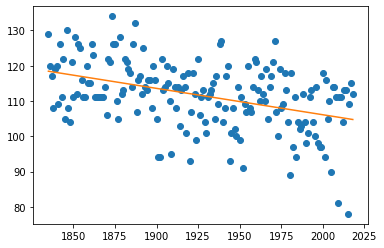

  6%|▌         | 1/18 [00:00<00:04,  3.47it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Cazenovia
ice_off_doy


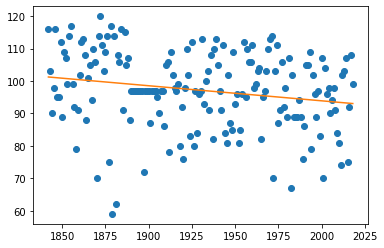

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


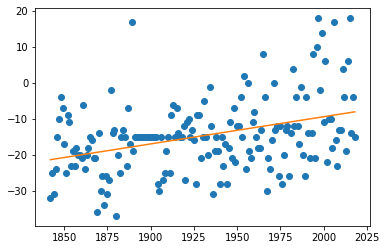

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


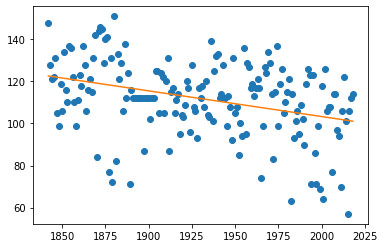

 11%|█         | 2/18 [00:01<00:07,  2.14it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Champlain
ice_on_doy


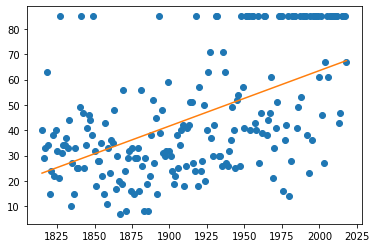

 17%|█▋        | 3/18 [00:01<00:06,  2.34it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Cobbosseecontee
ice_off_doy


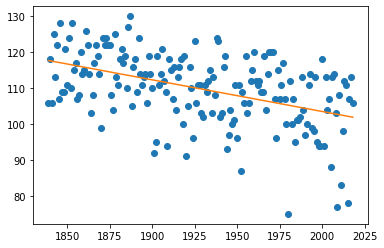

 22%|██▏       | 4/18 [00:01<00:05,  2.60it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Damariscotta
ice_off_doy


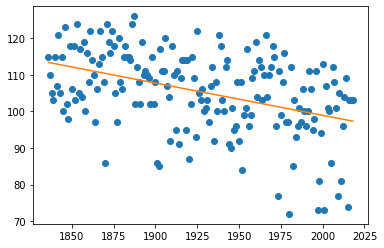

 28%|██▊       | 5/18 [00:02<00:04,  2.83it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Grand Traverse Bay
ice_off_doy


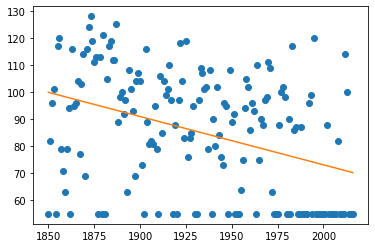

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


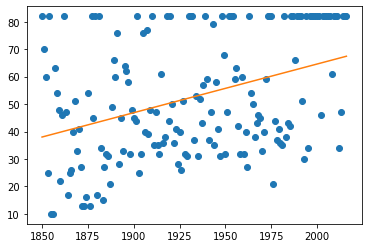

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


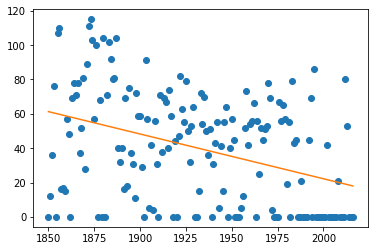

 33%|███▎      | 6/18 [00:02<00:06,  1.92it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Kallavesi
ice_off_doy


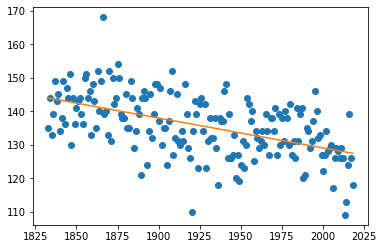

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


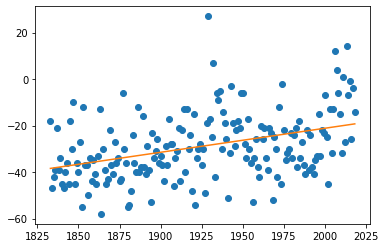

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


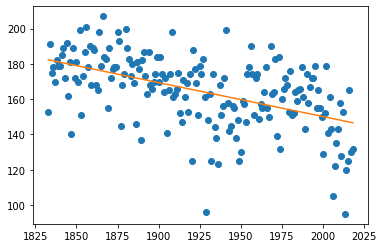

 39%|███▉      | 7/18 [00:03<00:07,  1.54it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  KempenfeltBay
ice_off_doy


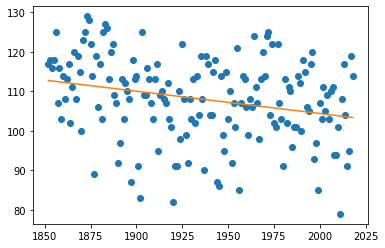

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


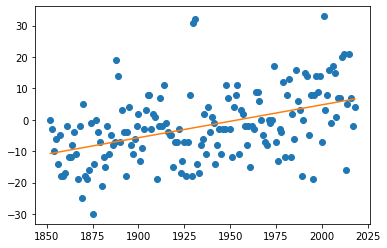

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


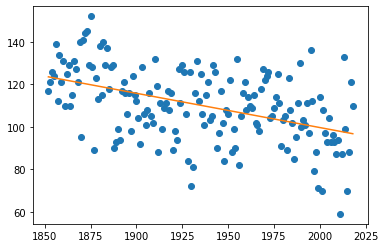

 44%|████▍     | 8/18 [00:04<00:07,  1.36it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Lej de San Murezzan
ice_off_doy


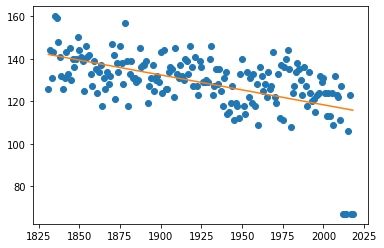

 50%|█████     | 9/18 [00:05<00:05,  1.68it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Mendota
ice_off_doy


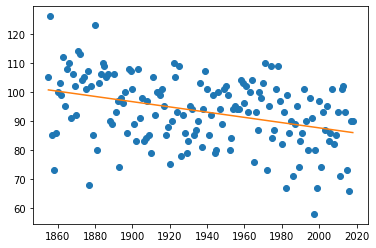

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


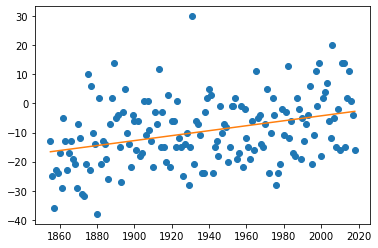

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


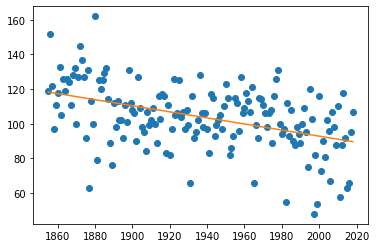

 56%|█████▌    | 10/18 [00:06<00:05,  1.47it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Monona
ice_off_doy


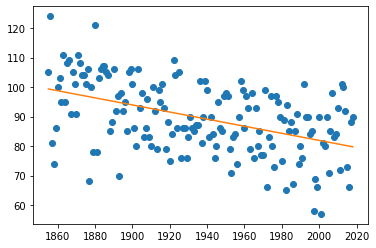

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


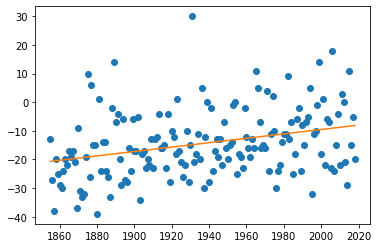

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


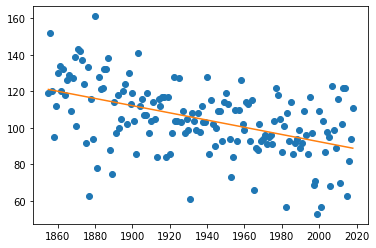

 61%|██████    | 11/18 [00:06<00:05,  1.37it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Moosehead
ice_off_doy


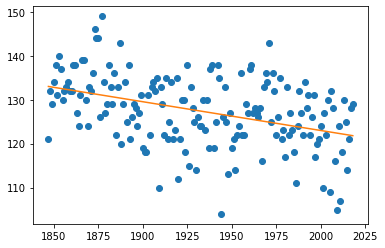

 67%|██████▋   | 12/18 [00:07<00:03,  1.68it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Nasijarvi
ice_off_doy


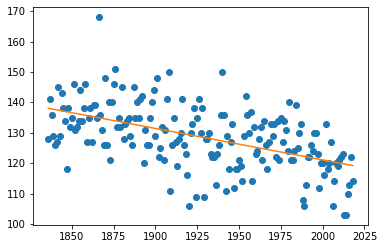

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


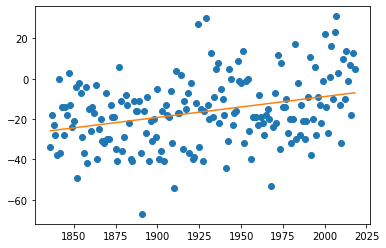

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


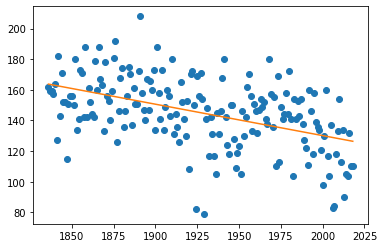

 72%|███████▏  | 13/18 [00:08<00:03,  1.42it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Oneida
ice_off_doy


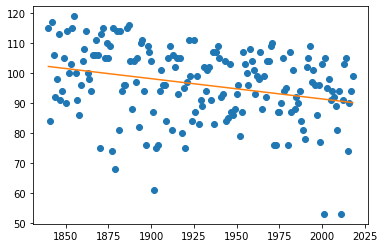

 78%|███████▊  | 14/18 [00:08<00:02,  1.72it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Otsego
ice_off_doy


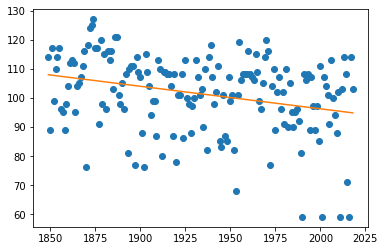

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


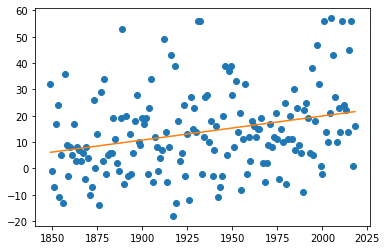

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


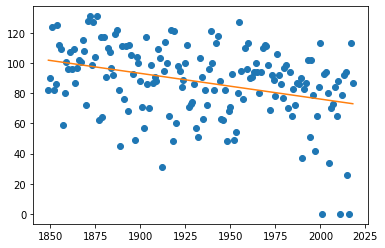

 83%|████████▎ | 15/18 [00:09<00:01,  1.51it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Oulujarvi
ice_off_doy


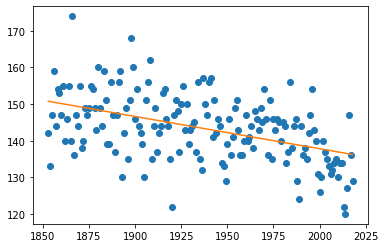

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


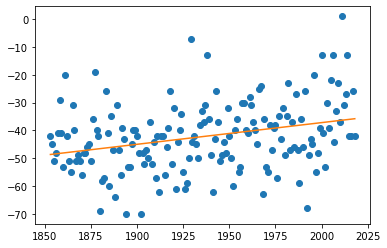

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


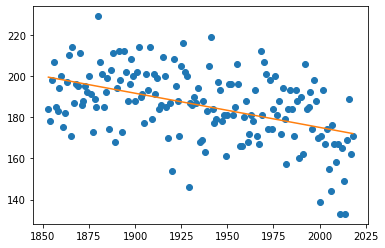

 89%|████████▉ | 16/18 [00:10<00:01,  1.41it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  Runn
ice_off_doy


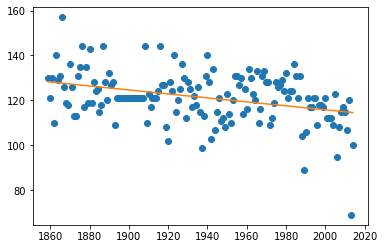

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


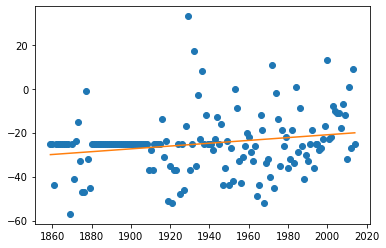

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


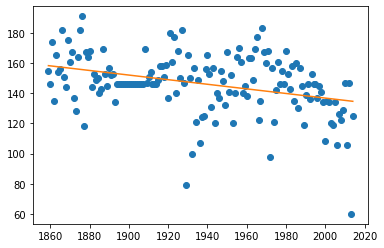

 94%|█████████▍| 17/18 [00:10<00:00,  1.32it/s]/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


  SuperiorBayfield
ice_off_doy


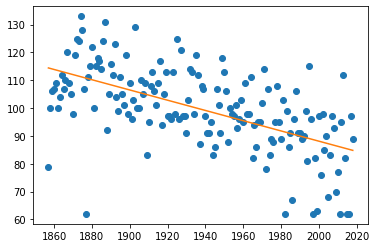

ice_on_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


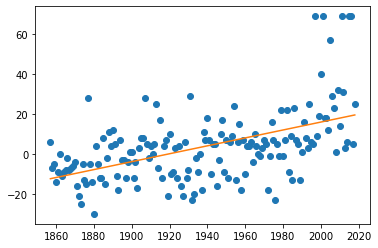

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


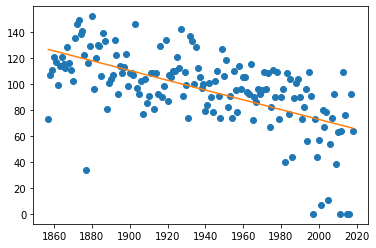

100%|██████████| 18/18 [00:11<00:00,  1.52it/s]


In [324]:
file_path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/'
dfs = []

for file in tqdm(os.listdir(file_path)):
    print('\033[1m \033[91m \033[4m' +  file.split('.')[0] + '\033[0m')
    df = pd.read_csv(f'{file_path}{file}')
    x = np.array(df['start_year'])
    
    for var in ['ice_off_doy', 'ice_on_doy', 'duration']:
        if df[var].isnull().any():
            continue
        print(var)
        y = np.array(df[var])
        p , e = optimize.curve_fit(piecewise_linear, x, y)
        xd = np.linspace(x[0], x[-1], len(x))
        graph.plot(x, y, "o")
        graph.plot(xd, piecewise_linear(xd, *p))
        graph.show()

In [38]:
year_float = robjects.FloatVector(df['start_year'])
ice_on_float = robjects.FloatVector(df['ice_on_doy'])

In [43]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from IPython.display import display, Markdown

In [52]:
model = smf.ols("ice_on_doy ~ start_year", data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ice_on_doy   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     57.68
Date:                Sun, 26 Apr 2020   Prob (F-statistic):           2.43e-12
Time:                        13:15:59   Log-Likelihood:                -673.27
No. Observations:                 162   AIC:                             1351.
Df Residuals:                     160   BIC:                             1357.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -380.5182     50.592     -7.521      0.000    -480.433    -280.603
start_year     0.1983      0.026      7.595      0.000       0.147       0.250
==============================================================================
Omnibus:                       36.825   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.147
Skew:                           1.072   Prob(JB):                     1.59e-15
Kurtosis:                       5.345   Cond. No.                     8.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Graphs

In [23]:
model = sizer.piecewise_linear(df['start_year'], df['duration'])
np.round(model[0].item())

1978.0

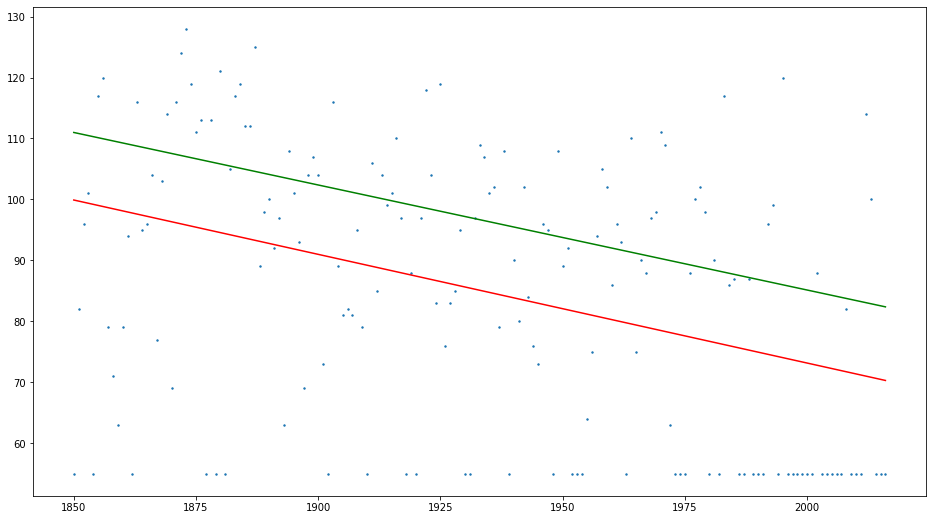

In [132]:
sens = stats.theilslopes(df['ice_off_doy'])
linear = stats.linregress(df['start_year'], df['ice_off_doy'])

graph.figure(figsize=(16,9))
graph.scatter(df['start_year'], df['ice_off_doy'], s=2)
# graph.plot(df['start_year'], sens[1] + sens[0]*df['start_year'])
graph.plot(df['start_year'], linear[1] + sens[0]*df['start_year'], color='green')
graph.plot(df['start_year'], linear[1] + linear[0]*df['start_year'], color='red')
graph.show()


# x.plot(x, res[1] + res[0] * x, 'r-')
# >>> ax.plot(x, res[1] + res[2] * x, 'r--')
# >>> ax.plot(x, res[1] + res[3] * x, 'r--')

In [85]:
file_path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/'
dfs = []

for file in os.listdir(file_path):
    df=pd.read_csv(f'{file_path}{file}')
    dfs.append(df)

hypothesis_lakes = pd.concat(dfs, sort=False)

hypo_lakes_mean = pd.DataFrame(hypothesis_lakes.groupby('start_year').mean())
hypo_lakes_mean.reset_index(level=0, inplace=True)
# hypo_lakes_mean = hypo_lakes_mean[hypo_lakes_mean['start_year'] > 1859]
hypo_lakes_mean.drop(columns=['Latitude', 'Longitude', 'Updated Year', 'diff_ice_on_doy', 'diff_ice_off_doy', 'diff_duration'], 
                     inplace=True)
# hypo_lakes_mean.to_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/merged_18_lakes_climate_mean.csv', index=False)
# hypothesis_lakes.to_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/merged_18_lakes_climate_all.csv', index=False)

In [83]:
hypothesis_df_for_R = hypothesis_lakes[['ice_on_doy', 'ice_off_doy', 'duration', 'PDO mean A-DEC' ,'QBO mean A-DEC', 
                                       'SOI mean A-DEC', 
                                       'NINO3 mean A-DEC', 'AO mean A-DEC', 'AMO mean A-DEC', 'NAO DJFM', 'tmp_DJF', 
                                       'tmp_MAM', 'tmp_lagSON', 'global_merged_co2_annual (ppm)', 'ENSO paleo A-DEC', 
                                       'Daily Total Sunspot Number mean A-DEC', 'NH', 'SH']]
hypothesis_df_for_R.rename(columns={'ice_on_doy': 'Ice_on', 
                                    'ice_off_doy': 'Ice_off', 
                                    'duration': 'Duration', 
                                    'PDO mean A-DEC': 'PDO',
                                    'QBO mean A-DEC': 'QBO', 
                                    'SOI mean A-DEC': 'SOI', 
                                    'NINO3 mean A-DEC': 'NINO3', 
                                    'AO mean A-DEC': 'AO', 
                                    'AMO mean A-DEC': 'AMO', 
                                    'NAO DJFM': 'NAO', 
                                    'tmp_DJF': 'Winter_temp', 
                                    'tmp_MAM': 'Spring_temp', 
                                    'tmp_lagSON': 'Fall_temp', 
                                    'global_merged_co2_annual (ppm)': 'CO2', 
                                    'ENSO paleo A-DEC': 'ENSO', 
                                    'Daily Total Sunspot Number mean A-DEC': 'Sunspot', 
                                    'NH': 'NH', 
                                    'SH': 'SH'}, inplace=True)
hypothesis_df_for_R.head()
hypothesis_df_for_R.to_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/merged_18_lakes_climate_all_for_R.csv', index=False)

/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [86]:
for col in ['ice_on_doy', 'ice_off_doy', 'duration', 'PDO mean A-DEC' ,'QBO mean A-DEC', 
                                       'SOI mean A-DEC', 
                                       'NINO3 mean A-DEC', 'AO mean A-DEC', 'AMO mean A-DEC', 'NAO DJFM', 'tmp_DJF', 
                                       'tmp_MAM', 'tmp_lagSON', 'global_merged_co2_annual (ppm)', 'ENSO paleo A-DEC', 
                                       'Daily Total Sunspot Number mean A-DEC', 'NH', 'SH']:
    df_temp = hypo_lakes_mean[['start_year', col]].dropna()
    print(col, df_temp['start_year'].min(), df_temp['start_year'].max())

ice_on_doy 1815 2018
ice_off_doy 1831 2018
duration 1827 2018
PDO mean A-DEC 1900 2017
QBO mean A-DEC 1948 2018
SOI mean A-DEC 1874 2018
NINO3 mean A-DEC 1870 2018
AO mean A-DEC 1950 2018
AMO mean A-DEC 1856 2018
NAO DJFM 1864 2018
tmp_DJF 1901 2018
tmp_MAM 1901 2018
tmp_lagSON 1901 2018
global_merged_co2_annual (ppm) 1815 2018
ENSO paleo A-DEC 1815 2002
Daily Total Sunspot Number mean A-DEC 1818 2018
NH 1815 2000
SH 1815 2000


In [75]:
hypo_lakes_mean.head()

,start_year,ice_on_doy,ice_off_doy,duration,tmp_lagJJA,tmp_lagSON,tmp_DJF,tmp_MAM,pre_lagJJA,pre_lagSON,...,SH,Global,Daily Total Sunspot Number mean A-DEC,Daily Total Sunspot Number mean A-MAR,Daily Total Sunspot Number mean A-APR,Daily Total Sunspot Number mean JFM,Daily Total Sunspot Number mean lagSON,Daily Total Sunspot Number mean DJF,Daily Total Sunspot Number mean MAM,global_merged_co2_annual (ppm)
45,1860,-15.833333,115.647059,133.818182,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,182.183060,179.609290,177.379781,170.901099,201.274725,159.307692,176.141304,286.386
46,1861,-9.333333,120.647059,132.363636,NaN,NaN,NaN,NaN,NaN,NaN,...,4.23,4.23,146.575342,177.761644,181.986301,152.844444,177.384615,149.288889,162.032609,286.259
47,1862,-4.000000,114.411765,119.181818,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,112.087671,135.484931,128.501370,107.866667,127.186813,132.033333,102.402174,286.163
48,1863,-5.833333,120.941176,134.181818,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,83.545205,112.246575,110.191781,108.511111,100.516484,91.844444,102.010870,286.108
49,1864,-18.000000,111.529412,134.545455,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,89.229508,83.680328,82.942623,108.780220,63.164835,92.494505,90.619565,286.105


In [437]:
rol_20 = hypo_lakes_mean.rolling(window=20).mean()

In [438]:
rol_20

,start_year,ice_on_doy,ice_off_doy,duration
45,NaN,NaN,NaN,NaN
46,NaN,NaN,NaN,NaN
47,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN
49,NaN,NaN,NaN,NaN
...,...,...,...,...
199,2004.5,9.100962,102.023529,93.125641
200,2005.5,10.943269,100.689890,89.663141
201,2006.5,11.100962,100.050735,89.035868
202,2007.5,10.562500,100.706618,90.227826


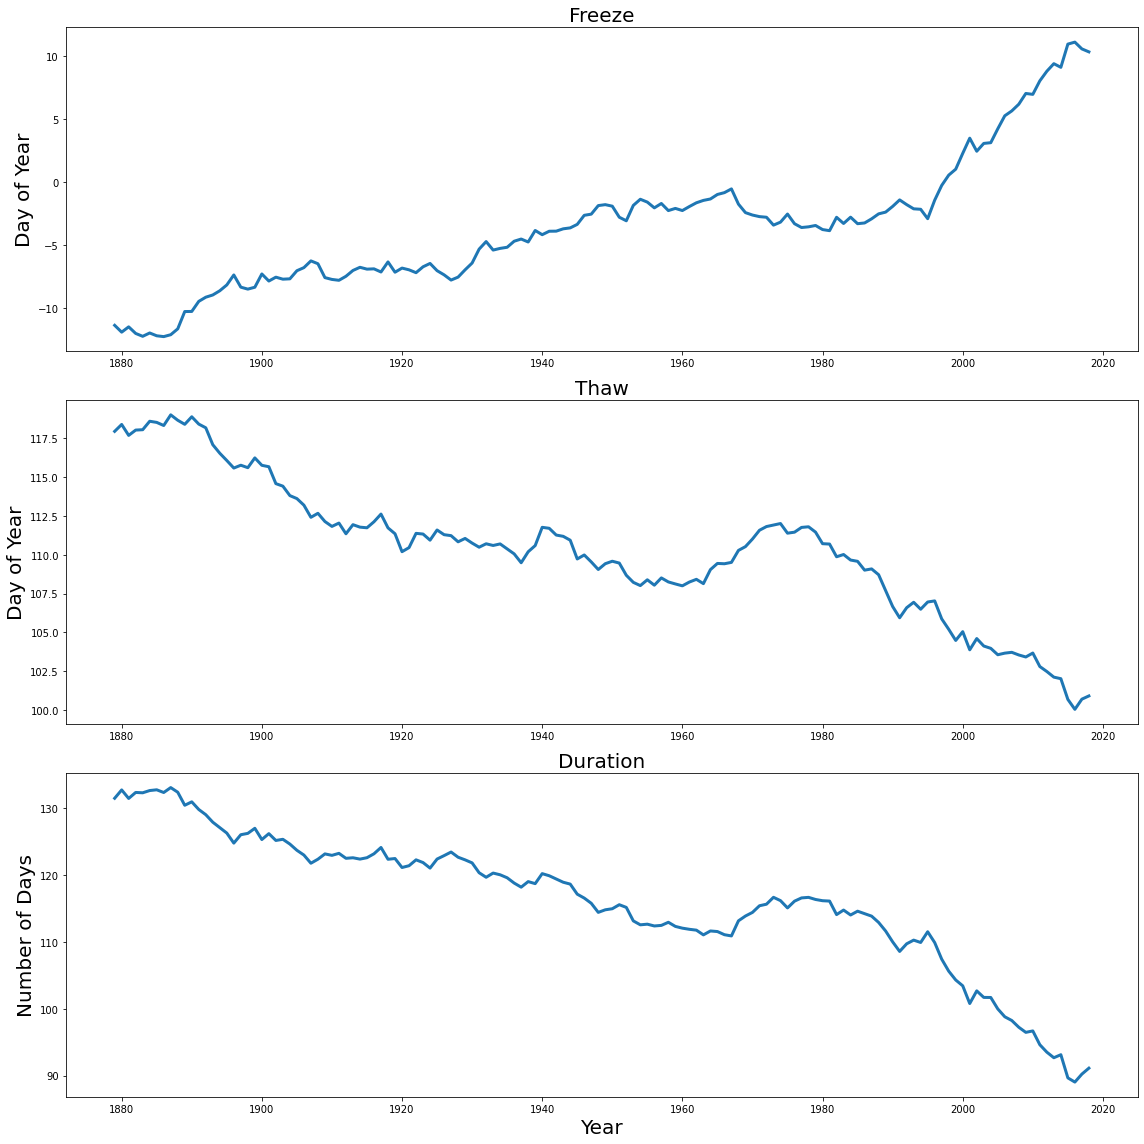

In [439]:
title_size = 20
linewidth = 3
axis_label_size = 20

f, (ax1, ax2, ax3) = graph.subplots(3,1 , figsize=(16, 16))
ax1.plot(hypo_lakes_mean['start_year'], rol_20['ice_on_doy'], linewidth=linewidth)
ax2.plot(hypo_lakes_mean['start_year'], rol_20['ice_off_doy'], linewidth=linewidth)
ax3.plot(hypo_lakes_mean['start_year'], rol_20['duration'], linewidth=linewidth)

ax1.set_title('Freeze', size=title_size)
ax2.set_title('Thaw', size=title_size)
ax3.set_title('Duration', size=title_size)

graph.xlabel('Year', fontsize=axis_label_size)
ax1.set_ylabel('Day of Year', fontsize=axis_label_size)
ax2.set_ylabel('Day of Year', fontsize=axis_label_size)
ax3.set_ylabel('Number of Days', fontsize=axis_label_size)

graph.tight_layout()
graph.show()
f.savefig('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/rolling_averages.png')

### Break Years

In [113]:
from scipy.stats import sem, t

def confidence_years(data, confidence):
    mean = data.mean()
    upper_value = 0.5 + (confidence/2)
    lower_value = 0.5 - (confidence/2)
    upper_confidence, lower_confidence = data.quantile(upper_value), data.quantile(lower_value)
    return mean, upper_confidence, lower_confidence

In [95]:
years_break = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/break_years.csv')
display(years_break.head())

,lake,year_range,ice_on_break_year,ice_off_break_year,duration_break_year
0,Auburn,1835-2018,NaN,1873.000064,NaN
1,Cazenovia,1842-2018,1976.000008,1897.000035,1969.999987
2,Champlain,1815-2018,1876.000022,NaN,NaN
3,Cobbosseecontee,1839-2018,NaN,1969.000037,NaN
4,Damariscotta,1836-2018,NaN,1966.000021,NaN


In [116]:
ice_on_break = confidence_years(years_break['ice_on_break_year'], confidence=0.95)
ice_off_break = confidence_years(years_break['ice_off_break_year'], confidence=0.95)
duration_break = confidence_years(years_break['duration_break_year'], confidence=0.95)
print(ice_on_break, ice_off_break, duration_break)

(1931.4535245768802, 1989.914533577386, 1864.3359625819007) (1941.5732270993553, 2002.6000275292804, 1871.999984553408) (1936.5388841625502, 1992.9751222604411, 1860.9704047714363)


In [67]:
print(f"Ice ON: {df['ice_on_break_year'].mean(), df['ice_on_break_year'].median()}")  
print(f"Ice OFF: {df['ice_off_break_year'].mean(), df['ice_off_break_year'].median()}")
print(f"Duration: {df['duration_break_year'].mean(), df['duration_break_year'].median()}")

Ice ON: (1931.4535245768802, 1935.0000266149232)
Ice OFF: (1941.5732270993553, 1966.0000214909255)
Duration: (1936.5388841625502, 1969.9999872921853)


In [175]:
years_break.fillna(years_break.mean(), inplace=True)
df1 = years_break.T

new_header = df1.iloc[0] #grab the first row for the header
df1 = df1[2:] #take the data less the header row
df1.columns = new_header #set the header row as the df header
df1

lake,Auburn,Cazenovia,Champlain,Cobbosseecontee,Damariscotta,Grand Traverse Bay,Kallavesi,KempenfeltBay,Lej de San Murezzan,Mendota,Monona,Moosehead,Nasijarvi,Oneida,Otsego,Oulujarvi,Runn,SuperiorBayfield
ice_on_break_year,1931.45,1976,1876,1931.45,1931.45,1978.37,1859.91,1977,1931.45,1888,1877,1931.45,1891,1931.45,1988,1894,1990.64,1981.52
ice_off_break_year,1873,1897,1941.57,1969,1966,1872,1996,1920,2007,1971,1929,1902,1995.57,1903,1970,1980.17,1984,1872
duration_break_year,1936.54,1970,1936.54,1936.54,1936.54,1978,1856.29,1901,1936.54,1891,1890.75,1936.54,1875,1936.54,1977.99,1992.9,1993,1976


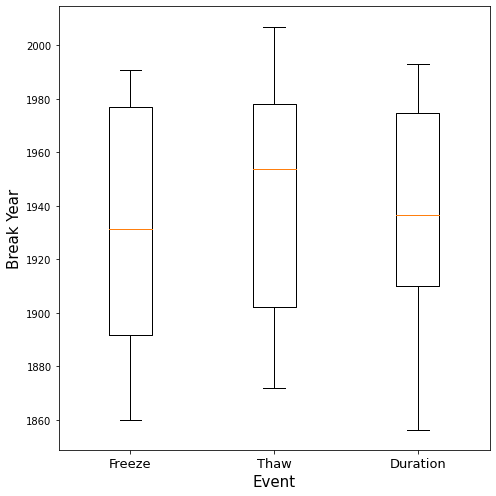

In [200]:
graph.figure(figsize=(7,7))
graph.boxplot(df1)
graph.ylabel('Break Year', fontsize=axis_label_size-5)
graph.xticks([1, 2, 3], ['Freeze', 'Thaw', 'Duration'], fontsize=13)
# graph.yticks(fontsize=15)
graph.xlabel('Event', fontsize=axis_label_size-5)
graph.tight_layout()
graph.savefig('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/break_years_boxplot.png')
graph.show()

In [67]:
freeze_break_years = [1876, 1855, 1994]
thaw_break_years = [1872, 2007, 1983, 1984, 1871]
duration_break_years = [1856, 1986, 1992, 1993, 1976]

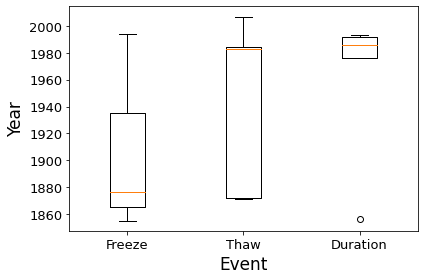

In [77]:
graph.boxplot([freeze_break_years, thaw_break_years, duration_break_years])
graph.xticks([1, 2, 3], ['Freeze', 'Thaw', 'Duration'], fontsize=13)
graph.yticks(fontsize=13)
graph.xlabel('Event', fontsize=17)
graph.ylabel('Year', fontsize=17)
graph.tight_layout()
graph.savefig('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/break_years_boxplot_significant_models.png')
graph.show()

In [139]:
# linear_sens = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/sens_linear.csv')
linear_sens = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/full_data_linear_sens_trend_mar_18_2021.csv')
# linear_sens = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/hypothesis_linear_sens_slopes.csv')

# linear_sens.fillna(linear_sens.mean(), inplace=True)
# df1 = linear_sens[[col for col in linear_sens if 'slope' in col]].T
# df1 = linear_sens.T
# display(df1)
# for col in linear_sens.columns:
#     linear_sens[col] = 100 * linear_sens[col]
display(linear_sens.head())

,ice_on_sens,ice_on_linear,ice_off_sens,ice_off_linear,duration_sens,duration_linear
0,0.111111,0.114409,-0.069930,-0.077505,-0.159091,-0.153475
1,0.046512,0.062467,-0.044248,-0.039066,-0.011237,-0.029465
2,0.155738,0.198324,0.000000,-0.007884,-0.324324,-0.377637
3,0.057623,0.076520,-0.179487,-0.183860,-0.099168,-0.120477
4,0.232558,0.256029,-0.043478,-0.048130,-0.062500,-0.079941


{'whiskers': [<matplotlib.lines.Line2D at 0x7f73ea2797d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f73e9ea72d0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7f73e9ea3e10>,
 'medians': [<matplotlib.lines.Line2D at 0x7f73e9eab7d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f73e9eab2d0>,
 'means': []}

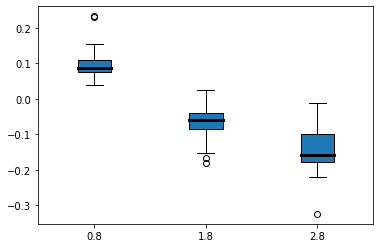

In [146]:
graph.boxplot([linear_sens['ice_on_sens'].dropna(), linear_sens['ice_off_sens'].dropna(), linear_sens['duration_sens'].dropna()], 
              positions=[0.8, 1.8, 2.8], patch_artist=True, medianprops=medianprops_linear)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f73e9aaa8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f73e9ab3390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f73e9aaa3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f73e9ab3e10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f73e9abb390>],
 'means': []}

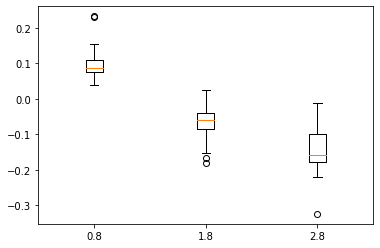

In [144]:
graph.boxplot(linear_sens['ice_on_sens'].dropna(), positions=[0.8])
graph.boxplot(linear_sens['ice_off_sens'].dropna(), positions=[1.8])
graph.boxplot(linear_sens['duration_sens'].dropna(), positions=[2.8])

In [125]:
sens_df = df1.iloc[[0, 2, 4]]
linear_df = df1.iloc[[1, 3, 5]]
display(sens_df, linear_df)

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
ice_on_sens,0.111111,0.046512,0.155738,0.057623,0.232558,0.052632,0.133333,0.073462,0.147541,0.076923,...,0.098986,0.098986,0.098986,0.098986,0.098986,0.098986,0.098986,0.098986,0.098986,0.098986
ice_off_sens,-0.069930,-0.044248,0.000000,-0.179487,-0.043478,-0.046512,-0.045199,0.000000,-0.083333,-0.081081,...,0.000000,-0.043478,0.025316,-0.095745,-0.035088,-0.101695,-0.096774,-0.067797,-0.037500,-0.040956
duration_sens,-0.159091,-0.011237,-0.324324,-0.099168,-0.062500,-0.177317,-0.125000,-0.220339,-0.160920,-0.184049,...,-0.148033,-0.148033,-0.148033,-0.148033,-0.148033,-0.148033,-0.148033,-0.148033,-0.148033,-0.148033


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
ice_on_linear,0.114409,0.062467,0.198324,0.076520,0.256029,0.071364,0.155670,0.074917,0.168278,0.076475,...,0.111733,0.111733,0.111733,0.111733,0.111733,0.111733,0.111733,0.111733,0.111733,0.111733
ice_off_linear,-0.077505,-0.039066,-0.007884,-0.183860,-0.048130,-0.046699,-0.048345,-0.005975,-0.090989,-0.090164,...,-0.061088,-0.040330,0.031616,-0.095695,-0.046578,-0.099288,-0.091425,-0.075215,-0.048359,-0.054509
duration_linear,-0.153475,-0.029465,-0.377637,-0.120477,-0.079941,-0.216567,-0.132472,-0.246315,-0.165623,-0.192697,...,-0.169532,-0.169532,-0.169532,-0.169532,-0.169532,-0.169532,-0.169532,-0.169532,-0.169532,-0.169532


In [126]:
sens_boxprops = dict(linewidth=1, color='red', fill='green')
linear_boxprops = dict(linewidth=1, color='blue')

medianprops_linear = dict(linewidth=3, color='black')
medianprops_sens = dict(linewidth=3, color='white')

In [127]:
linear_slopes = [linear_sens['ice_on_linear'].dropna(), linear_sens['ice_off_linear'].dropna(), 
                 linear_sens['duration_linear'].dropna()]
sens_slopes = [linear_sens['ice_on_sens'].dropna(), linear_sens['ice_off_sens'].dropna(), 
                 linear_sens['duration_sens'].dropna()]

# linear_slopes = [linear_sens['ice_on_lin_slope'].dropna(), linear_sens['ice_off_lin_slope'].dropna(), 
#                  linear_sens['duration_lin_slope'].dropna()]
# sens_slopes = [linear_sens['ice_on_sens_slope'].dropna(), linear_sens['ice_off_sens_slope'].dropna(), 
#                  linear_sens['duration_sens_slope'].dropna()]

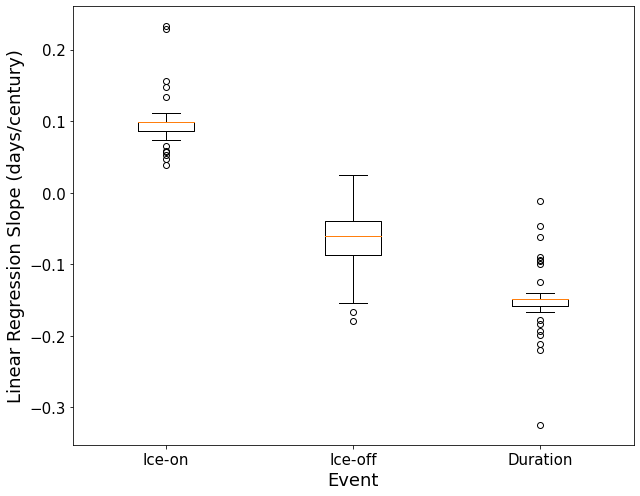

In [128]:
graph.figure(figsize=(9,7))
# graph.boxplot(df1)
b_ols = graph.boxplot(sens_slopes)
graph.ylabel('Linear Regression Slope (days/century)', fontsize=18)

graph.xticks([1, 2, 3], ['Ice-on', 'Ice-off', 'Duration'], fontsize=15)
graph.yticks(fontsize=15)
graph.xlabel('Event', fontsize=18)
graph.tight_layout()
# graph.savefig('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/full_data_linear_slope_boxplot_mar_17_2021.png')
graph.show()

No handles with labels found to put in legend.


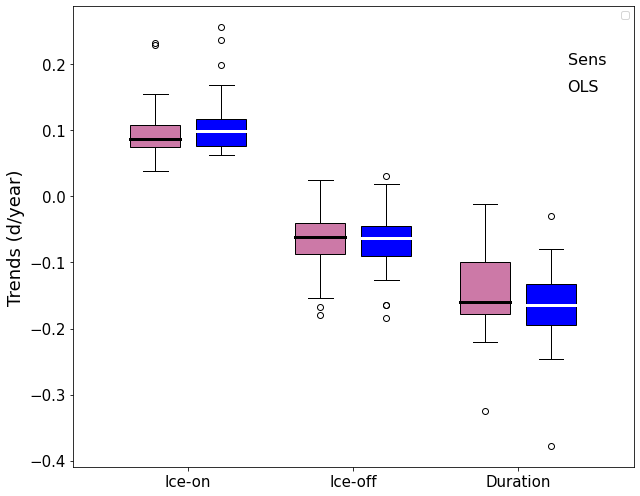

In [153]:
graph.figure(figsize=(9,7))
# graph.boxplot(df1)
b_sens = graph.boxplot([linear_sens['ice_on_sens'].dropna(), linear_sens['ice_off_sens'].dropna(), 
                        linear_sens['duration_sens'].dropna()], positions=[0.8, 1.8, 2.8], patch_artist=True, 
                       medianprops=medianprops_linear)
b_ols = graph.boxplot([linear_sens['ice_on_linear'].dropna(), linear_sens['ice_off_linear'].dropna(), 
                       linear_sens['duration_linear'].dropna()], positions=[1.2, 2.2, 3.2], patch_artist=True, 
                      medianprops=medianprops_sens)
graph.ylabel('Trends (d/year)', fontsize=18)

# for box in b0['boxes']:
#     box.set(facecolor = '#009E73', linewidth=1)
for box in b_sens['boxes']:
    box.set(facecolor = '#CC79A7', linewidth=1) 
for box in b_ols['boxes']:
    box.set(facecolor = 'blue', linewidth=1) 
    
graph.xticks([1, 2, 3], ['Ice-on', 'Ice-off', 'Duration'], fontsize=15)
graph.yticks(fontsize=15)
# graph.xlabel('Event', fontsize=18)
graph.tight_layout()
graph.text(3.3, 0.2, 'Sens', size=16)
graph.text(3.3, 0.16, 'OLS', size=16)
# graph.savefig('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/trends_paper_sens_linear_slope_boxplot_mar_18_2021.png')
graph.show()

In [152]:
# Importing Image and ImageOps module from PIL package
from PIL import Image, ImageOps

# creating an og_image object
og_image = Image.open('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/trends_paper_sens_linear_slope_boxplot_mar_18_2021.png')

# # applying grayscale method
gray_image = ImageOps.grayscale(og_image)
gray_image.save('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/trends_paper_sens_linear_slope_boxplot_mar_18_2021_black_white.png')

### "Kevin's plots"

In [312]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(grand_traverse['ice_on_doy'], add_constant(grand_traverse['start_year'])).fit()
print(regr.aic)
print(regr.rsquared_adj)
print(regr.summary())

1485.0720828022465
0.14416956618047216
                            OLS Regression Results                            
Dep. Variable:             ice_on_doy   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     28.96
Date:                Wed, 06 May 2020   Prob (F-statistic):           2.50e-07
Time:                        12:41:31   Log-Likelihood:                -740.54
No. Observations:                 167   AIC:                             1485.
Df Residuals:                     165   BIC:                             1491.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -

In [14]:
champlain = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Champlain.csv')
grand_traverse = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Grand Traverse Bay.csv')
superior = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/SuperiorBayfield.csv')
monona = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Monona.csv')
cazenovia = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Cazenovia.csv')

oulujarvi = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Oulujarvi.csv')
moosehead = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Moosehead.csv')
kempenfelt = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/KempenfeltBay.csv')
runn = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Runn.csv')
otsego = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Otsego.csv')
lej_de_san = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lej de San Murezzan.csv')

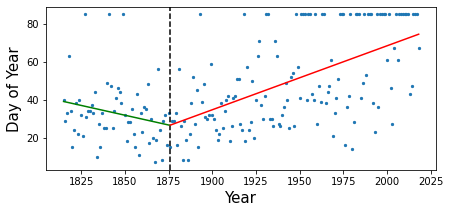

In [15]:
n = 1
break_year = 1876

pre_break_df = champlain[champlain['start_year'] <= break_year]
post_break_df = champlain[champlain['start_year'] >= break_year]
pre_linear = scipy_stats.linregress(pre_break_df['start_year'], pre_break_df['ice_on_doy'])
post_linear = scipy_stats.linregress(post_break_df['start_year'], post_break_df['ice_on_doy'])

graph.figure(figsize=(7, 3))
graph.scatter(champlain['start_year'][::n], champlain['ice_on_doy'][::n], s=5)
graph.axvline(break_year, color='black', linestyle='--')
graph.plot(pre_break_df['start_year'], pre_linear[1] + pre_linear[0]*pre_break_df['start_year'], color='green')
graph.plot(post_break_df['start_year'], post_linear[1] + post_linear[0]*post_break_df['start_year'], color='red')
graph.ylabel('Day of Year', fontsize=15)
graph.xlabel('Year', fontsize=15)
# graph.xlim(pre_break_df['start_year'].min(), post_break_df['start_year'].max()+10)
graph.show()

In [16]:
def plot_break_graphs(name, data, ice_on_break_year, ice_off_break_year, duration_break_year):
    print(name)
    n = 1
    ice_on_break, ice_off_break, duration_break = ice_on_break_year, ice_off_break_year, duration_break_year

    f, (ax1, ax2, ax3) = graph.subplots(3,1 , figsize=(12, 16))

    pre_break_df = data[data['start_year'] <= ice_on_break]
    post_break_df = data[data['start_year'] >= ice_on_break]
    pre_linear = scipy_stats.linregress(pre_break_df['start_year'], pre_break_df['ice_on_doy'])
    post_linear = scipy_stats.linregress(post_break_df['start_year'], post_break_df['ice_on_doy'])

    ax1.set_title('Freeze')
    ax1.scatter(data['start_year'][::n], data['ice_on_doy'][::n], s=5)
    ax1.axvline(ice_on_break, color='black', linestyle='--')
    ax1.plot(pre_break_df['start_year'], pre_linear[1] + pre_linear[0]*pre_break_df['start_year'], color='green')
    ax1.plot(post_break_df['start_year'], post_linear[1] + post_linear[0]*post_break_df['start_year'], color='red')
    ax1.set_ylabel('Day of Year', fontsize=15)
    f.suptitle(name, fontsize=20)

    pre_break_df = data[data['start_year'] <= ice_off_break]
    post_break_df = data[data['start_year'] >= ice_off_break]
    pre_linear = scipy_stats.linregress(pre_break_df['start_year'], pre_break_df['ice_off_doy'])
    post_linear = scipy_stats.linregress(post_break_df['start_year'], post_break_df['ice_off_doy'])

    ax2.set_title('Thaw')
    ax2.scatter(data['start_year'][::n], data['ice_off_doy'][::n], s=5)
    ax2.axvline(ice_off_break, color='black', linestyle='--')
    ax2.plot(pre_break_df['start_year'], pre_linear[1] + pre_linear[0]*pre_break_df['start_year'], color='green')
    ax2.plot(post_break_df['start_year'], post_linear[1] + post_linear[0]*post_break_df['start_year'], color='red')
    ax2.set_ylabel('Day of Year', fontsize=15)
    graph.xlabel('Year', fontsize=15)

    pre_break_df = data[data['start_year'] <= duration_break]
    post_break_df = data[data['start_year'] >= duration_break]
    pre_linear = scipy_stats.linregress(pre_break_df['start_year'], pre_break_df['duration'])
    post_linear = scipy_stats.linregress(post_break_df['start_year'], post_break_df['duration'])

    ax3.set_title('Duration')
    ax3.scatter(data['start_year'][::n], data['duration'][::n], s=5)
    ax3.axvline(duration_break, color='black', linestyle='--')
    ax3.plot(pre_break_df['start_year'], pre_linear[1] + pre_linear[0]*pre_break_df['start_year'], color='green')
    ax3.plot(post_break_df['start_year'], post_linear[1] + post_linear[0]*post_break_df['start_year'], color='red')
    ax3.set_ylabel('Days', fontsize=15)

    graph.tight_layout()
    f.subplots_adjust(top=0.93)
    graph.xlabel('Year', fontsize=15)
    graph.savefig(f"/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/{name}.png")
    graph.show()

Grand Traverse Bay


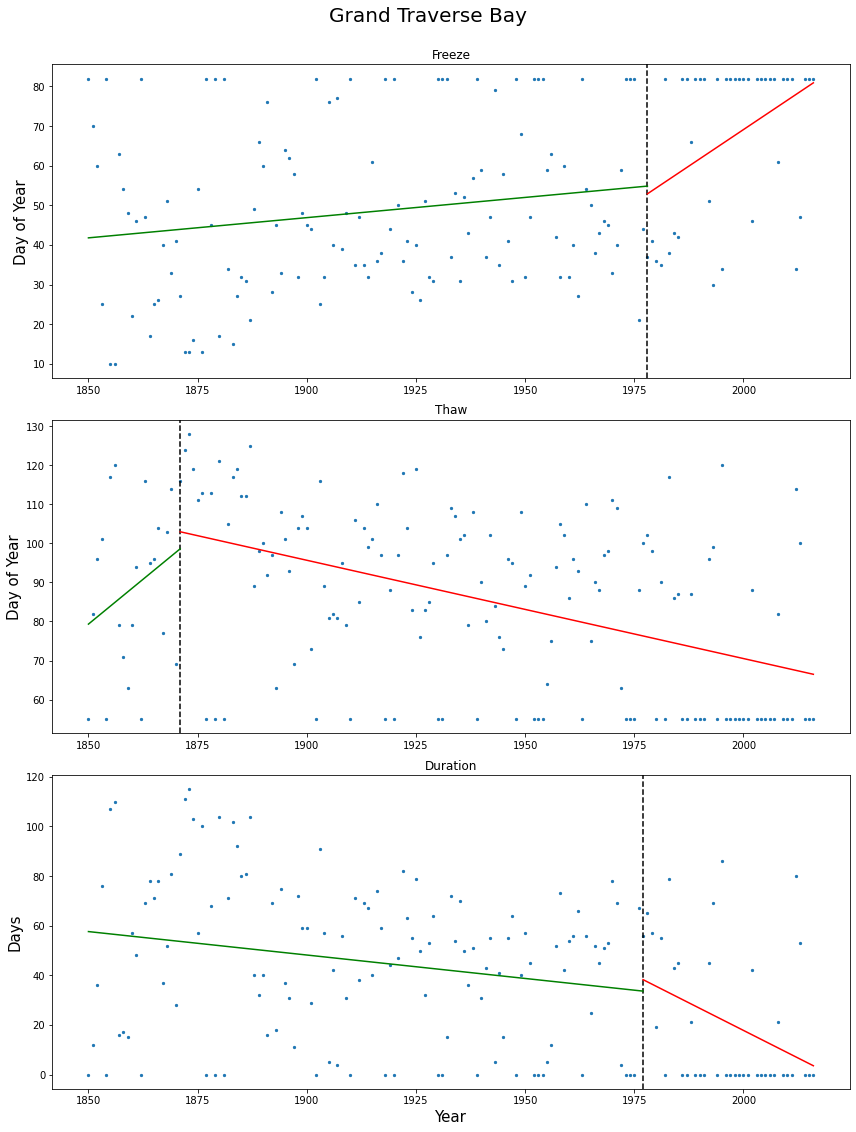

In [296]:
plot_break_graphs('Grand Traverse Bay', data=grand_traverse, 
                  ice_on_break_year=1978, 
                  ice_off_break_year=1871, duration_break_year=1977)

# Grand Traverse Bay	1850-2016	1978.372893	1871.99998	1977.999983

Lake Superior


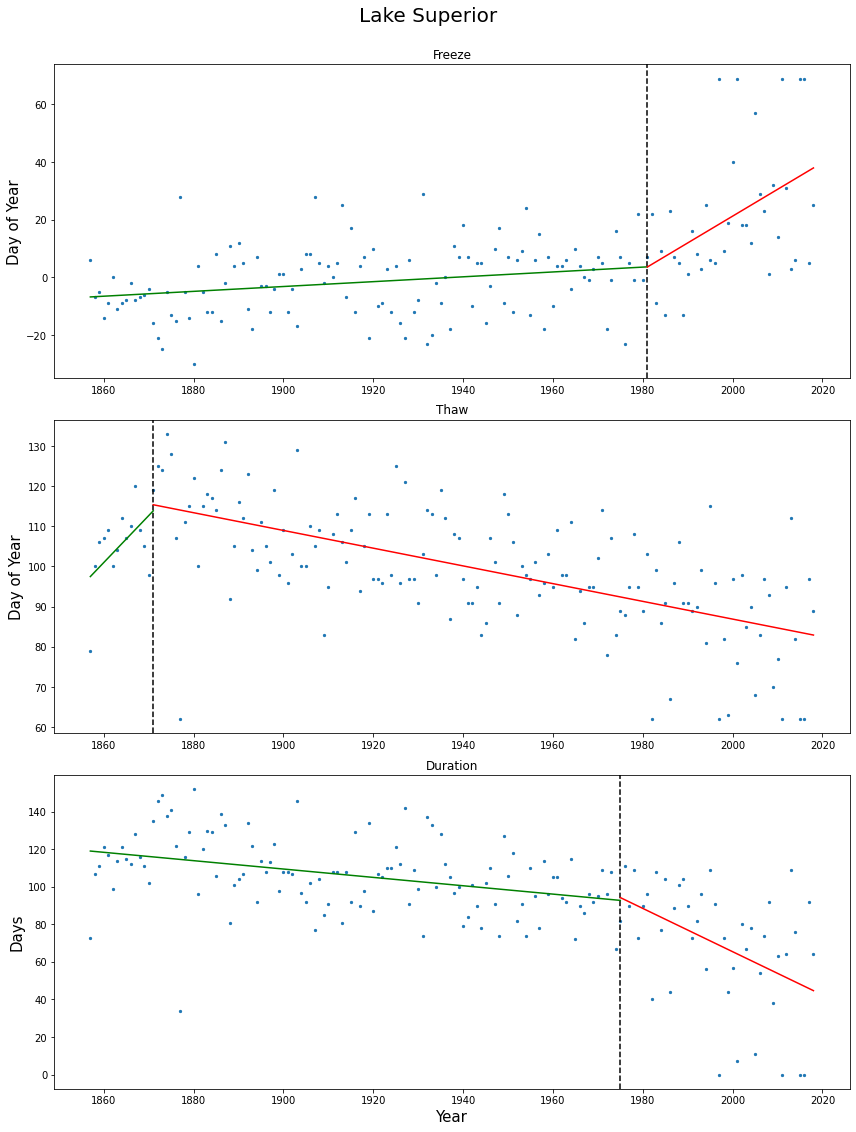

In [292]:
plot_break_graphs('Lake Superior', data=superior, 
                  ice_on_break_year=1981, 
                  ice_off_break_year=1871, duration_break_year=1975)

Monona


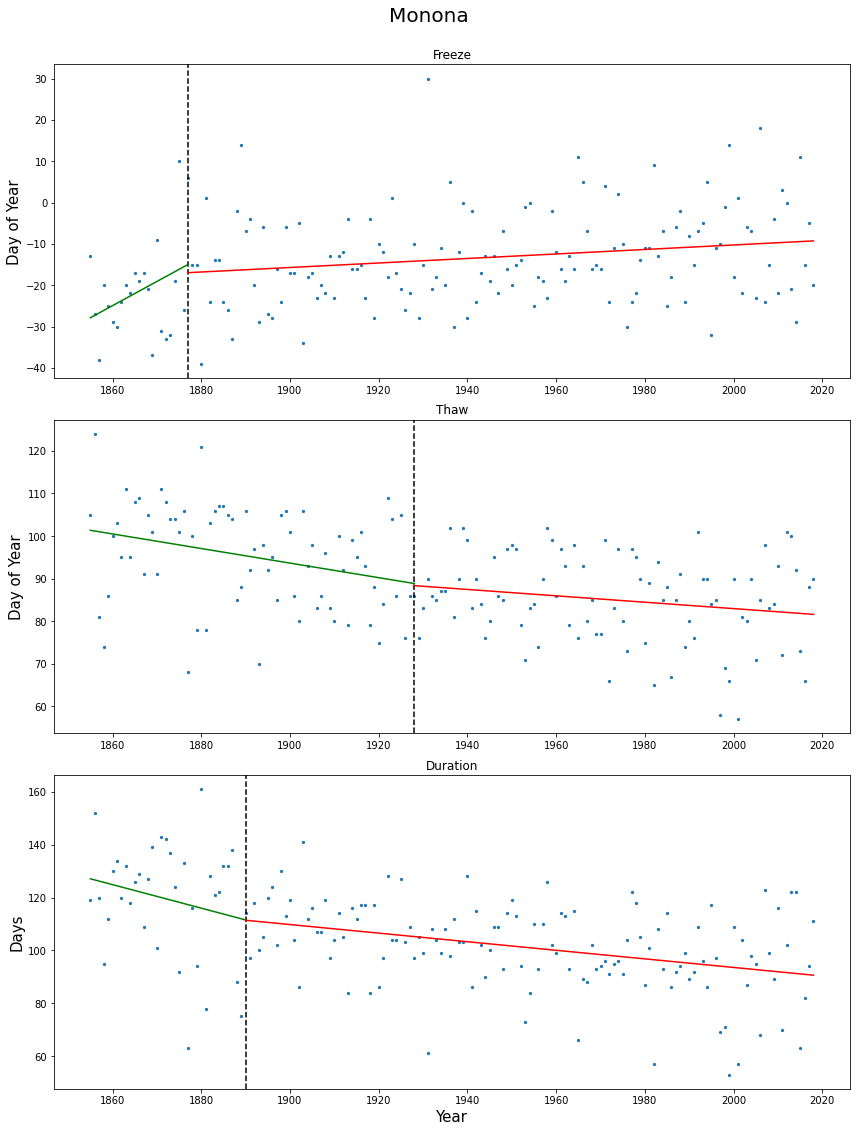

In [297]:
plot_break_graphs('Monona', data=monona, 
                  ice_on_break_year=1877, 
                  ice_off_break_year=1928, duration_break_year=1890)

In [3]:
# n = 10

# for n in range(1, 12):
#     graph.figure(figsize=(12,5))
#     graph.title(n, fontsize=20)
#     graph.scatter(superior['start_year'][::n], superior['duration'][::n])
#     graph.plot(superior['start_year'][::n], superior['duration'][::n], linewidth=0.5)
#     graph.show()

In [322]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
R = robjects.r

In [324]:
file_path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/'
results_columns = ['x_data', 'rsquared', 'rsquared_adj', 'pvalues', 'coef', 'aic']
dfs = []

for file in os.listdir(file_path):
    lake = file.split('.')[0]
    print('\033[1m \033[91m \033[4m' +  lake + '\033[0m')
    
    df = pd.read_csv(f'{file_path}{file}')
    initial_yr = df['start_year'].min()
    final_yr = df['start_year'].max()
    yr_range = str(initial_yr) + '-' + str(final_yr)
    
    piecewise_year = []
    full_linear_regress = []
    pre_linear_regress = []
    post_linear_regress = []
    
    for var in ['ice_on_doy', 'ice_off_doy', 'duration']:
    
        if df[var].isna().any():
            break_year = np.nan
            piecewise_year.append([var, break_year])
            full_linear_regress.append([var, np.nan, np.nan, np.nan, np.nan, np.nan])
            pre_linear_regress.append([var, np.nan, np.nan, np.nan, np.nan, np.nan])
            post_linear_regress.append([var, np.nan, np.nan, np.nan, np.nan, np.nan])
            
        else:
            linear_piecewise = sizer.piecewise_linear(df['start_year'], df[var])
            break_year = linear_piecewise[0].item()
            piecewise_year.append([var, break_year]) # Adding piecewise years
            ols_model = sm.OLS(df[var], sm.add_constant(df['start_year'])).fit() # Linear Regression Full
            full_linear_regress.append([var, ols_model.rsquared, ols_model.rsquared_adj, 
                                        ols_model.pvalues.values.item(0), ols_model.params.values.item(0), ols_model.aic])
            df_pre = df[df['start_year'] < break_year] # Model for data before 
            pre_ols_model = sm.OLS(df_pre[var], sm.add_constant(df_pre['start_year'])).fit()
            pre_linear_regress.append([var, pre_ols_model.rsquared, pre_ols_model.rsquared_adj, 
                                       pre_ols_model.pvalues.values.item(0), pre_ols_model.params.values.item(0), 
                                       pre_ols_model.aic])
            df_post = df[df['start_year'] >= break_year] # Model for data After 
            post_ols_model = sm.OLS(df_post[var], sm.add_constant(df_post['start_year'])).fit()
            post_linear_regress.append([var, post_ols_model.rsquared, post_ols_model.rsquared_adj, 
                                        post_ols_model.pvalues.values.item(0), post_ols_model.params.values.item(0), 
                                        post_ols_model.aic])

    dfs.append([lake, yr_range, piecewise_year, full_linear_regress, pre_linear_regress, post_linear_regress])   

  Auburn
  Cazenovia
  Champlain
  Cobbosseecontee
  Damariscotta
  Grand Traverse Bay
  Kallavesi
  KempenfeltBay
  Lej de San Murezzan
  Mendota
  Monona
  Moosehead
  Nasijarvi
  Oneida
  Otsego
  Oulujarvi
  Runn
  SuperiorBayfield


In [339]:
df = pd.DataFrame(dfs)
df

,0,1,2,3,4,5
0,Auburn,1835-2018,"[[ice_on_doy, nan], [ice_off_doy, 1873.0000635...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o..."
1,Cazenovia,1842-2018,"[[ice_on_doy, 1976.000007669331], [ice_off_doy...","[[ice_on_doy, 0.1429296632818049, 0.1380321185...","[[ice_on_doy, 0.04056991811029198, 0.033356158...","[[ice_on_doy, 0.048845861383313816, 0.02506700..."
2,Champlain,1815-2018,"[[ice_on_doy, 1876.0000215510086], [ice_off_do...","[[ice_on_doy, 0.29045459933484263, 0.286941998...","[[ice_on_doy, 0.05053037295250573, 0.034705879...","[[ice_on_doy, 0.30900308726698145, 0.304067395..."
3,Cobbosseecontee,1839-2018,"[[ice_on_doy, nan], [ice_off_doy, 1969.0000371...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o..."
4,Damariscotta,1836-2018,"[[ice_on_doy, nan], [ice_off_doy, 1966.0000214...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o..."
5,Grand Traverse Bay,1850-2016,"[[ice_on_doy, 1978.3728934310811], [ice_off_do...","[[ice_on_doy, 0.14932517120348143, 0.144169566...","[[ice_on_doy, 0.033333998338823556, 0.02572245...","[[ice_on_doy, 0.1386823576816386, 0.1147568676..."
6,Kallavesi,1833-2018,"[[ice_on_doy, 1859.9116643522389], [ice_off_do...","[[ice_on_doy, 0.14774269461430545, 0.143110861...","[[ice_on_doy, 0.003137462318171247, -0.0367370...","[[ice_on_doy, 0.1304534570336252, 0.1249149440..."
7,KempenfeltBay,1852-2018,"[[ice_on_doy, 1977.000029941889], [ice_off_doy...","[[ice_on_doy, 0.2075240006611716, 0.2027211158...","[[ice_on_doy, 0.09100995241326282, 0.083679387...","[[ice_on_doy, 0.052861711153167956, 0.02857611..."
8,Lej de San Murezzan,1831-2018,"[[ice_on_doy, nan], [ice_off_doy, 2007.0000376...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o...","[[ice_on_doy, nan, nan, nan, nan, nan], [ice_o..."
9,Mendota,1855-2018,"[[ice_on_doy, 1888.0000322889566], [ice_off_do...","[[ice_on_doy, 0.12105212593018, 0.115626521769...","[[ice_on_doy, 0.08743725619761344, 0.058919670...","[[ice_on_doy, 0.03540723958220904, 0.027871358..."


In [340]:
df.rename(columns={0: 'lake', 1: 'year_range', 2: 'breaks_rem', 3: 'full_linear_rem', 4: 'pre_linear_rem', 
                   5: 'post_linear_rem'}, inplace=True)

df[['ice_on_rem', 'ice_off_rem', 'duration_rem']] = pd.DataFrame(df['breaks_rem'].values.tolist(), index=df.index)

break_ice_on_col_names = ['ice_on_var_rem', 'ice_on_break_year']
break_ice_off_col_names = ['ice_off_var_rem', 'ice_off_break_year']
break_duration_col_names = ['duration_var_rem', 'duration_break_year']

df[break_ice_on_col_names] = pd.DataFrame(df['ice_on_rem'].values.tolist(), index=df.index)
df[break_ice_off_col_names] = pd.DataFrame(df['ice_off_rem'].values.tolist(), index=df.index)
df[break_duration_col_names] = pd.DataFrame(df['duration_rem'].values.tolist(), index=df.index)

df[['ice_on_full_rem', 'ice_off_full_rem', 
    'duration_full_rem']] = pd.DataFrame(df['full_linear_rem'].values.tolist(), index=df.index)

full_ice_on_col_names = ['ice_on_var_rem_full', 'ice_on_full_rsquared', 'ice_on_full_adjusted_rsquared', 
                         'ice_on_full_p', 'ice_on_full_coef', 'ice_on_full_aic']
full_ice_off_col_names = ['ice_off_var_rem_full', 'ice_off_full_rsquared', 'ice_off_full_adjusted_rsquared', 
                         'ice_off_full_p', 'ice_off_full_coef', 'ice_off_full_aic']
full_duration_col_names = ['duration_var_rem_full', 'duration_full_rsquared', 'duration_full_adjusted_rsquared', 
                         'duration_full_p', 'duration_full_coef', 'duration_full_aic']

df[full_ice_on_col_names] = pd.DataFrame(df['ice_on_full_rem'].values.tolist(), index=df.index)
df[full_ice_off_col_names] = pd.DataFrame(df['ice_off_full_rem'].values.tolist(), index=df.index)
df[full_duration_col_names] = pd.DataFrame(df['duration_full_rem'].values.tolist(), index=df.index)

df[['ice_on_pre_rem', 'ice_off_pre_rem', 
    'duration_pre_rem']] = pd.DataFrame(df['pre_linear_rem'].values.tolist(), index=df.index)

pre_ice_on_col_names = ['ice_on_var_rem_pre', 'ice_on_pre_rsquared', 'ice_on_pre_adjusted_rsquared', 
                         'ice_on_pre_p', 'ice_on_pre_coef', 'ice_on_pre_aic']
pre_ice_off_col_names = ['ice_off_var_rem_pre', 'ice_off_pre_rsquared', 'ice_off_pre_adjusted_rsquared', 
                         'ice_off_pre_p', 'ice_off_pre_coef', 'ice_off_pre_aic']
pre_duration_col_names = ['duration_var_rem_pre', 'duration_pre_rsquared', 'duration_pre_adjusted_rsquared', 
                         'duration_pre_p', 'duration_pre_coef', 'duration_pre_aic']

df[pre_ice_on_col_names] = pd.DataFrame(df['ice_on_pre_rem'].values.tolist(), index=df.index)
df[pre_ice_off_col_names] = pd.DataFrame(df['ice_off_pre_rem'].values.tolist(), index=df.index)
df[pre_duration_col_names] = pd.DataFrame(df['duration_pre_rem'].values.tolist(), index=df.index)

df[['ice_on_post_rem', 'ice_off_post_rem', 
    'duration_post_rem']] = pd.DataFrame(df['post_linear_rem'].values.tolist(), index=df.index)

post_ice_on_col_names = ['ice_on_var_rem_post', 'ice_on_post_rsquared', 'ice_on_post_adjusted_rsquared', 
                         'ice_on_post_p', 'ice_on_post_coef', 'ice_on_post_aic']
post_ice_off_col_names = ['ice_off_var_rem_post', 'ice_off_post_rsquared', 'ice_off_post_adjusted_rsquared', 
                         'ice_off_post_p', 'ice_off_post_coef', 'ice_off_post_aic']
post_duration_col_names = ['duration_var_rem_post', 'duration_post_rsquared', 'duration_post_adjusted_rsquared', 
                         'duration_post_p', 'duration_post_coef', 'duration_post_aic']

df[post_ice_on_col_names] = pd.DataFrame(df['ice_on_post_rem'].values.tolist(), index=df.index)
df[post_ice_off_col_names] = pd.DataFrame(df['ice_off_post_rem'].values.tolist(), index=df.index)
df[post_duration_col_names] = pd.DataFrame(df['duration_post_rem'].values.tolist(), index=df.index)
df.drop(columns=[col for col in df.columns if "rem" in col], inplace=True)
display(df.head())
# df.to_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/linear_regressions_hypothesis_ms.csv', index=False)

,lake,year_range,ice_on_break_year,ice_off_break_year,duration_break_year,ice_on_full_rsquared,ice_on_full_adjusted_rsquared,ice_on_full_p,ice_on_full_coef,ice_on_full_aic,...,ice_off_post_rsquared,ice_off_post_adjusted_rsquared,ice_off_post_p,ice_off_post_coef,ice_off_post_aic,duration_post_rsquared,duration_post_adjusted_rsquared,duration_post_p,duration_post_coef,duration_post_aic
0,Auburn,1835-2018,NaN,1873.000064,NaN,NaN,NaN,NaN,NaN,NaN,...,0.126809,0.120702,1.286181e-12,265.754377,1045.479315,NaN,NaN,NaN,NaN,NaN
1,Cazenovia,1842-2018,1976.000008,1897.000035,1969.999987,0.142930,0.138032,1.470682e-08,-160.657827,1301.863096,...,0.007586,-0.000753,7.868874e-03,147.885476,919.703392,0.054719,0.034607,0.061347,738.231429,430.18439
2,Champlain,1815-2018,1876.000022,NaN,NaN,0.290455,0.286942,4.917527e-14,-373.870416,1807.845287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cobbosseecontee,1839-2018,NaN,1969.000037,NaN,NaN,NaN,NaN,NaN,NaN,...,0.041244,0.020845,6.336951e-02,410.342041,373.417659,NaN,NaN,NaN,NaN,NaN
4,Damariscotta,1836-2018,NaN,1966.000021,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039597,0.020389,6.570732e-02,417.577820,408.423578,NaN,NaN,NaN,NaN,NaN


# Get residuals and make plot

In [6]:
file_path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/'
dfs = []

for file in os.listdir(file_path):
    df=pd.read_csv(f'{file_path}{file}')
    dfs.append(df)

hypothesis_lakes = pd.concat(dfs, sort=False)

hypo_lakes_mean = pd.DataFrame(hypothesis_lakes.groupby('start_year').mean())
hypo_lakes_mean.reset_index(level=0, inplace=True)
hypo_lakes_mean.drop(columns=['Latitude', 'Longitude', 'Updated Year', 'diff_ice_on_doy', 'diff_ice_off_doy', 'diff_duration'], 
                     inplace=True)
hypo_lakes_mean = hypo_lakes_mean[hypo_lakes_mean['start_year'] > 1858]

display(hypo_lakes_mean.head(), hypo_lakes_mean.tail())

,start_year,ice_on_doy,ice_off_doy,duration
44,1859,-10.833333,111.058824,121.909091
45,1860,-15.833333,115.647059,133.818182
46,1861,-9.333333,120.647059,132.363636
47,1862,-4.000000,114.411765,119.181818
48,1863,-5.833333,120.941176,134.181818


,start_year,ice_on_doy,ice_off_doy,duration
199,2014,7.153846,100.411765,97.166667
200,2015,25.923077,86.562500,61.416667
201,2016,12.538462,96.687500,84.454545
202,2017,5.000000,108.000000,102.454545
203,2018,3.000000,104.133333,109.300000


In [7]:
start_year_x = sm.add_constant(hypo_lakes_mean['start_year'])

/home/arshad/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [8]:
model_ice_on = sm.OLS(hypo_lakes_mean['ice_on_doy'], start_year_x).fit()
model_ice_off = sm.OLS(hypo_lakes_mean['ice_off_doy'], start_year_x).fit()
model_duration = sm.OLS(hypo_lakes_mean['duration'], start_year_x).fit()

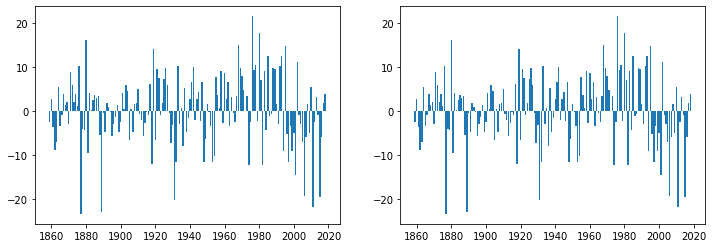

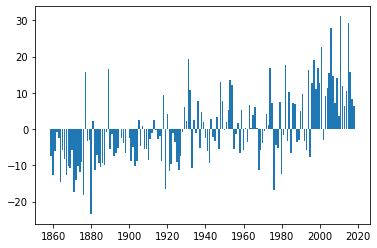

In [9]:
ice_on_residuals = model_ice_on.fittedvalues - hypo_lakes_mean['ice_on_doy']
ice_on_mean_residuals = hypo_lakes_mean['ice_on_doy'] - hypo_lakes_mean['ice_on_doy'].mean()

f, (ax1, ax2) = graph.subplots(1, 2, figsize=(12,4))
ax1.bar(hypo_lakes_mean['start_year'], ice_on_residuals - np.mean(ice_on_residuals))
ax2.bar(hypo_lakes_mean['start_year'], ice_on_residuals)
graph.show()

graph.bar(hypo_lakes_mean['start_year'], ice_on_mean_residuals)
graph.show()

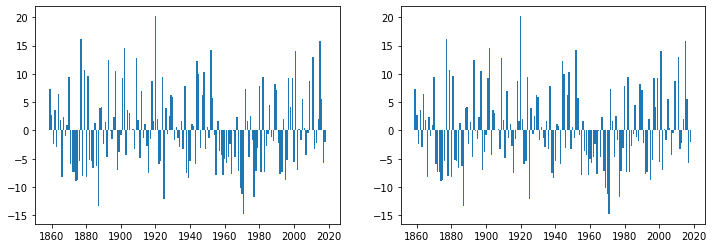

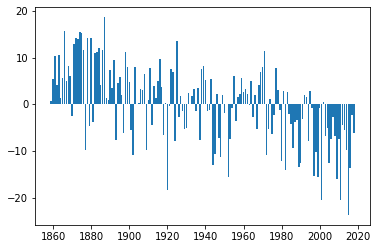

In [10]:
ice_off_residuals = model_ice_off.fittedvalues - hypo_lakes_mean['ice_off_doy']
ice_off_mean_residuals = hypo_lakes_mean['ice_off_doy'] - hypo_lakes_mean['ice_off_doy'].mean()

f, (ax1, ax2) = graph.subplots(1, 2, figsize=(12,4))
ax1.bar(hypo_lakes_mean['start_year'], ice_off_residuals - np.mean(ice_off_residuals))
ax2.bar(hypo_lakes_mean['start_year'], ice_off_residuals)
graph.show()

graph.bar(hypo_lakes_mean['start_year'], ice_off_mean_residuals)
graph.show()

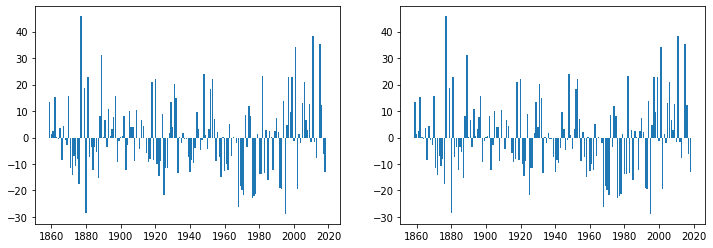

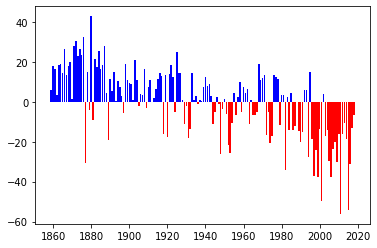

In [11]:
duration_residuals = model_duration.fittedvalues - hypo_lakes_mean['duration']
duration_mean_residuals = hypo_lakes_mean['duration'] - hypo_lakes_mean['duration'].mean()

pos_signal, neg_signal = duration_mean_residuals.copy(), duration_mean_residuals.copy()

pos_signal[pos_signal <= 0] = np.nan
neg_signal[neg_signal > 0] = np.nan

f, (ax1, ax2) = graph.subplots(1, 2, figsize=(12,4))
ax1.bar(hypo_lakes_mean['start_year'], duration_residuals - np.mean(duration_residuals))
ax2.bar(hypo_lakes_mean['start_year'], duration_residuals)
graph.show()

graph.bar(hypo_lakes_mean['start_year'], pos_signal, color='blue')
graph.bar(hypo_lakes_mean['start_year'], neg_signal, color='red')
graph.show()

In [12]:
ice_on_residuals = model_ice_on.fittedvalues - hypo_lakes_mean['ice_on_doy']
ice_on_mean_residuals = hypo_lakes_mean['ice_on_doy'] - hypo_lakes_mean['ice_on_doy'].mean()

pos_ice_on_res, neg_ice_on_res = ice_on_residuals.copy(), ice_on_residuals.copy()
pos_ice_on_mean, neg_ice_on_mean = ice_on_mean_residuals.copy(), ice_on_mean_residuals.copy()

pos_ice_on_res[pos_ice_on_res <=0],  pos_ice_on_mean[pos_ice_on_mean <=0] = np.nan, np.nan
neg_ice_on_res[neg_ice_on_res >0],  neg_ice_on_mean[neg_ice_on_mean >0] = np.nan, np.nan

# Ice OFF
ice_off_residuals = model_ice_off.fittedvalues - hypo_lakes_mean['ice_off_doy']
ice_off_mean_residuals = hypo_lakes_mean['ice_off_doy'] - hypo_lakes_mean['ice_off_doy'].mean()

pos_ice_off_res, neg_ice_off_res = ice_off_residuals.copy(), ice_off_residuals.copy()
pos_ice_off_mean, neg_ice_off_mean = ice_off_mean_residuals.copy(), ice_off_mean_residuals.copy()

pos_ice_off_res[pos_ice_off_res <=0],  pos_ice_off_mean[pos_ice_off_mean <=0] = np.nan, np.nan
neg_ice_off_res[neg_ice_off_res >0],  neg_ice_off_mean[neg_ice_off_mean >0] = np.nan, np.nan

#Duration
duration_residuals = model_duration.fittedvalues - hypo_lakes_mean['duration']
duration_mean_residuals = hypo_lakes_mean['duration'] - hypo_lakes_mean['duration'].mean()

pos_duration_res, neg_duration_res = duration_residuals.copy(), duration_residuals.copy()
pos_duration_mean, neg_duration_mean = duration_mean_residuals.copy(), duration_mean_residuals.copy()

pos_duration_res[pos_duration_res <=0],  pos_duration_mean[pos_duration_mean <=0] = np.nan, np.nan
neg_duration_res[neg_duration_res >0],  neg_duration_mean[neg_duration_mean >0] = np.nan, np.nan

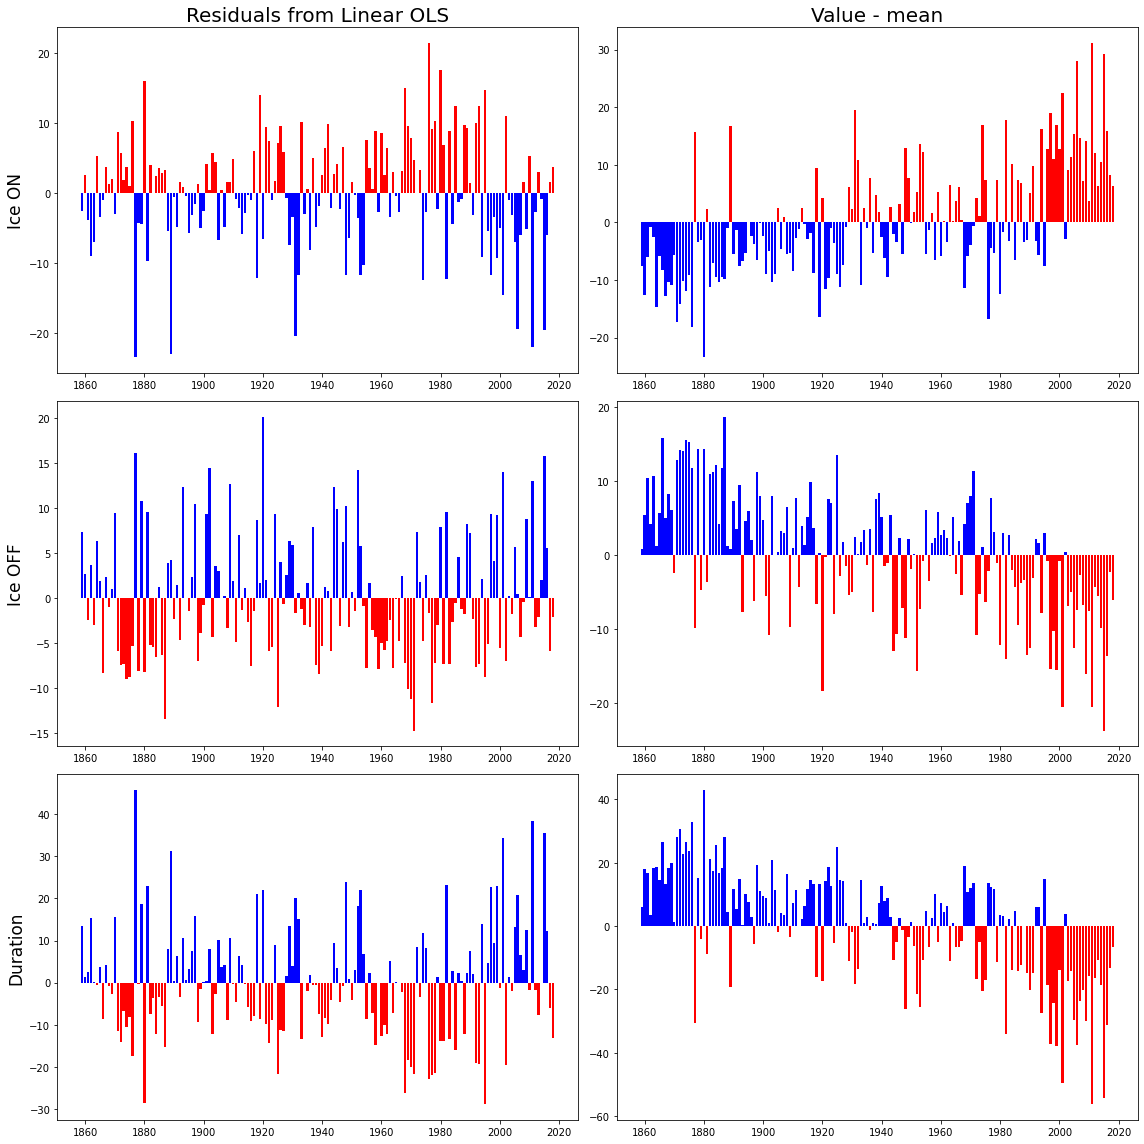

In [16]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = graph.subplots(3, 2, figsize=(16, 16))

ax1.set_title('Residuals from Linear OLS', size=20)
ax1.bar(hypo_lakes_mean['start_year'], pos_ice_on_res, color='red')
ax1.bar(hypo_lakes_mean['start_year'], neg_ice_on_res, color='blue')
ax1.set_ylabel('Ice ON', fontsize=17)

ax2.set_title('Value - mean', size=20)
ax2.bar(hypo_lakes_mean['start_year'], pos_ice_on_mean, color='red')
ax2.bar(hypo_lakes_mean['start_year'], neg_ice_on_mean, color='blue')

ax3.bar(hypo_lakes_mean['start_year'], pos_ice_off_res, color='blue')
ax3.bar(hypo_lakes_mean['start_year'], neg_ice_off_res, color='red')
ax3.set_ylabel('Ice OFF', fontsize=17)
ax4.bar(hypo_lakes_mean['start_year'], pos_ice_off_mean, color='blue')
ax4.bar(hypo_lakes_mean['start_year'], neg_ice_off_mean, color='red')

ax5.bar(hypo_lakes_mean['start_year'], pos_duration_res, color='blue')
ax5.bar(hypo_lakes_mean['start_year'], neg_duration_res, color='red')
ax5.set_ylabel('Duration', fontsize=17)
ax6.bar(hypo_lakes_mean['start_year'], pos_duration_mean, color='blue')
ax6.bar(hypo_lakes_mean['start_year'], neg_duration_mean, color='red')

graph.tight_layout()
# f.savefig('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/residuals_plot.png')

In [17]:
data_res = {'year': hypo_lakes_mean['start_year'], 'ice_on_res': ice_on_mean_residuals, 
            'ice_off_res': ice_off_mean_residuals, 'duration_res': duration_mean_residuals}

residuals_df = pd.DataFrame(data_res, columns = ['year', 'ice_on_res', 'ice_off_res', 'duration_res'])
residuals_df.reset_index()
residuals_df.head()

,year,ice_on_res,ice_off_res,duration_res
44,1859,-7.561630,0.820766,6.180940
45,1860,-12.561630,5.409001,18.090031
46,1861,-6.061630,10.409001,16.635486
47,1862,-0.728297,4.173707,3.453667
48,1863,-2.561630,10.703119,18.453667


In [22]:
rol_7 = residuals_df.rolling(window=7).mean()
rol_11 = residuals_df.rolling(window=11).mean()
rol_15 = residuals_df.rolling(window=15).mean()

In [ ]:
df = residuals_df[]

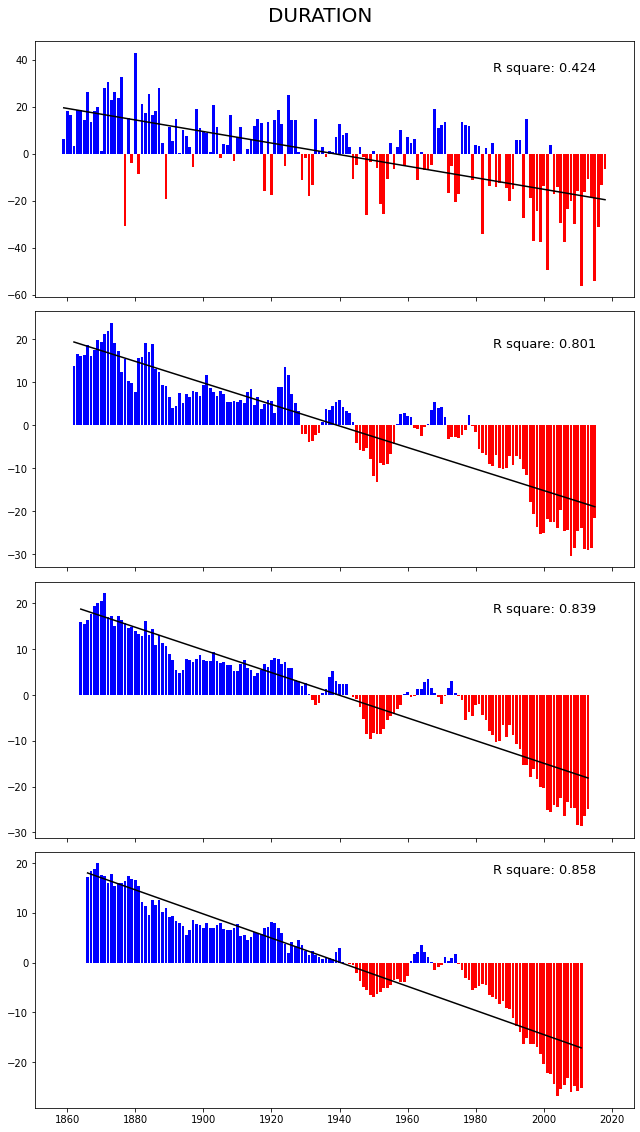

In [70]:
fig, (ax1, ax2, ax3, ax4) = graph.subplots(4, 1, figsize=(9,16), sharex=True)

for df, roll_window, subplot in zip([residuals_df, rol_7, rol_11, rol_15], [1, 7,11,15], [ax1, ax2, ax3, ax4]):
    df = df[roll_window-1:]   
    x = df['year'].values.reshape(-1,1)
    model_duration = LinearRegression().fit(x, df['duration_res'].values.reshape(-1,1))
    pred_duration = model_duration.predict(x)
    score = model_duration.score(x, df['duration_res'].values.reshape(-1,1))
    
    pos_signal, neg_signal = df['duration_res'].values.copy(), df['duration_res'].values.copy()
    pos_signal[pos_signal <=0], neg_signal[neg_signal > 0] = np.nan, np.nan
    
    subplot.bar(df['year'], pos_signal, color='blue')
    subplot.bar(df['year'], neg_signal, color='red')
    subplot.plot(x, pred_duration, color='black')
    if subplot == ax1:
#         subplot.set_ylabel(f'Original', size=15)
        subplot.text(1985, 35, f'R square: {round(score, 3)}', fontsize=15)
    else:
#         subplot.set_ylabel(f'Window {roll_window}', size=15)
        subplot.text(1985, 18, f'R square: {round(score, 3)}', fontsize=15)

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('DURATION', fontsize=20)
fig.savefig('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/duration_residuals.png')

In [18]:
residuals_df.head()

,year,ice_on_res,ice_off_res,duration_res
44,1859,-7.561630,0.820766,6.180940
45,1860,-12.561630,5.409001,18.090031
46,1861,-6.061630,10.409001,16.635486
47,1862,-0.728297,4.173707,3.453667
48,1863,-2.561630,10.703119,18.453667


In [ ]:
f, (ax1, ax2, ax3) = graph.subplots(3, 1, figsize=(9,12), sharex=True)

x = residuals_df['year'].values.reshape(-1, 1)
model_ice_on = LinearRegression().fit(x, residuals_df['ice_on_res'].values.reshape(-1,1))
model_ice_off = LinearRegression().fit(x, residuals_df['ice_off_res_res'].values.reshape(-1,1))
model_duration = LinearRegression().fit(x, residuals_df['duration_res'].values.reshape(-1,1))

pred_ice_on = model_ice_on.predict(x)
pred_ice_off = model_ice_off.predict(x)
pred_duration = model_duration.predict(x)

score_ice_on =  model_ice_on.score(x, residuals_df['ice_on_res'].values.reshape(-1,1))
score_ice_off =  model_ice_on.score(x, residuals_df['ice_off_res'].values.reshape(-1,1))
score_duration =  model_ice_on.score(x, residuals_df['duration_res'].values.reshape(-1,1))

pos_signal_ice_on, neg_signal_ice_on = residuals_df['ice_on_res'].values.copy(), residuals_df['ice_on_res'].values.copy()
pos_signal_ice_on[pos_signal_ice_on <=0], neg_signal_ice_on[neg_signal_ice_on > 0] = np.nan, np.nan

pos_signal_ice_off, neg_signal_ice_off = residuals_df['ice_off_res'].values.copy(), residuals_df['ice_off_res'].values.copy()
pos_signal_ice_off[pos_signal_ice_off <=0], neg_signal_ice_off[neg_signal_ice_off > 0] = np.nan, np.nan

pos_signal_duration, neg_signal_duration = residuals_df['duration_res'].values.copy(), residuals_df['duration_res'].values.copy()
pos_signal_duration[pos_signal_duration <=0], neg_signal_duration[neg_signal_duration > 0] = np.nan, np.nan

ax1.bar(residuals_df['year'], pos_signal_ice_on, color='blue')
ax1.bar(residuals_df['year'], neg_signal_ice_on, color='red')
ax1.plot(x, pred_ice_on, color='black')
ax1.set_ylabel(f'Window {roll_window}', size=15)
ax1.text(1980, 20, f'R square: {round(score, 3)}', fontsize=13)





for df, roll_window, subplot in zip([rol_7, rol_11, rol_15], [7,11,15], [ax1, ax2, ax3]):
    df = df[roll_window-1:]   
    x = df['year'].values.reshape(-1,1)
    model_ice_on = LinearRegression().fit(x, df['duration_res'].values.reshape(-1,1))
    pred_ice_on = model_ice_on.predict(x)
    score = model_ice_on.score(x, df['duration_res'].values.reshape(-1,1))
    
    pos_signal, neg_signal = df['duration_res'].values.copy(), df['duration_res'].values.copy()
    pos_signal[pos_signal <=0], neg_signal[neg_signal > 0] = np.nan, np.nan
    
    subplot.bar(df['year'], pos_signal, color='blue')
    subplot.bar(df['year'], neg_signal, color='red')
    subplot.plot(x, pred_ice_on, color='black')
    subplot.set_ylabel(f'Window {roll_window}', size=15)
    subplot.text(1980, 20, f'R square: {round(score, 3)}', fontsize=13)

f.tight_layout()

# Data with weather and climate data

In [186]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Additional_data/May_25_with_climate.csv')
temp_global_features = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Additional_data/global_features_time_series_v6.csv')
co2_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/co2_spline_merged_ice_core_yearly.csv')

global_features = pd.merge(temp_global_features, co2_df, on='start_year')

unique_lake_codes = df['lakecode'].unique()

for lakecode in unique_lake_codes:
    temp_lake = df[df['lakecode'] == lakecode] 
    lake_name = temp_lake['lake'].unique().item().replace('LAKE', '').replace('lake', '').split('-')[0].split('(')[0].title().strip()
    print(lake_name)
    lake = pd.merge(temp_lake, global_features, on='start_year')
#     lake.to_csv(f'/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/May_25_with_climate/{lake_name}.csv', index=False)

Pennesseewassee
Brant
Cazenovia
Kallavesi
Orsasjon
Winnipesaukee
Geneva
Pielavesi
Baikal
Nasijarvi
Murtensee
Cobbosseecontee
Richardson
Nackten
Lentua
Baldeggersee
Champlain
Mendota
Oulujarvi
Christmas
Moosehead
Gouta
Visuvesi
Houghtons
Lake Serwy
Mirror Lake
Sebec
Kallsjon
Haukivesi
Wilson Lake
Bayfield
Kezar
Thompson
Vesijarvi
Pielinen
Auburn
Sarnersee
Sebago
Lake_Nipissing
Grand Traverse Bay
Hallwilersee
Lej Da San Murezzan
Paijanne
Mooselookmeguntic
Greifensee
Lake_Of_Bays
Sunapee
Detroit
Suwa
Clear
Oneida
Untersee
Shields
Umbagog
Aegerisee
Sempachersee
Rangeley
Monona
Schroon
West Grand
Osakis
Lake Balaton
Shell
Palovesi
Damariscotta
Minnetonka
Kempenfelt_Bay
Runn
Otsego


In [187]:
path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/May_25_with_climate/'

for file in os.listdir(path):
    lake_name = file.split('.')[0]
    df = pd.read_csv(f'{path}{lake}')
    print(lake_name)

Aegerisee
Auburn
Baikal
Baldeggersee
Bayfield
Brant
Cazenovia
Champlain
Christmas
Clear
Cobbosseecontee
Damariscotta
Detroit
Geneva
Gouta
Grand_Traverse_Bay
Greifensee
Hallwilersee
Haukivesi
Houghtons
Kallavesi
Kallsjon
Kempenfelt_Bay
Kezar
Lake_Of_Bays
Lej_Da_San_Murezzan
Lentua
Mendota
Minnetonka
Mirror Lake
Monona
Moosehead
Mooselookmeguntic
Murtensee
Nackten
Nasijarvi
Nipissing
Oneida
Orsasjon
Osakis
Otsego
Oulujarvi
Paijanne
Palovesi
Pennesseewassee
Pielavesi
Pielinen
Rangeley
Richardson
Runn
Sarnersee
Schroon
Sebago
Sebec
Sempachersee
Serwy
Shell
Shields
Sunapee
Suwa
Thompson
Umbagog
Untersee
Vesijarvi
Visuvesi
West Grand
Wilson Lake
Wilson
Winnipesaukee


In [148]:
path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/May_25/'

dfs = []

for file in os.listdir(path):
    lake_name = file.split('.')[0]
    df = pd.read_csv(f'{path}{file}')
    
    linear_regress = []
    
    for var in ['ice_on_doy', 'ice_off_doy', 'duration']:
        if df[var].isna().any():
            linear_regress.append([var, np.nan, np.nan, np.nan, np.nan, np.nan])
            
        else:
            ols_model = sm.OLS(df[var], sm.add_constant(df['start_year'])).fit() # Linear Regression Full
            linear_regress.append([var, ols_model.rsquared, ols_model.rsquared_adj, ols_model.pvalues.values.item(1), 
                                   ols_model.params.values.item(1), ols_model.aic])
    dfs.append([lake_name, linear_regress])

In [149]:
df = pd.DataFrame(dfs)

df.rename(columns={0: 'lake', 1: 'linear_rem'}, inplace=True)

df[['ice_on_rem', 'ice_off_rem', 'duration_rem']] = pd.DataFrame(df['linear_rem'].values.tolist(), index=df.index)

ice_on_col_names = ['ice_on_var_rem_', 'ice_on_rsquared', 'ice_on_adjusted_rsquared', 
                         'ice_on_p', 'ice_on_coef', 'ice_on_aic']
ice_off_col_names = ['ice_off_var_rem_', 'ice_off_rsquared', 'ice_off_adjusted_rsquared', 
                         'ice_off_p', 'ice_off_coef', 'ice_off_aic']
duration_col_names = ['duration_var_rem_', 'duration_rsquared', 'duration_adjusted_rsquared', 
                         'duration_p', 'duration_coef', 'duration_aic']

df[ice_on_col_names] = pd.DataFrame(df['ice_on_rem'].values.tolist(), index=df.index)
df[ice_off_col_names] = pd.DataFrame(df['ice_off_rem'].values.tolist(), index=df.index)
df[duration_col_names] = pd.DataFrame(df['duration_rem'].values.tolist(), index=df.index)

df.drop(columns=[col for col in df.columns if 'rem' in col], inplace=True)
df.drop(columns=[col for col in df.columns if 'aic' in col], inplace=True)
df.drop(columns=['ice_on_rsquared', 'ice_off_rsquared', 'duration_rsquared'], inplace=True)
display(df.head())
# df.to_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/linear_regression_june_16_2020.csv', index=False)

,lake,ice_on_adjusted_rsquared,ice_on_p,ice_on_coef,ice_off_adjusted_rsquared,ice_off_p,ice_off_coef,duration_adjusted_rsquared,duration_p,duration_coef
0,Aegerisee,0.008886,1.664824e-01,0.104784,NaN,NaN,NaN,NaN,NaN,NaN
1,Auburn,NaN,NaN,NaN,0.173007,2.585070e-09,-0.074722,NaN,NaN,NaN
2,Baikal,0.196299,7.322966e-09,0.110910,0.060921,1.310551e-03,-0.047055,0.198372,6.012843e-09,-0.157964
3,Balaton,0.002530,2.505263e-01,0.060591,-0.007621,9.238590e-01,-0.005560,-0.002751,4.249464e-01,-0.053101
4,Baldeggersee,0.121896,2.970212e-05,0.164261,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
linear_regress_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/linear_regression_june_16_2020.csv')
break_years_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/break_years_piecewise_aic.csv')

combined_df = pd.merge(break_years_df, linear_regress_df, on='lake')
# display(combined_df.head())
# combined_df.to_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/linear_regress_piecewise_aic_june_16_2020.csv', 
#                    index=False)

In [4]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/'

y_columns =['ice_on_doy', 'ice_off_doy', 'duration']
x_columns = ['PDO mean A-DEC' ,'QBO mean A-DEC', 'SOI mean A-DEC', 'NINO3 mean A-DEC', 'AO mean A-DEC', 
             'AMO mean A-DEC', 'NAO DJFM', 'tmp_DJF', 'tmp_MAM', 'tmp_lagSON', 'global_merged_co2_annual (ppm)', 
             'ENSO paleo A-DEC', 'Daily Total Sunspot Number mean A-DEC', 'NH', 'SH']
global_features = []
weather_features = []

# for file in os.listdir(path):
#     lake_name = file.split('.')[0]
#     df = pd.read_csv(f'{path}{file}')


In [9]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/'

y_columns =['duration', 'ice_on_doy', 'ice_off_doy']
x_columns = ['PDO mean A-DEC' ,'QBO mean A-DEC', 'SOI mean A-DEC', 'NINO3 mean A-DEC', 'AO mean A-DEC', 
             'AMO mean A-DEC', 'NAO DJFM', 'tmp_DJF', 'tmp_MAM', 'tmp_lagSON', 'global_merged_co2_annual (ppm)', 
             'ENSO paleo A-DEC', 'Daily Total Sunspot Number mean A-DEC', 'NH', 'SH']
results_columns = ['lake', 'numb_features', 'x_data', 'y_data', 'adj_r2_start_year', 
                   'r2', 'r2_adj', 'pvalues', 'coefs', 'aic', 'bic']

for file in os.listdir(path):
    lake_name = file.split('.')[0]
    print(lake_name)
    df = pd.read_csv(f'{path}{file}')
    best_subset_linear_regress = [] 
    
    for y in ['ice_off_doy']:
        print(y)
        Y = df[y]
        X = df[x_columns]
        start_year_data = df['start_year']
        if Y.isna().any():
            continue
        else:
            for k in trange(1, len(X.columns) + 1, desc = 'Loop...'):
                for combo in itertools.combinations(X.columns, k):
                    X_2 = X[list(combo)]
                    X_2 = X_2.dropna()
                    X_2 = sm.add_constant(X_2)
                    Y_2 = Y[-len(X_2):]
                    Y_2 = list(Y_2)
                    x_start_year = start_year_data[-len(X_2):]
                    x_start_year = list(x_start_year)
                    
                    results_start_year = sm.OLS(Y_2, sm.add_constant(x_start_year)).fit()
                    y_resid = results_start_year.resid                    
                    
                    results = sm.OLS(y_resid, X_2).fit()

                    df = pd.DataFrame(columns=results_columns)
                    df = df.append({'lake': lake_name, 
                                    'numb_features': len(combo), 
                                    'x_data': combo, 
                                    'y_data': y,
                                    'adj_r2_start_year': results_start_year.rsquared_adj,
                                    'r2': results.rsquared, 
                                    'r2_adj': results.rsquared_adj, 
                                    'pvalues':  results.pvalues.values, 
                                    'coefs': results.params.values, 
                                    'aic': results.aic, 
                                    'bic': results.bic,
                                    'log_likelihood': results.llf,
                                    'f_pvalue': results.f_pvalue, 
                                    'fvalue': results.fvalue, 
                                    'model': results.model
                               }, ignore_index=True)
                    best_subset_linear_regress.append(df)
            lake_linear_regress_subsets = pd.concat(best_subset_linear_regress).sort_values(by=['r2_adj'], 
                                                                                            ascending=True)
            lake_linear_regress_subsets.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Multi_linear_resid/{lake_name}_{y}_linear_regress_subsets.csv', 
                                               index=False)

Auburn


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [08:31<00:00, 34.09s/it]


Bayfield


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [09:01<00:00, 36.13s/it]


Cazenovia


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [08:05<00:00, 32.35s/it]


Champlain


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy
Cobbosseecontee
ice_off_doy


Loop...: 100%|██████████| 15/15 [08:20<00:00, 33.37s/it]


Damariscotta


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [08:10<00:00, 32.73s/it]


Grand Traverse Bay


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [09:55<00:00, 39.68s/it]


Kallavesi


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [08:02<00:00, 32.19s/it]


Kempenfelt_Bay


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [08:04<00:00, 32.32s/it]


Lej Da San Murezzan


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [06:58<00:00, 27.90s/it]


Mendota


Loop...: 100%|██████████| 15/15 [06:22<00:00, 25.51s/it]


ice_off_doy
Monona


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [07:45<00:00, 31.04s/it]


Moosehead


Loop...: 100%|██████████| 15/15 [08:06<00:00, 32.43s/it]


ice_off_doy
Nasijarvi


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [08:18<00:00, 33.25s/it]


Oneida


Loop...: 100%|██████████| 15/15 [08:02<00:00, 32.17s/it]


ice_off_doy
Otsego


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [08:48<00:00, 35.26s/it]


Oulujarvi


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [08:08<00:00, 32.55s/it]


Runn


Loop...:   0%|          | 0/15 [00:00<?, ?it/s]

ice_off_doy


Loop...: 100%|██████████| 15/15 [08:05<00:00, 32.35s/it]


In [18]:
x_columns = ['PDO mean A-DEC' ,'QBO mean A-DEC', 'SOI mean A-DEC', 'NINO3 mean A-DEC', 'AO mean A-DEC', 
             'AMO mean A-DEC', 'NAO DJFM', 'tmp_DJF', 'tmp_MAM', 'tmp_lagSON', 'global_merged_co2_annual (ppm)', 
             'ENSO paleo A-DEC', 'Daily Total Sunspot Number mean A-DEC', 'NH', 'SH']

column_replacements = {'PDO mean A-DEC': 'PDO', 'QBO mean A-DEC': 'QBO', 'SOI mean A-DEC': 'SOI', 'NINO3 mean A-DEC': 'NINO3', 
                       'AO mean A-DEC': 'AO', 'AMO mean A-DEC': 'AMO', 'NAO DJFM': 'NAO_DJFM', 
                       'global_merged_co2_annual (ppm)': 'co2', 'ENSO paleo A-DEC': 'ENSO', 
                       'Daily Total Sunspot Number mean A-DEC': 'sunspot'}

df = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/Bayfield.csv')
df.rename(columns=column_replacements, inplace=True)

Y = df['ice_off_doy']
X = df[['QBO', 'NAO_DJFM', 'tmp_DJF', 
        'tmp_MAM', 'co2']]
X_2 = X[X.columns]
X_2 = X_2.dropna()
X_2 = sm.add_constant(X_2)
Y_2 = Y[-len(X_2):]
Y_2 = list(Y_2)
                    
results = sm.OLS(Y_2, X_2).fit()
results_summary = results.summary()

results.summary().tables[1]
display(results.summary2())

/home/arshad/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.739   
Dependent Variable: y                AIC:                485.0381
Date:               2020-08-04 10:32 BIC:                498.6142
No. Observations:   71               Log-Likelihood:     -236.52 
Df Model:           5                F-statistic:        40.70   
Df Residuals:       65               Prob (F-statistic): 9.40e-19
R-squared:          0.758            Scale:              50.045  
------------------------------------------------------------------
             Coef.    Std.Err.     t     P>|t|    [0.025   0.975] 
------------------------------------------------------------------
const       112.3485   12.5542   8.9491  0.0000  87.2761  137.4210
QBO           0.1114    0.1053   1.0581  0.2939  -0.0988    0.3216
NAO_DJFM      0.8191    0.4053   2.0207  0.0474   0.0095    1.6286
tmp_DJF      -3.5471    0.4301  -8.2467  0.0000  -4.4061   -2.6881
tmp_MAM      -3.7037    0.5926  -6.2500  0.0000  -4.8872   -2.5202
co2          -0.1168    0.0318  -3.6781  0.0005  -0.1802   -0.0534
-----------------------------------------------------------------
Omnibus:               5.031        Durbin-Watson:          1.898
Prob(Omnibus):         0.081        Jarque-Bera (JB):       4.343
Skew:                  -0.591       Prob(JB):               0.114
Kurtosis:              3.265        Condition No.:          5199 
=================================================================
* The condition number is large (5e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [34]:
x_columns = ['PDO mean A-DEC' ,'QBO mean A-DEC', 'SOI mean A-DEC', 'NINO3 mean A-DEC', 'AO mean A-DEC', 
             'AMO mean A-DEC', 'NAO DJFM', 'tmp_DJF', 'tmp_MAM', 'tmp_lagSON', 'global_merged_co2_annual (ppm)', 
             'ENSO paleo A-DEC', 'Daily Total Sunspot Number mean A-DEC', 'NH', 'SH']

column_replacements = {'PDO mean A-DEC': 'PDO', 'QBO mean A-DEC': 'QBO', 'SOI mean A-DEC': 'SOI', 'NINO3 mean A-DEC': 'NINO3', 
                       'AO mean A-DEC': 'AO', 'AMO mean A-DEC': 'AMO', 'NAO DJFM': 'NAO_DJFM', 
                       'global_merged_co2_annual (ppm)': 'co2', 'ENSO paleo A-DEC': 'ENSO', 
                       'Daily Total Sunspot Number mean A-DEC': 'sunspot'}

In [35]:
df = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/Kempenfelt Bay.csv')

results_start_year = sm.OLS(df['ice_off_doy'], sm.add_constant(df['start_year'])).fit()
print(f'Year_adj_r2: {results_start_year.rsquared_adj}')                  
df['y_resid'] = results_start_year.resid
df.rename(columns=column_replacements, inplace=True)

results_formula = smf.ols(formula='y_resid ~ PDO  + AO  + AMO + NAO_DJFM + tmp_DJF + tmp_lagSON + ENSO', 
                          data = df).fit()
print(f'Adj_r2: {results_formula.rsquared}')
print(f'AIC: {results_formula.aic}')
print('\n')
for var, x in zip(results_formula.summary2().tables[1].index, results_formula.summary2().tables[1]['Coef.'].round(2)):
    print(x, var, sep='*', end=' + ', flush=True)
print('\n')

partitioning_variance = stats_models.anova.anova_lm(results_formula)
partitioning_variance['partition'] = partitioning_variance['sum_sq'] / partitioning_variance['sum_sq'].sum() * 100
for x, proportion in zip(partitioning_variance.index, partitioning_variance['partition'].round(2)):
    print(x, proportion, sep='=', end='; ', flush=True) 

Year_adj_r2: 0.2851493567285095
Adj_r2: 0.1139424825093931
AIC: 392.8600388917554


-5.27*Intercept + 1.73*PDO + 0.65*AO + -12.85*AMO + -0.31*NAO_DJFM + -1.34*tmp_DJF + 1.01*tmp_lagSON + -0.74*ENSO + 

PDO=1.62; AO=0.31; AMO=4.93; NAO_DJFM=0.95; tmp_DJF=2.21; tmp_lagSON=0.72; ENSO=0.65; Residual=88.61; 

In [ ]:
df = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/Grand Traverse Bay.csv')

results_start_year = smf.ols(formula='ice_on_doy ~ start_year', data = df).fit()
print(f'Year_adj_r2: {results_start_year.rsquared_adj}')                  
partitioning_variance = stats_models.anova.anova_lm(results_start_year)
partitioning_variance['partition'] = partitioning_variance['sum_sq'] / partitioning_variance['sum_sq'].sum() * 100
partitioning_variance['partition'][0]

In [48]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/'

duration_variance_explained = []
for file in os.listdir(path):
    lake_name = file.split('.')[0]
    print(lake_name)
    df = pd.read_csv(f'{path}{file}')
    
    if df['duration'].isna().any():
        continue
    else:
        results_start_year = smf.ols(formula='duration ~ start_year', data = df).fit()
        partitioning_variance = stats_models.anova.anova_lm(results_start_year)
        partitioning_variance['partition'] = partitioning_variance['sum_sq'] / partitioning_variance['sum_sq'].sum() * 100
        variance_explained_linear_model = partitioning_variance['partition'][0]
        ice_off_doy_variance_explained.append([lake_name, 'Duration', variance_explained_linear_model])

Auburn
Bayfield
Cazenovia
Champlain
Cobbosseecontee
Damariscotta
Grand Traverse Bay
Kallavesi
Kempenfelt_Bay
Lej Da San Murezzan
Mendota
Monona
Moosehead
Nasijarvi
Oneida
Otsego
Oulujarvi
Runn


In [53]:
ice_on = pd.DataFrame(ice_on_doy_variance_explained, columns=['lake', 'response_variable', 'linear_model_proportion_variance_explained'])
ice_off = pd.DataFrame(ice_off_doy_variance_explained, columns=['lake', 'response_variable', 'linear_model_proportion_variance_explained'])
duration = pd.DataFrame(duration_variance_explained, columns=['lake', 'response_variable', 'linear_model_proportion_variance_explained'])

linear_model_var_explained = pd.concat([ice_on, ice_off, duration])
linear_model_var_explained.to_csv('/mnt/c/Users/imrit/Desktop/Variance_explained_detrended_model.csv', index=False)

In [8]:
results_as_html = results_summary.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df.reset_index(level=0, inplace=True)
results_df.rename(columns={'index': 'x_var'}, inplace=True)
display(results_df)

,x_var,coef,std err,t,P>|t|,[0.025,0.975]
0,const,99.7536,12.112,8.236,0.000,75.542,123.966
1,SOI mean A-DEC,2.0764,1.148,1.809,0.075,-0.218,4.371
2,AO mean A-DEC,3.2585,2.676,1.218,0.228,-2.090,8.607
3,NAO DJFM,-1.0865,0.494,-2.200,0.032,-2.074,-0.099
4,tmp_DJF,-2.5506,0.612,-4.169,0.000,-3.773,-1.328
5,tmp_MAM,-4.1533,0.838,-4.957,0.000,-5.828,-2.479
6,tmp_lagSON,1.6085,1.069,1.504,0.138,-0.529,3.746


In [9]:
print(results_df['coef'])

0    99.7536
1     2.0764
2     3.2585
3    -1.0865
4    -2.5506
5    -4.1533
6     1.6085
Name: coef, dtype: float64


In [30]:
df = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Multiple_linear_regressions/Bayfield_duration_linear_regress_subsets.csv')
print(len(df))

32767


In [14]:
df = df[~df['x_data'].str.contains('global_merged_co2_annual (ppm)')]
print(len(df))

32767


/home/arshad/miniconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [33]:
df = df[~df['x_data'].str.contains("global_merged_co2_annual")]
df = df[~df['x_data'].str.contains("(ppm)")]
print(len(df))

16383


In [31]:
df['x_data'][1].split()

["('PDO",
 'mean',
 "A-DEC',",
 "'SOI",
 'mean',
 "A-DEC',",
 "'NINO3",
 'mean',
 "A-DEC',",
 "'AO",
 'mean',
 "A-DEC',",
 "'global_merged_co2_annual",
 "(ppm)',",
 "'SH')"]

In [35]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Multiple_linear_regressions/'

for file in os.listdir(path):
    file_name = file.split('.')[0]
    print(file_name)
    df = pd.read_csv(f'{path}{file}')
    df = df[~df['x_data'].str.contains("global_merged_co2_annual")]
    df = df[~df['x_data'].str.contains("(ppm)")]
    #     df_2 = df.sort_values(['numb_features', 'rsquared_adj'], ascending=False, axis=0).groupby('numb_features').head(3)
#     df_3 = df_2.sort_values(['numb_features', 'aic'], ascending=True, axis=0).groupby('numb_features').head(3)
#     df_2 = df.sort_values(['numb_features', 'rsquared_adj'], ascending=False, axis=0).groupby('numb_features').head(2)
    df_2 = df.sort_values(['rsquared_adj'], ascending=False, axis=0).head(10)
    df_3 = df_2.sort_values(['aic'], ascending=True, axis=0)
    df_3.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Multiple_linear_regressions_lowest_15_aic/{file_name}_top_3_Rsquare.csv', 
                index=False)

Auburn_ice_off_doy_linear_regress_subsets
Bayfield_duration_linear_regress_subsets
Bayfield_ice_off_doy_linear_regress_subsets
Bayfield_ice_on_doy_linear_regress_subsets
Cazenovia_duration_linear_regress_subsets
Cazenovia_ice_off_doy_linear_regress_subsets
Cazenovia_ice_on_doy_linear_regress_subsets
Champlain_ice_on_doy_linear_regress_subsets
Cobbosseecontee_ice_off_doy_linear_regress_subsets
Damariscotta_ice_off_doy_linear_regress_subsets
Grand Traverse Bay_duration_linear_regress_subsets
Grand Traverse Bay_ice_off_doy_linear_regress_subsets
Grand Traverse Bay_ice_on_doy_linear_regress_subsets
Kallavesi_duration_linear_regress_subsets
Kallavesi_ice_off_doy_linear_regress_subsets
Kallavesi_ice_on_doy_linear_regress_subsets
Kempenfelt_Bay_duration_linear_regress_subsets
Kempenfelt_Bay_ice_off_doy_linear_regress_subsets
Kempenfelt_Bay_ice_on_doy_linear_regress_subsets
Lej Da San Murezzan_ice_off_doy_linear_regress_subsets
Mendota_duration_linear_regress_subsets
Mendota_ice_off_doylinear_

In [10]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Multiple_linear_regressions_lowest_15_aic/'
ice_on_files = [x for x in os.listdir(path) if 'ice_on' in x]
ice_off_files = [x for x in os.listdir(path) if 'ice_off' in x]
duration_files = [x for x in os.listdir(path) if 'duration' in x]

file_lists = [ice_on_files, ice_off_files, duration_files]
variables = ['ice_on', 'ice_off', 'duration']

for var_subsets, var in zip(file_lists, variables):
    dfs = []
    for file in var_subsets:
        df = pd.read_csv(f'{path}{file}')
        df = df.sort_values(['rsquared_adj'], ascending=False, axis=0).head(3)
        dfs.append(df)
    final_df = pd.concat(dfs)
    final_df.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/{var}_multiple_linear_regress.csv', index=False)
        

# Sapna cluster and windows sens slope

In [32]:
# New data September 1st 2020

df = pd.read_csv('/mnt/c/Users/imrit/Downloads/60_lakes_timeseries.csv')
df = df[['lake', 'start_year', 'ice_on_doy_imputed_icefree', 'ice_off_doy_imputed_icefree', 'total_duration_imputed_icefree']]

for variable, csv_name in zip(['ice_on_doy_imputed_icefree', 'ice_off_doy_imputed_icefree', 'total_duration_imputed_icefree'], 
                              ['ice_on', 'ice_off', 'duration']):
    df_var = df[['lake', 'start_year', variable]]
    df_transposed = df_var.pivot(index='lake', columns='start_year', values=variable)
    df_transposed.reset_index(level=0, inplace=True)
#     df_transposed.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Clusters_data/Original_sept_2_2020/{csv_name}_cluster_analysis_sept_2_2020.csv', 
#                          index=False)

# ice_on = df[['lake', 'start_year', 'ice_on_doy_imputed_icefree']]
# ice_off = df[['lake', 'start_year', 'ice_off_doy_imputed_icefree']]
# duration = df[['lake', 'start_year', 'total_duration_imputed_icefree']]

# display(duration.head())

# df1 = duration.pivot(index='lake', columns='start_year', values='total_duration_imputed_icefree')
# df1.reset_index(level=0, inplace=True).
# df1.head()



In [39]:
# TRanspose data

path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Clusters_data/Original_sept_2_2020/'

for file in os.listdir(path):
    var_name = file.split('_cluster')[0]
    print(var_name)
    df = pd.read_csv(f'{path}{file}')
    df = df.set_index('lake').T.reset_index()
    df.rename(columns={'index': 'start_year'}, inplace=True)
    df.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Clusters_data/Transposed_sept_2_2020/{var_name}_transposed_sept_2_2020.csv', 
              index=False)

duration
ice_off
ice_on


In [4]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Clusters_data/Oct_12/'

for file in os.listdir(path):
    df = pd.read_csv(f'{path}{file}')
    var_name = file.split('_transposed')[0]
    print(var_name)
    df.dropna(inplace=True)
    print(f"Minimum year = {df['start_year'].min()}", f", Maximum_year = {df['start_year'].max()}")

duration
Minimum year = 1904 , Maximum_year = 2016
ice_off
Minimum year = 1909 , Maximum_year = 2016
ice_on
Minimum year = 1904 , Maximum_year = 2016


In [47]:
path = '/mnt/c/Users/imrit/Desktop/Ice_off_cluster_windows/'

start_years = [1914, 1914, 1964, 1914, 1939, 1964, 1989]
end_years = [2013, 1963, 2013, 1938, 1963, 1988, 2013]

for file in os.listdir(path):
    df = pd.read_csv(f'{path}{file}')
    lake_names = df.columns[1:]
    var_name = file.split('_transposed')[0]
    print(var_name)

    var_df_sens = []
    var_df_linear = []

    for lake_name in lake_names:
        lake_df = df[['start_year', lake_name]]
#         print(lake_name)

        sens_df = []
        linear_regress_df = []

        for start, end in zip(start_years, end_years):
            year_range = str(start) + '-' + str(end)
            df_temp = lake_df[lake_df['start_year'].between(start, end, inclusive=True)]
            
            lr_model = sm.OLS(df_temp[lake_name], sm.add_constant(df_temp['start_year'])).fit()
            
            df_linear = pd.DataFrame(columns=['lake', f"{year_range}_slope"])
            df_linear = df_linear.append({'lake': lake_name, 
                                        f"{year_range}_slope": lr_model.params.values[1]
                                       }, ignore_index=True)
            linear_regress_df.append(df_linear)
            var_df_linear.append(df_linear)
            
            r_var = robjects.IntVector(df_temp[lake_name])
            sens = trend.sens_slope(r_var)
            slope_sens = np.array(sens[0]).item()
            p_sens = np.array(sens[2]).item()

            df_sens = pd.DataFrame(columns=['lake', f"{year_range}_slope"])
            df_sens = df_sens.append({'lake': lake_name, 
                            f"{year_range}_slope": slope_sens
                               }, ignore_index=True)
            sens_df.append(df_sens)
            var_df_sens.append(df_sens)

    for df, model in zip([var_df_sens, var_df_linear], ['sens', 'linear_regress']):
        df = pd.concat(df)
        for col in df.columns[:-1]:
            df[col] = df[col].fillna(df.groupby('lake')[col].transform('mean'))
        df.drop_duplicates(inplace=True)
        df = df[df.columns[::-1]]
#         display(df.head())
        df.to_csv(f'/mnt/c/Users/imrit/Desktop/Ice_off_cluster_windows/clusters_{model}_{var_name}_sept_16_2020.csv', index=False)
    

iceoff_cluster_OG.csv


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



ice_off


In [109]:
# path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Clusters_data/Transposed_sept_2_2020/'
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Clusters_data/Oct_12/'


# start_years = [1914, 1914, 1964, 1914, 1939, 1964, 1989]
# end_years = [2013, 1963, 2013, 1938, 1963, 1988, 2013]

start_years = [1917, 1942, 1967, 1992]
end_years = [1941, 1966, 1991, 2016]

for file in os.listdir(path):
    df = pd.read_csv(f'{path}{file}')
    lake_names = df.columns[1:]
    var_name = file.split('_transposed')[0]
    print(var_name)

    var_df_sens = []
    var_df_linear = []

    for lake_name in lake_names:
        lake_df = df[['start_year', lake_name]]
#         print(lake_name)

        sens_df = []
        linear_regress_df = []

        for start, end in zip(start_years, end_years):
            year_range = str(start) + '-' + str(end)
            df_temp = lake_df[lake_df['start_year'].between(start, end, inclusive=True)]
            
            lr_model = sm.OLS(df_temp[lake_name], sm.add_constant(df_temp['start_year'])).fit()
            
            df_linear = pd.DataFrame(columns=['lake', f"{year_range}_slope", f"{year_range}_p"])
            df_linear = df_linear.append({'lake': lake_name, 
                                        f"{year_range}_slope": lr_model.params.values[1], 
                                        f"{year_range}_p": lr_model.pvalues.values[1]
                                       }, ignore_index=True)
            linear_regress_df.append(df_linear)
            var_df_linear.append(df_linear)
            
            r_var = robjects.IntVector(df_temp[lake_name])
            sens = trend.sens_slope(r_var)
            slope_sens = np.array(sens[0]).item()
            p_sens = np.array(sens[2]).item()

            df_sens = pd.DataFrame(columns=['lake', f"{year_range}_slope", f"{year_range}_p"])
            df_sens = df_sens.append({'lake': lake_name, 
                            f"{year_range}_slope": slope_sens,
                            f"{year_range}_p": p_sens
                               }, ignore_index=True)
            sens_df.append(df_sens)
            var_df_sens.append(df_sens)

    for df, model in zip([var_df_sens, var_df_linear], ['sens', 'linear_regress']):
        df = pd.concat(df)
        display(df.head())
        for col in df.columns[:-1]:
            df[col] = df[col].fillna(df.groupby('lake')[col].transform('mean'))
        df.drop_duplicates(inplace=True)
        df = df[df.columns[::-1]]
        display(df.head())
#         display(df.head())
#         df.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Clusters/Oct_12/clusters_{model}_{var_name}_oct_12_2020.csv', index=False)
    
#     var_df_sens = pd.concat(var_df_sens)
#     var_df_linear = pd.concat(var_df_linear)
#     for col in var_df.columns[:-1]:
#         var_df[col] = var_df[col].fillna(var_df.groupby('lake')[col].transform('mean'))   
#     var_df.drop_duplicates(inplace=True)
#     var_df = var_df[var_df.columns[::-1]]
#     display(var_df.head())
#     var_df_sens.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/clusters_sens_{var_name}.csv', index=False)
#     var_df_linear.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/clusters_linear_regress_{var_name}.csv', index=False)

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,1917-1941_p,1917-1941_slope,1942-1966_p,1942-1966_slope,1967-1991_p,1967-1991_slope,1992-2016_p,1992-2016_slope,lake
0,0.325977,-0.331818,NaN,NaN,NaN,NaN,NaN,NaN,baikal
0,NaN,NaN,0.386389,-0.384921,NaN,NaN,NaN,NaN,baikal
0,NaN,NaN,NaN,NaN,0.028009,-0.894737,NaN,NaN,baikal
0,NaN,NaN,NaN,NaN,NaN,NaN,0.833426,0.154762,baikal
0,0.064885,1.696272,NaN,NaN,NaN,NaN,NaN,NaN,balaton


,lake,1992-2016_slope,1992-2016_p,1967-1991_slope,1967-1991_p,1942-1966_slope,1942-1966_p,1917-1941_slope,1917-1941_p
0,baikal,0.154762,0.833426,-0.894737,0.028009,-0.384921,0.386389,-0.331818,0.325977
0,balaton,-1.311741,0.116966,-1.500000,0.140976,0.000000,1.000000,1.696272,0.064885
0,bayfield,-1.320513,0.146546,-0.275253,0.467684,-0.026316,0.906887,-0.366071,0.512268
0,cazenovia,-0.691576,0.292744,-1.000000,0.035407,0.000000,1.000000,0.800000,0.054171
0,detroit,-0.354167,0.574533,0.000000,0.832916,-0.264912,0.386736,-0.473389,0.251597


,1917-1941_p,1917-1941_slope,1942-1966_p,1942-1966_slope,1967-1991_p,1967-1991_slope,1992-2016_p,1992-2016_slope,lake
0,0.353596,-0.331538,NaN,NaN,NaN,NaN,NaN,NaN,baikal
0,NaN,NaN,0.310033,-0.428462,NaN,NaN,NaN,NaN,baikal
0,NaN,NaN,NaN,NaN,0.051828,-0.77,NaN,NaN,baikal
0,NaN,NaN,NaN,NaN,NaN,NaN,0.782379,-0.148462,baikal
0,0.055607,1.590000,NaN,NaN,NaN,NaN,NaN,NaN,balaton


,lake,1992-2016_slope,1992-2016_p,1967-1991_slope,1967-1991_p,1942-1966_slope,1942-1966_p,1917-1941_slope,1917-1941_p
0,baikal,-0.148462,0.782379,-0.770000,0.051828,-0.428462,0.310033,-0.331538,0.353596
0,balaton,-1.363846,0.073107,-1.387692,0.104573,0.186923,0.818245,1.590000,0.055607
0,bayfield,-1.489231,0.135606,-0.509231,0.337507,-0.072308,0.865128,-0.357692,0.479107
0,cazenovia,-0.377692,0.534531,-0.908462,0.046272,-0.163846,0.700069,0.759231,0.021874
0,detroit,-0.355385,0.461666,0.033077,0.904177,-0.198462,0.636155,-0.435385,0.276856


ice_off


,1917-1941_p,1917-1941_slope,1942-1966_p,1942-1966_slope,1967-1991_p,1967-1991_slope,1992-2016_p,1992-2016_slope,lake
0,0.386736,0.30602,NaN,NaN,NaN,NaN,NaN,NaN,auburn
0,NaN,NaN,0.071658,0.5,NaN,NaN,NaN,NaN,auburn
0,NaN,NaN,NaN,NaN,0.016013,-0.545455,NaN,NaN,auburn
0,NaN,NaN,NaN,NaN,NaN,NaN,0.496413,-0.105556,auburn
0,0.512191,0.20000,NaN,NaN,NaN,NaN,NaN,NaN,baikal


,lake,1992-2016_slope,1992-2016_p,1967-1991_slope,1967-1991_p,1942-1966_slope,1942-1966_p,1917-1941_slope,1917-1941_p
0,auburn,-0.105556,0.496413,-0.545455,0.016013,0.500000,0.071658,0.306020,0.386736
0,baikal,0.190909,0.725664,-0.289916,0.182156,0.088933,0.541968,0.200000,0.512191
0,balaton,-0.555556,0.542633,0.000000,0.925305,-0.033333,0.944081,0.904545,0.133958
0,bayfield,-0.690476,0.159790,-0.124242,0.742537,0.138095,0.690808,0.000000,0.943784
0,brant,-0.121429,0.707550,-0.500000,0.057928,0.166667,0.346803,0.411765,0.120720


,1917-1941_p,1917-1941_slope,1942-1966_p,1942-1966_slope,1967-1991_p,1967-1991_slope,1992-2016_p,1992-2016_slope,lake
0,0.225760,0.280769,NaN,NaN,NaN,NaN,NaN,NaN,auburn
0,NaN,NaN,0.047654,0.461538,NaN,NaN,NaN,NaN,auburn
0,NaN,NaN,NaN,NaN,0.011019,-0.623846,NaN,NaN,auburn
0,NaN,NaN,NaN,NaN,NaN,NaN,0.573047,-0.173846,auburn
0,0.387349,0.192308,NaN,NaN,NaN,NaN,NaN,NaN,baikal


,lake,1992-2016_slope,1992-2016_p,1967-1991_slope,1967-1991_p,1942-1966_slope,1942-1966_p,1917-1941_slope,1917-1941_p
0,auburn,-0.173846,0.573047,-0.623846,0.011019,0.461538,0.047654,0.280769,0.225760
0,baikal,0.021538,0.946106,-0.234615,0.203773,0.058462,0.745352,0.192308,0.387349
0,balaton,-0.656154,0.334500,-0.704615,0.373051,0.207692,0.714806,1.296923,0.108307
0,bayfield,-0.586923,0.181874,-0.273077,0.419877,0.100000,0.701172,-0.040769,0.890274
0,brant,-0.257692,0.366156,-0.449231,0.054839,0.363846,0.143117,0.383077,0.066226


ice_on


,1917-1941_p,1917-1941_slope,1942-1966_p,1942-1966_slope,1967-1991_p,1967-1991_slope,1992-2016_p,1992-2016_slope,lake
0,0.031306,0.567251,NaN,NaN,NaN,NaN,NaN,NaN,baikal
0,NaN,NaN,0.251683,0.486842,NaN,NaN,NaN,NaN,baikal
0,NaN,NaN,NaN,NaN,0.033015,0.566964,NaN,NaN,baikal
0,NaN,NaN,NaN,NaN,NaN,NaN,0.558876,0.190909,baikal
0,0.167524,-0.604348,NaN,NaN,NaN,NaN,NaN,NaN,balaton


,lake,1992-2016_slope,1992-2016_p,1967-1991_slope,1967-1991_p,1942-1966_slope,1942-1966_p,1917-1941_slope,1917-1941_p
0,baikal,0.190909,0.558876,0.566964,0.033015,0.486842,0.251683,0.567251,0.031306
0,balaton,0.904545,0.167446,0.750000,0.223856,0.022727,0.944081,-0.604348,0.167524
0,bayfield,0.961538,0.158872,0.200000,0.410606,0.083333,0.725472,0.261364,0.399484
0,cazenovia,0.000000,1.000000,0.393382,0.158336,0.513158,0.043987,-0.142857,0.394166
0,champlain,0.000000,0.194116,0.937500,0.053026,0.000000,0.701106,0.126984,0.725279


,1917-1941_p,1917-1941_slope,1942-1966_p,1942-1966_slope,1967-1991_p,1967-1991_slope,1992-2016_p,1992-2016_slope,lake
0,0.033511,0.523846,NaN,NaN,NaN,NaN,NaN,NaN,baikal
0,NaN,NaN,0.136779,0.486923,NaN,NaN,NaN,NaN,baikal
0,NaN,NaN,NaN,NaN,0.05056,0.535385,NaN,NaN,baikal
0,NaN,NaN,NaN,NaN,NaN,NaN,0.544097,0.17,baikal
0,0.043881,-1.152308,NaN,NaN,NaN,NaN,NaN,NaN,balaton


,lake,1992-2016_slope,1992-2016_p,1967-1991_slope,1967-1991_p,1942-1966_slope,1942-1966_p,1917-1941_slope,1917-1941_p
0,baikal,0.170000,0.544097,0.535385,0.050560,0.486923,0.136779,0.523846,0.033511
0,balaton,1.061538,0.108923,0.821538,0.269845,-0.156154,0.796241,-1.152308,0.043881
0,bayfield,1.008462,0.141212,0.236154,0.487540,0.147692,0.631340,0.326154,0.393559
0,cazenovia,-0.031538,0.936826,0.378462,0.138844,0.509231,0.033537,-0.163846,0.423812
0,champlain,0.856154,0.164650,1.366923,0.055856,0.387692,0.548477,-0.039231,0.950186


# Sens and Linear on full Data

In [170]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Clusters_data/Oct_12/'

for file in os.listdir(path):
    df = pd.read_csv(f'{path}{file}')
    lake_names = df.columns[1:]
    var_name = file.split('_transposed')[0]
    print(var_name)

    var_df_sens = []
    var_df_linear = []
    var_df = []

    for lake_name in lake_names:
        lake_df = df[['start_year', lake_name]]
        lake_df.dropna(inplace=True)
#         print(lake_name)

        lr_model = sm.OLS(lake_df[lake_name], sm.add_constant(lake_df['start_year'])).fit()
        
        r_var = robjects.IntVector(lake_df[lake_name])
        sens = trend.sens_slope(r_var)
        slope_sens = np.array(sens[0]).item()
        p_sens = np.array(sens[2]).item()
        
        df_lake_model = pd.DataFrame(columns=['lake', 'sens_slope', 'sens_p', 'linear_slope', 'linear_p'])
        df_lake_model = df_lake_model.append({'lake': lake_name, 
                                              'sens_slope': slope_sens, 
                                              'sens_p': p_sens, 
                                              'linear_slope': lr_model.params.values[1], 
                                              'linear_p': lr_model.pvalues.values.item(0)}, 
                                             ignore_index=True)
        
        var_df.append(df_lake_model)
        
    var_df = pd.concat(var_df)
    display(var_df.head())
    var_df.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/full_data_{var_name}_linear_sens_trend_oct_30.csv', index=False)

duration


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,lake,sens_slope,sens_p,linear_slope,linear_p
0,baikal,-0.159091,4.767887e-08,-0.153475,3.466509e-13
0,balaton,-0.011237,6.648342e-01,-0.029465,4.060518e-01
0,bayfield,-0.324324,8.587304e-18,-0.377637,2.177068e-21
0,cazenovia,-0.099168,1.093459e-05,-0.120477,5.026861e-12
0,detroit,-0.062500,4.156990e-02,-0.079941,4.394888e-06


ice_off


,lake,sens_slope,sens_p,linear_slope,linear_p
0,auburn,-0.069930,1.777543e-08,-0.077505,5.367910e-23
0,baikal,-0.044248,6.362221e-03,-0.039066,1.720203e-10
0,balaton,0.000000,6.951408e-01,-0.007884,5.742010e-01
0,bayfield,-0.179487,8.995619e-16,-0.183860,1.232412e-22
0,brant,-0.043478,8.762185e-02,-0.048130,2.301030e-04


ice_on


,lake,sens_slope,sens_p,linear_slope,linear_p
0,baikal,0.111111,3.195718e-08,0.114409,2.605139e-08
0,balaton,0.046512,2.326712e-01,0.062467,2.498297e-01
0,bayfield,0.155738,2.923833e-11,0.198324,3.597782e-12
0,cazenovia,0.057623,1.735100e-06,0.076520,8.128345e-09
0,champlain,0.232558,2.615089e-14,0.256029,1.213407e-14


In [30]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Clusters/Oct_12/ANOVA_data/'

for file in os.listdir(path):
    df = pd.read_csv(f'{path}{file}')
    lake_names = df.columns[1:]
    var_name = file.split('_oct_12_2020.csv')[0].split('regress_')[1]
    print(var_name)
    df.drop(columns=[col for col in df.columns if '_p' in col], inplace=True)
    df.drop(columns='lake', inplace=True)
    df.rename(columns={'1992-2016_slope' : '1992-2016', 
                       '1967-1991_slope' : '1967-1991', 
                       '1942-1966_slope' : '1942-1966', 
                       '1917-1941_slope' : '1917-1941'}, inplace=True)
    df_2 = pd.melt(df)
    display(df_2)
#     df_2.to_csv(f'{path}{var_name}_linear_regress_25_windows.csv', index=False)

duration


,variable,value
0,1992-2016,-0.148462
1,1992-2016,-1.363846
2,1992-2016,-1.489231
3,1992-2016,-0.377692
4,1992-2016,-0.355385
...,...,...
95,1917-1941,0.125385
96,1917-1941,-0.590769
97,1917-1941,0.330769
98,1917-1941,0.116154


ice_off


,variable,value
0,1992-2016,-0.173846
1,1992-2016,0.021538
2,1992-2016,-0.656154
3,1992-2016,-0.586923
4,1992-2016,-0.257692
...,...,...
207,1917-1941,0.473077
208,1917-1941,0.404615
209,1917-1941,-0.021538
210,1917-1941,0.228462


ice_on


,variable,value
0,1992-2016,0.170000
1,1992-2016,1.061538
2,1992-2016,1.008462
3,1992-2016,-0.031538
4,1992-2016,0.856154
...,...,...
103,1917-1941,0.981538
104,1917-1941,-0.269231
105,1917-1941,0.564615
106,1917-1941,0.412308


# Comparing with Magnuson, Benson

In [34]:
# MAgnuson lakes: Detroit, Osakis, Minnetonka, Mendota, Monona, Geneva, Toronto Harbor, Grand Traverse Bay, Oneida, Otsego, 
#                Schroon, Cazenovia, Moosehead, Vesijarvi, Paijanne, Kallavesi, Nasijarvi, Lej de san murezzan, Baikal, Suwa

magnuson_lakecodes = ['MINN2', 'MINN27', 'MINN12', 'DMR1', 'DMR2', 'JJM27', 'RAA3', 'LR1', 'KMS14', 'KMS18', 'LR2', 
                      'KMSM1', 'JK04', 'JK05', 'JK02', 'JK03', 'DML1', 'NG1', 'ARAI1']
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Lakecodes_lakenames.csv')
df = df[df['lakecode'].isin(magnuson_lakecodes)]
magnuson_lakenames_unique = df['lake'].unique()
print(magnuson_lakenames_unique)

['suwa' 'lej_da_san_murezzan' 'mendota' 'monona' 'geneva' 'kallavesi'
 'nasijarvi' 'vesijarvi' 'paijanne' 'otsego' 'schroon' 'moosehead'
 'oneida' 'cazenovia' 'minnetonka' 'detroit' 'osakis' 'baikal'
 'grand_traverse_bay']


In [51]:
# Linear OLS regression and sens on full data

path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Clusters_data/Transposed_sept_2_2020/'

for file in os.listdir(path):
    var_name = file.split('_transposed')[0]
    df = pd.read_csv(f'{path}{file}')
    df = df[['start_year'] + [c for c in df.columns if c in magnuson_lakenames_unique]]
    print(f'{var_name}; Lakes = {len(df.columns) - 1}')
    lake_names = df.columns[1:]

    df_sens_linear_full = []

    for lake_name in lake_names:
        lake_df = df[['start_year', lake_name]]
#         print(lake_name)

        sens_df = []
        linear_regress_df = []
        
        lake_df.dropna(inplace=True)
        year_range = str(lake_df['start_year'].min()) + '-' + str(lake_df['start_year'].max())
        
        lr_model = sm.OLS(lake_df[lake_name], sm.add_constant(lake_df['start_year'])).fit()
        
        r_var = robjects.IntVector(lake_df[lake_name])
        sens = trend.sens_slope(r_var)
        slope_sens = np.array(sens[0]).item()
        p_sens = np.array(sens[2]).item()
        
        df_linear_sens = pd.DataFrame(columns=['lake', 'range', 'linear_slope', 'linear_p', 'sens_slope', 'sens_p'])
        df_linear_sens = df_linear_sens.append({'lake': lake_name, 
                                                'range': year_range, 
                                                'linear_slope': lr_model.params.values[1], 
                                                'linear_p': lr_model.pvalues.values[1], 
                                                'sens_slope': slope_sens, 
                                                'sens_p': p_sens 
                                               }, ignore_index=True)

        df_sens_linear_full.append(df_linear_sens)
    
    df_sens_linear_full = pd.concat(df_sens_linear_full)
#     df_sens_linear_full.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/big_lake_magnusson_linear_regress_sens_{var_name}_full_data.csv', index=False)
    df_sens_linear_full.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/big_lake_magnusson_linear_regress_sens_{var_name}_magnuson_lakes.csv', index=False)

duration; Lakes = 12


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ice_off; Lakes = 17
ice_on; Lakes = 13


In [90]:
ice_on_magnuson = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/big_lake_magnusson_linear_regress_sens_ice_on_magnuson_lakes.csv')
ice_off_magnuson = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/big_lake_magnusson_linear_regress_sens_ice_off_magnuson_lakes.csv')
duration_magnuson = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/big_lake_magnusson_linear_regress_sens_duration_magnuson_lakes.csv')

magnuson_df = pd.merge(ice_off_magnuson, ice_on_magnuson, how='left', on=['lake', 'range'], suffixes=('_ice_off', '_ice_on')).merge(duration_magnuson, how='left', on=['lake', 'range'])
magnuson_df.drop(columns=[col for col in magnuson_df.columns if 'sens' in col], inplace=True)
magnuson_df.rename(columns={'linear_slope': 'linear_slope_duration', 'linear_p': 'linear_p_duration'}, inplace=True)

for col in [col for col in magnuson_df.columns if 'slope' in col]:
    magnuson_df[col] = magnuson_df[col]*100

display(magnuson_df)
# magnuson_df.to_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Magnuson_trends/magnuson_df.csv', index=False)

,lake,range,linear_slope_ice_off,linear_p_ice_off,linear_slope_ice_on,linear_p_ice_on,linear_slope_duration,linear_p_duration
0,baikal,1868-2018,-3.906588,1.010056e-02,11.440920,5.103949e-09,-15.347508,4.040262e-08
1,cazenovia,1842-2018,-4.669890,7.767912e-03,7.652006,1.265024e-07,-12.047705,1.367323e-06
2,detroit,1892-2018,-1.036980,6.717547e-01,7.136413,1.618437e-03,-7.994118,1.608182e-02
3,geneva,1862-2018,-9.554450,4.365503e-04,15.566953,4.956806e-06,-21.656671,3.517221e-06
4,grand_traverse_bay,1850-2016,-16.438981,2.813019e-06,16.827790,9.584263e-07,-24.631546,1.336484e-06
5,kallavesi,1833-2018,-8.918686,1.044187e-14,10.351020,6.083164e-08,-19.269706,7.775045e-14
6,mendota,1855-2018,-8.993103,1.499700e-06,8.488023,5.475710e-06,-19.034729,3.935723e-10
7,minnetonka,1886-2018,-3.253895,1.235893e-01,NaN,NaN,NaN,NaN
8,monona,1855-2018,-12.018827,2.852133e-10,7.678506,4.681617e-05,-21.185913,1.688776e-12
9,moosehead,1847-2018,-6.591741,3.847412e-08,NaN,NaN,NaN,NaN


In [88]:
[col for col in magnuson_df.columns if 'slope' in col]

['linear_slope_ice_off', 'linear_slope_ice_on', 'linear_slope_duration']

In [42]:
# duration_sapna_cluster = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/Windows_sens_cluster/clusters_sens_duration_withoutSwisslakes.csv')
# ice_on_sapna_cluster = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/Windows_sens_cluster/clusters_sens_iceon_withoutSwisslakes.csv')
# ice_off_sapna_cluster = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Analysis/Windows_sens_cluster/clusters_sens_iceoff_withoutSwisslakes.csv')

duration_sapna_cluster = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Clusters/clusters_linear_regress_duration_sept_16_2020.csv')
ice_on_sapna_cluster = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Clusters/clusters_linear_regress_ice_on_sept_16_2020.csv')
ice_off_sapna_cluster = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Clusters/clusters_linear_regress_ice_off_sept_16_2020.csv')
display(duration_sapna_cluster.head())

,lake,1989-2013_slope,1989-2013_p,1964-2013_slope,1964-2013_p,1964-1988_slope,1964-1988_p,1939-1963_slope,1939-1963_p,1914-2013_slope,1914-2013_p,1914-1963_slope,1914-1963_p,1914-1938_slope,1914-1938_p
0,baikal,0.620769,0.197496,-0.078319,0.602342,-0.815385,0.021386,-0.397692,0.336873,-0.058254,2.425565e-01,-0.147755,0.270880,-0.141538,0.694434
1,balaton,-1.021538,0.164204,-0.517071,0.062932,-0.927692,0.280013,-0.605385,0.492437,-0.132529,1.929649e-01,0.051957,0.862707,-0.093846,0.912610
2,bayfield,-1.240000,0.177049,-0.983241,0.000341,-0.577692,0.288716,0.285385,0.477879,-0.542670,1.949560e-10,-0.329412,0.043283,0.172308,0.721530
3,cazenovia,-0.233077,0.683986,-0.360000,0.055786,-0.429231,0.393056,-0.099231,0.799821,-0.149793,8.513030e-03,0.148091,0.221901,0.439231,0.141853
4,detroit,-0.476154,0.314192,-0.199616,0.137967,-0.151538,0.584727,0.070000,0.869053,-0.153783,1.797263e-03,-0.161873,0.257379,-0.318462,0.424823


In [35]:
ice_on_boxprops = dict(linewidth=2)
ice_off_boxprops = dict(linewidth=2)
duration_boxprops = dict(linewidth=2)

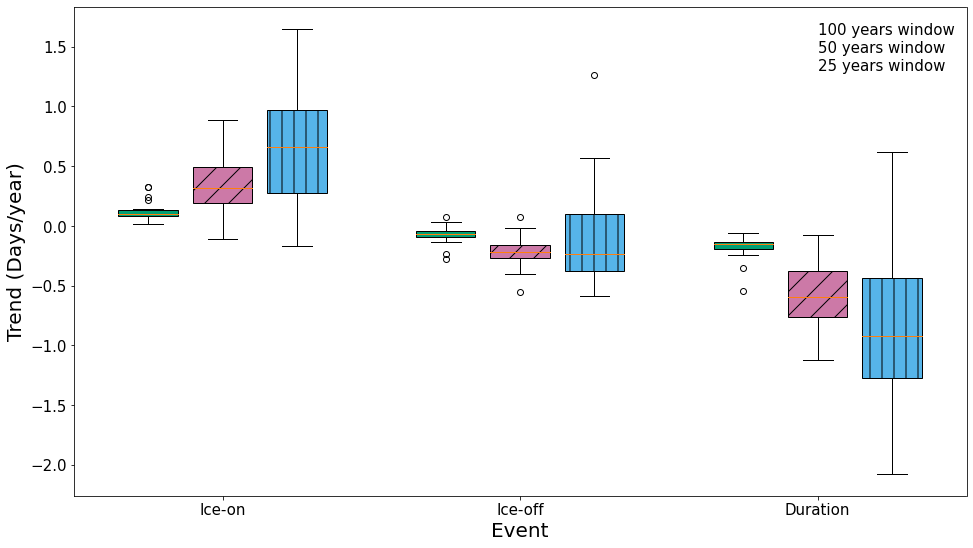

In [55]:
wid = 0.2
positions = [1,2,3]

graph.figure(figsize=(16,9))
b0 = graph.boxplot((ice_on_sapna_cluster['1914-2013_slope'], ice_off_sapna_cluster['1914-2013_slope'], 
                    duration_sapna_cluster['1914-2013_slope']), widths=wid, positions = [pos - 0.25 for pos in positions], 
                   boxprops = ice_on_boxprops, patch_artist=True)
b1 = graph.boxplot((ice_on_sapna_cluster['1964-2013_slope'], ice_off_sapna_cluster['1964-2013_slope'], 
               duration_sapna_cluster['1964-2013_slope']), widths=wid, positions = positions, 
              boxprops = ice_off_boxprops, patch_artist=True)
b2= graph.boxplot((ice_on_sapna_cluster['1989-2013_slope'], ice_off_sapna_cluster['1989-2013_slope'], 
               duration_sapna_cluster['1989-2013_slope']), widths=wid, positions = [pos + 0.25 for pos in positions], 
              boxprops = duration_boxprops, patch_artist=True)

# hatch = '/'
for box in b0['boxes']:
    box.set(facecolor = '#009E73', linewidth=1)
#     box.set(fill=False, linewidth=1, hatch='/')
for box in b1['boxes']:
    box.set(facecolor = '#CC79A7', linewidth=1, hatch='/') 
#     box.set(fill=False, linewidth=1, hatch='|')
for box in b2['boxes']:
    box.set(facecolor = '#56B4E9', linewidth=1, hatch='|')
#     box.set(fill=False, linewidth=1, hatch='//')
graph.xticks(positions, ['Ice-on', 'Ice-off', 'Duration'], fontsize=15)
graph.xlim(0.5, 3.5)
graph.xlabel('Event', fontsize=20)
graph.yticks(fontsize=15)
graph.ylabel("Trend (Days/year)", fontsize=20)
graph.text(3, 1.6, '100 years window', fontsize=15)
graph.text(3, 1.45, '50 years window', fontsize=15)
graph.text(3, 1.3, '25 years window', fontsize=15)
graph.savefig('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/Linear_regress_clusters.png', bbox_inches='tight')
graph.show()

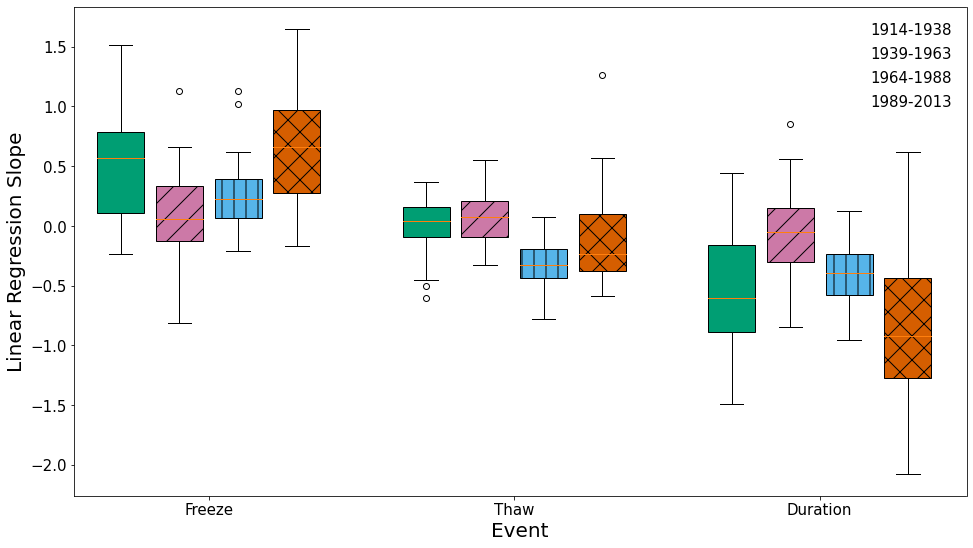

In [39]:
wid = 0.2
positions = [1, 2.3, 3.6]

graph.figure(figsize=(16,9))
b0 = graph.boxplot((ice_on_sapna_cluster['1914-1938_slope'], ice_off_sapna_cluster['1914-1938_slope'], 
                    duration_sapna_cluster['1914-1938_slope']), widths=wid, positions = [pos - 0.25 for pos in positions], 
                   patch_artist=True)
b1 = graph.boxplot((ice_on_sapna_cluster['1939-1963_slope'], ice_off_sapna_cluster['1939-1963_slope'], 
                    duration_sapna_cluster['1939-1963_slope']), widths=wid, positions = positions, 
                   patch_artist=True)
b2 = graph.boxplot((ice_on_sapna_cluster['1964-1988_slope'], ice_off_sapna_cluster['1964-1988_slope'], 
                    duration_sapna_cluster['1964-1988_slope']), widths=wid, positions = [pos + 0.25 for pos in positions], 
                   patch_artist=True)
b3 = graph.boxplot((ice_on_sapna_cluster['1989-2013_slope'], ice_off_sapna_cluster['1989-2013_slope'], 
                    duration_sapna_cluster['1989-2013_slope']), widths=wid, positions = [pos + 0.5 for pos in positions], 
                   patch_artist=True)

# hatch = '/'
for box in b0['boxes']:
    box.set(facecolor = '#009E73', linewidth=1)
for box in b1['boxes']:
    box.set(facecolor = '#CC79A7', linewidth=1, hatch='/') 
for box in b2['boxes']:
    box.set(facecolor = '#56B4E9', linewidth=1, hatch='|')  
for box in b3['boxes']:
    box.set(facecolor = '#D55E00', linewidth=1, hatch='x')    
graph.xticks([pos + 0.125 for pos in positions], ['Freeze', 'Thaw', 'Duration'], fontsize=15)
graph.xlim(0.55, 4.35)
graph.xlabel('Event', fontsize=20)
graph.yticks(fontsize=15)
graph.ylabel('Linear Regression Slope', fontsize=20)
graph.text(3.94, 1.6, '1914-1938', fontsize=15)
graph.text(3.94, 1.4, '1939-1963', fontsize=15)
graph.text(3.94, 1.2, '1964-1988', fontsize=15)
graph.text(3.94, 1, '1989-2013', fontsize=15)

graph.savefig('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/Linear_regress_4_windows_clusters.png', bbox_inches='tight')
graph.show()

In [56]:
# Importing Image and ImageOps module from PIL package
from PIL import Image, ImageOps

# creating an og_image object
og_image = Image.open('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/Linear_regress_clusters_combined.png')

# # applying grayscale method
gray_image = ImageOps.grayscale(og_image)
gray_image.save('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/Linear_regress_clusters_combined_grayscale.png')

In [95]:
full_boxprops = dict(linewidth=2, color='red', ls='-')
half_boxprops = dict(linewidth=3, color='blue', linestyle=':')
quarter_boxprops = dict(linewidth=2, color='green', ls='--')

full_boxprops = dict(linewidth=4, color='maroon')
half_boxprops = dict(linewidth=4, color='royalblue')
quarter_boxprops = dict(linewidth=3, color='forestgreen')

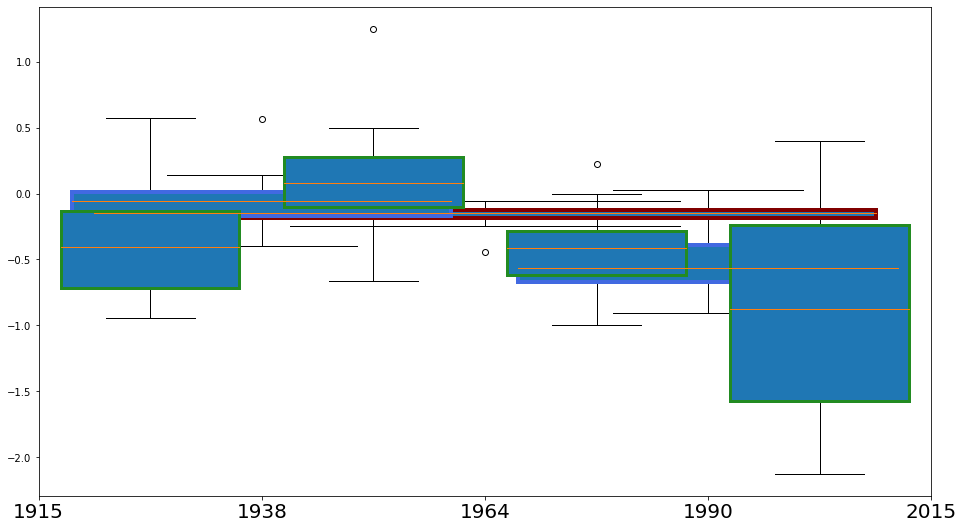

In [96]:
graph.figure(figsize=(16,9))
graph.boxplot(duration_sapna_cluster['1912-2015_slope'], widths=3.5, positions=[2.5], boxprops=full_boxprops, patch_artist=True)
graph.boxplot((duration_sapna_cluster['1912-1963_slope'], duration_sapna_cluster['1964-2015_slope']), 
              boxprops=half_boxprops, positions=[1.5, 3.5], widths=1.7, patch_artist=True)
graph.boxplot((duration_sapna_cluster['1912-1937_slope'], duration_sapna_cluster['1938-1963_slope'], 
               duration_sapna_cluster['1964-1989_slope'], duration_sapna_cluster['1990-2015_slope']), 
              boxprops=quarter_boxprops, widths=0.8, patch_artist=True)
graph.xticks((0.5, 1.5, 2.5, 3.5, 4.5), [1915, 1938, 1964, 1990, 2015], fontsize=20)
# [1915, 1938, 1964, 1990, 2015]
graph.show()

# Bill Perry variability piecewise

In [101]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Additional_data/ice_variability_all.csv')
print(len(df))
df.dropna(subset=['ice_on_doy', 'ice_off_doy', 'duration'], thresh=1, inplace=True)
print(len(df))
display(df.head())

for lake in df['lake_name'].unique():
    df_lake = df[df['lake_name'] == lake]
#     df_lake.to_csv(f'/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_Bill_Perry_lake_files/{lake}_variability.csv', 
#                    index=False)

9886
8920


,lake_name,ice_on_doy,ice_off_doy,duration,freeze_years,year
7,Aegerisee,24.362930,NaN,NaN,1913-2018,1920
8,Aegerisee,24.291288,NaN,NaN,1913-2018,1921
9,Aegerisee,24.291288,NaN,NaN,1913-2018,1922
10,Aegerisee,24.291288,NaN,NaN,1913-2018,1923
11,Aegerisee,24.345333,NaN,NaN,1913-2018,1924


# Dale Robertson

In [5]:
start_decades = np.arange(1811, 2012, 10)
end_decades = start_decades + 9

path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/May_25/'

count_lake_df = []

for file in os.listdir(path):
    lake_df = pd.read_csv(f'{path}{file}')
    lake_name = file.split('.csv')[0]
    print(lake_name) 
    start_year, last_year = lake_df['start_year'].iloc[0], lake_df['start_year'].iloc[-1]
    total_range = str(start_year) + '-' + str(last_year)
    
    count_df = []
    
    for start_year, end_year in zip(start_decades, end_decades):
        year_range = str(start_year) + '-' + str(end_year)
        temp_df = lake_df[lake_df['start_year'].between(start_year, end_year, inclusive=True)]
        number_no_freeze = np.float(len(temp_df[temp_df['froze'] == 'N']))

        temp_count_df = pd.DataFrame(columns=['lake', 'total_year_range', f"{year_range}"])
        temp_count_df = temp_count_df.append({'lake': lake_name, 'total_year_range': total_range, 
                                              f"{year_range}": number_no_freeze}, ignore_index=True)
        count_df.append(temp_count_df)
    
    count_df = pd.concat(count_df)
    count_lake_df.append(count_df)

Auburn
Baikal


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Balaton
Brant
Cazenovia
Champlain
Christmas
Clear
Cobbosseecontee
Damariscotta
Detroit
Geneva
Gouta
Grand Traverse Bay
Haukivesi
Houghtons
Kallavesi
Kallsjon
KempenfeltBay
Kezar
LakeOfBays
Lej de San Murezzan
Lentua
Mendota
Minnetonka
MIRROR
Monona
Moosehead
Mooselookmeguntic
Nackten
Nasijarvi
Nipissing
Oneida
Orsasjon
Osakis
Otsego
Oulujarvi
Paijanne
Palovesi
Pennesseewassee
Pielavesi
Pielinen
Rangeley
Richardson
Runn
Schroon
Sebago
Sebec
Serwy
Shell
Shields
Sunapee
SuperiorBayfield
Suwa
Thompson
Umbagog
Vesijarvi
Visuvesi
West Grand
Wilson
Winnipesaukee


In [6]:
counts_df = pd.concat(count_lake_df)

In [39]:
# df_master.to_csv('/mnt/c/Users/imrit/Desktop/Gen_fish_Sharma/RSI_survey/Survey_count/RSI_survey_2020_st_lawrence_survey_count.csv', 
#                  index=False)

## Merge detrended variance explained and best models

In [36]:
linear_model_var_explained = pd.read_csv('/mnt/c/Users/imrit/Desktop/Variance_explained_detrended_model.csv')
display(linear_model_var_explained.head())

detrended_models = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_lake_ice_detrended_multi_linear_regression_variance_partitioning.csv')
display(detrended_models.head())

FileNotFoundError: [Errno 2] File b'/mnt/c/Users/imrit/Desktop/Variance_explained_detrended_model.csv' does not exist: b'/mnt/c/Users/imrit/Desktop/Variance_explained_detrended_model.csv'

In [65]:
merged_detrended_var_explained = pd.merge(detrended_models, linear_model_var_explained)
merged_detrended_var_explained['linear_variance_unexplained'] = 100 - merged_detrended_var_explained['linear_model_proportion_variance_explained']
merged_detrended_var_explained['multi_residual'] = merged_detrended_var_explained['Variance_partitioning'].str.split('Residual=').str.get(1)
merged_detrended_var_explained.head()

# merged_detrended_var_explained.to_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_lake_ice_detrended_multi_linear_regress_var_parition_full.csv', 
#                                       index=False)

,lake,response_variable,model,year_r2,adj_r2,total_r2,AIC,Variance_partitioning,linear_model_proportion_variance_explained,linear_variance_unexplained,multi_residual
0,Auburn,Ice_off,y = -27.6 + 2*SOI + 3.4*AO -1.1*NAO DJFM - 2....,0.043023,0.467911,0.510934,467.690809,SOI=5.28; AO=2.21; NAO_DJFM=4.01; tmp_DJF=18.9...,17.752593,82.247407,47.51
1,Bayfield,Duration,y = -105 + 2.2*AO + 1.7*NAO DJFM - 8.7*tmp_DJF...,0.294918,0.670953,0.965871,571.094330,AO=1.94; NAO_DJFM=1.82; tmp_DJF=60.95; tmp_MAM...,36.898853,63.101147,25.84
2,Bayfield,Ice_off,y = -24 + 0.1*QBO + 0.8*NAO DJFM - 3.6*tmp_DJF...,0.204151,0.669981,0.874132,484.543958,QBO=1.1; NAO_DJFM=0.11; tmp_DJF=52.72; tmp_MAM...,33.481534,66.518466,29.17
3,Bayfield,Ice_on,y = -28 - 3*AO mean A-DEC + 5.3*tmp_DJF + 4.2*...,0.269304,0.567000,0.836304,552.903020,AO=2.37; tmp_DJF=44.03; tmp_lagSON=9.26; co2=3...,26.496834,73.503166,40.74
4,Cazenovia,Duration,y = -54 + 4.4*SOI mean A-DEC - 5.2*AO mean A-D...,0.058591,0.473708,0.532299,559.577977,SOI=2.25; AO=5.02; NAO_DJFM=4.13; tmp_DJF=32.1...,12.189467,87.810533,47.25


# Graph for multi linear regression variance explained

In [66]:
df = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_lake_ice_detrended_multi_linear_regress_var_partition_full_aug_08.csv')
df.head()

,lake,response_variable,model,year_r2,adj_r2,total_r2,AIC,Variance_partitioning,year_proportion_variance,climate_proportion_variance,weather_proportion_variance,co2_proportion_variance,residual_multi_proportion_variance
0,Auburn,Ice_off,y = -27.6 + 2*SOI + 3.4*AO -1.1*NAO DJFM - 2....,0.043023,0.467911,0.510934,467.690809,SOI=5.28; AO=2.21; NAO_DJFM=4.01; tmp_DJF=18.9...,17.752593,9.458452,31.755724,1.891690,39.075743
1,Bayfield,Duration,y = -105 + 2.2*AO + 1.7*NAO DJFM - 8.7*tmp_DJF...,0.294918,0.670953,0.965871,571.094330,AO=1.94; NAO_DJFM=1.82; tmp_DJF=60.95; tmp_MAM...,36.898853,2.372603,43.363108,1.060099,16.305336
2,Bayfield,Ice_off,y = -24 + 0.1*QBO + 0.8*NAO DJFM - 3.6*tmp_DJF...,0.204151,0.669981,0.874132,484.543958,QBO=1.1; NAO_DJFM=0.11; tmp_DJF=52.72; tmp_MAM...,33.481534,0.804873,46.270245,0.046563,19.403437
3,Bayfield,Ice_on,y = -28 - 3*AO mean A-DEC + 5.3*tmp_DJF + 4.2*...,0.269304,0.567000,0.836304,552.903020,AO=2.37; tmp_DJF=44.03; tmp_lagSON=9.26; co2=3...,26.496834,1.742025,39.169837,2.646114,29.945190
4,Cazenovia,Duration,y = -54 + 4.4*SOI mean A-DEC - 5.2*AO mean A-D...,0.058591,0.473708,0.532299,559.577977,SOI=2.25; AO=5.02; NAO_DJFM=4.13; tmp_DJF=32.1...,12.189467,10.010401,35.528141,0.781514,41.490477


In [37]:
df = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Variance_partitioning_results/Variance_partitioning_aug_12.csv')
df.rename(columns={'lake': 'Lake', 
                   'year_proportion_variance': 'Linear Trend', 
                   'climate_proportion_variance': 'Climate oscillations', 
                   'weather_proportion_variance': 'Local Air temperature', 
                   'co2_proportion_variance': 'Residual Carbon Dioxide', 
                   'residual_multi_proportion_variance': 'Residuals'}, inplace=True)
df.set_index('Lake', inplace=True)
df.replace({'Ice_on': 'Ice-on', 'Ice_off': 'Ice-off'}, inplace=True)
df.dropna(subset=['Residuals'], inplace=True)
# df['sum_variance_explained'] = df['Year'] + df['Climate'] + df['Weather'] + df['Carbon Dioxide'] + df['Residuals']
df.head()

,response_variable,Variance_partitioning,Linear Trend,Climate oscillations,Local Air temperature,Residual Carbon Dioxide,Residuals
Lake,,,,,,,
Auburn,Ice-on,0,0.000000,0.000000,0.000000,0.000000,0.000000
Auburn,Duration,0,0.000000,0.000000,0.000000,0.000000,0.000000
Auburn,Ice-off,SOI=5.28; AO=2.21; NAO_DJFM=4.01; tmp_DJF=18.9...,17.752593,9.458452,31.755724,1.891690,39.075743
Superior (Bayfield),Duration,AO=1.94; NAO_DJFM=1.82; tmp_DJF=60.95; tmp_MAM...,36.898853,2.372603,43.363108,1.060099,16.305336
Superior (Bayfield),Ice-off,QBO=1.1; NAO_DJFM=0.11; tmp_DJF=52.72; tmp_MAM...,33.481534,0.804873,46.270245,0.046563,19.403437


In [48]:
# ax = df.groupby('response_variable').plot.barh(stacked=True, figsize=(9,16))

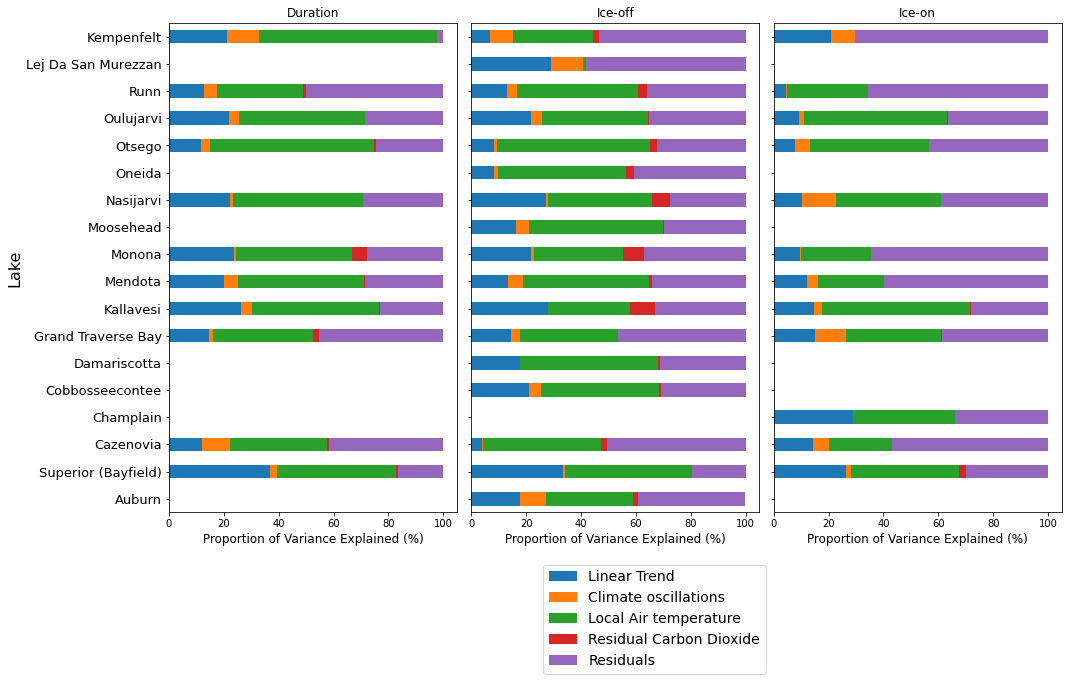

In [39]:
fig, axes = graph.subplots(1,3, figsize=(16, 9), sharey=True, )
for (response, group), ax in zip(df.groupby(df.response_variable), axes.flatten()):
    group.plot.barh(stacked=True, ax=ax, title=response, legend=False)
    ax.set_xlabel('Proportion of Variance Explained (%)', fontsize=12)
    ax.set_ylabel('Lake', fontsize=16)
    ax.tick_params(axis='y', which='major', labelsize=13)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc=(-0.8, -0.33), fontsize=14)
graph.ylabel('Lake', fontsize=20)
fig.subplots_adjust(wspace=0.05)
fig.show()
fig.savefig('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/proportion_variance_explained_mar_17_2021.png', 
            bbox_inches='tight')

In [12]:
df_2 = df[df['Variance_partitioning'] != 0].groupby('response_variable').mean()
display(df_2)

,Linear Trend,Climate oscillations,Air temperature,Carbon Dioxide,Residuals
response_variable,,,,,
Duration,12.658261,2.266256,27.148565,0.755820,19.671501
Ice-off,16.645514,2.524861,39.398452,2.499854,32.679362
Ice-on,9.572520,2.889428,25.032795,0.219934,31.036299


# Looking at oscillations residuals

R square: 0.0


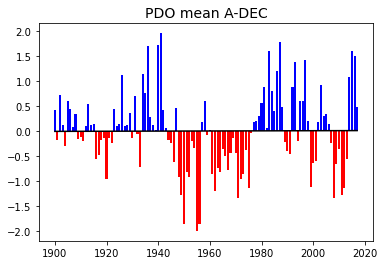

R square: 0.0


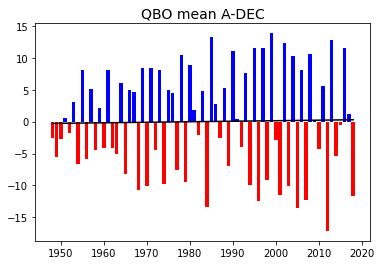

R square: 0.006


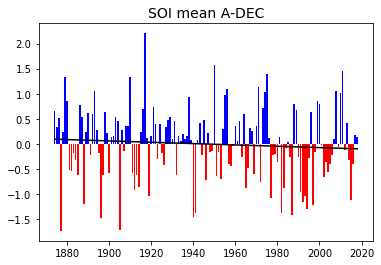

R square: 0.029


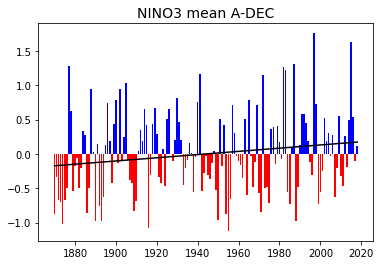

R square: 0.053


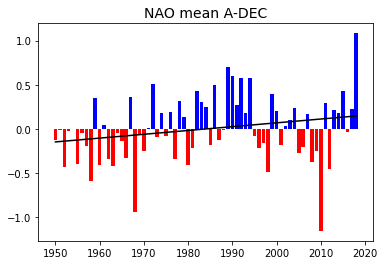

R square: 0.111


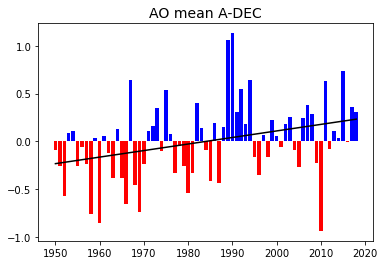

R square: 0.0


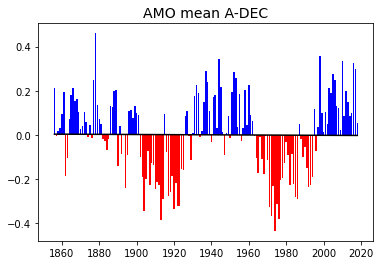

R square: 0.0


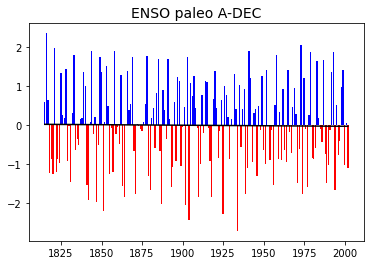

R square: 0.005


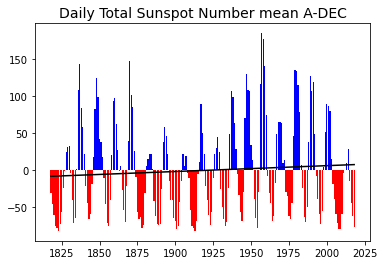

R square: 0.805


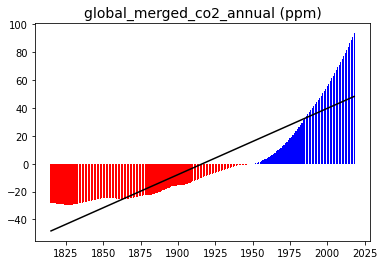

In [110]:
champlain = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/Champlain.csv')

columns = ['PDO mean A-DEC', 'QBO mean A-DEC', 'SOI mean A-DEC', 'NINO3 mean A-DEC', 'NAO mean A-DEC', 'AO mean A-DEC', 
           'AMO mean A-DEC', 'ENSO paleo A-DEC', 'Daily Total Sunspot Number mean A-DEC', 'global_merged_co2_annual (ppm)']

for col in columns:
    df_2 = champlain[['start_year', col]].dropna()
    col_mean = df_2[col].mean()
    df_2['residuals'] = df_2[col] - col_mean
    
    x = df_2['start_year'].values.reshape(-1,1)
    model = LinearRegression().fit(x, df_2['residuals'].values.reshape(-1,1))
    pred_y = model.predict(x)
    score = model.score(x, df_2['residuals'].values.reshape(-1,1))
    
    pos_signal, neg_signal = df_2['residuals'].values.copy(), df_2['residuals'].values.copy()
    pos_signal[pos_signal <=0], neg_signal[neg_signal > 0] = np.nan, np.nan
    
    print(f'R square: {round(score, 3)}')
    graph.title(col, fontsize=14)
    graph.bar(df_2['start_year'], pos_signal, color='blue')
    graph.bar(df_2['start_year'], neg_signal, color='red')
    graph.plot(x, pred_y, color='black')
    graph.show()

In [111]:
oscillations_df = champlain[['start_year', 'PDO mean A-DEC', 'QBO mean A-DEC', 'SOI mean A-DEC', 'NINO3 mean A-DEC', 
                             'NAO mean A-DEC', 'AO mean A-DEC', 'AMO mean A-DEC', 'ENSO paleo A-DEC', 
                             'Daily Total Sunspot Number mean A-DEC', 'global_merged_co2_annual (ppm)']]
oscillations_df.head()

,start_year,PDO mean A-DEC,QBO mean A-DEC,SOI mean A-DEC,NINO3 mean A-DEC,NAO mean A-DEC,AO mean A-DEC,AMO mean A-DEC,ENSO paleo A-DEC,Daily Total Sunspot Number mean A-DEC,global_merged_co2_annual (ppm)
0,1815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600,NaN,283.566
1,1816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.362,NaN,283.460
2,1817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.644,NaN,283.325
3,1818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.222,52.938967,283.170
4,1819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.863,38.534137,283.002


R square: 0.016


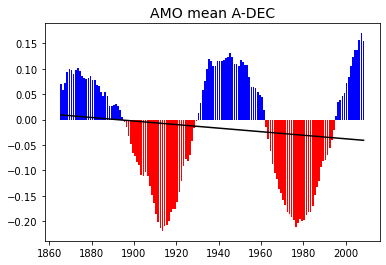

In [123]:
for col in ['AMO mean A-DEC']:
    window = 20
    df_2 = oscillations_df[['start_year', col]].dropna()
    df_2['res'] = df_2[col] - df_2[col].mean()
    roll_df = df_2.rolling(window=window).mean().dropna()
    
    x = roll_df['start_year'].values.reshape(-1,1)
    model = LinearRegression().fit(x, roll_df['res'].values.reshape(-1,1))
    pred_y = model.predict(x)
    score = model.score(x, roll_df['res'].values.reshape(-1,1))
    
    pos_signal, neg_signal = roll_df['res'].values.copy(), roll_df['res'].values.copy()
    pos_signal[pos_signal <=0], neg_signal[neg_signal > 0] = np.nan, np.nan
    
    print(f'R square: {round(score, 3)}')
    graph.title(col, fontsize=14)
    graph.bar(roll_df['start_year'], pos_signal, color='blue')
    graph.bar(roll_df['start_year'], neg_signal, color='red')
    graph.plot(x, pred_y, color='black')
    graph.show()

# Getting data ready for hypothesis paper submission

In [157]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/'

lakes_df = []
for file in os.listdir(path):
    lake_name = file.split('.csv')[0]
    df = pd.read_csv(f'{path}{file}')
    df['lake'] = lake_name
    df.rename(columns={'ice_on': 'ice_on_date', 'ice_off': 'ice_off_date', 
                       'Latitude': 'latitude', 'Longitude': 'longitude'}, inplace=True)
    lakes_df.append(df)

lakes_df = pd.concat(lakes_df)
print(len(lakes_df))
display(lakes_df.head())

3152


,lakecode,lake,start_year,ice_on_date,ice_off_date,Latitude,Longitude,Country,froze,source,...,SH,Global,Daily Total Sunspot Number mean A-DEC,Daily Total Sunspot Number mean A-MAR,Daily Total Sunspot Number mean A-APR,Daily Total Sunspot Number mean JFM,Daily Total Sunspot Number mean lagSON,Daily Total Sunspot Number mean DJF,Daily Total Sunspot Number mean MAM,global_merged_co2_annual (ppm)
0,GAH1,Auburn,1835,NaN,1836-05-08,44.14,-70.25,NaN,Y,NaN,...,13.8,40.16,85.843931,NaN,NaN,26.745455,35.571429,33.557692,67.000000,283.474
1,GAH1,Auburn,1836,NaN,1837-04-30,44.14,-70.25,NaN,Y,NaN,...,0.0,0.00,192.698795,NaN,NaN,162.441860,163.952381,155.256410,196.921569,283.708
2,GAH1,Auburn,1837,NaN,1838-04-27,44.14,-70.25,NaN,Y,NaN,...,0.0,0.00,227.333333,NaN,NaN,275.142857,195.205882,307.888889,210.432432,283.946
3,GAH1,Auburn,1838,NaN,1839-04-18,44.14,-70.25,NaN,Y,NaN,...,0.0,0.00,168.676617,NaN,NaN,195.463415,181.977273,187.270270,224.541667,284.188
4,GAH1,Auburn,1839,NaN,1840-04-28,44.14,-70.25,NaN,Y,NaN,...,0.0,0.00,142.979381,NaN,NaN,157.857143,132.963636,159.731707,104.980392,284.433


In [159]:
final_lakes_df = lakes_df[['lakecode', 'lake', 'latitude', 'longitude', 'start_year', 'froze', 'ice_on_date', 'ice_off_date', 
                           'duration', 'ice_on_doy', 'ice_off_doy']]
display(final_lakes_df.head())
final_lakes_df.to_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/lakes_data_merged.csv', index=False)

,lakecode,lake,Latitude,Longitude,start_year,froze,ice_on_date,ice_off_date,duration,ice_on_doy,ice_off_doy
0,GAH1,Auburn,44.14,-70.25,1835,Y,NaN,1836-05-08,NaN,NaN,129.0
1,GAH1,Auburn,44.14,-70.25,1836,Y,NaN,1837-04-30,NaN,NaN,120.0
2,GAH1,Auburn,44.14,-70.25,1837,Y,NaN,1838-04-27,NaN,NaN,117.0
3,GAH1,Auburn,44.14,-70.25,1838,Y,NaN,1839-04-18,NaN,NaN,108.0
4,GAH1,Auburn,44.14,-70.25,1839,Y,NaN,1840-04-28,NaN,NaN,119.0


# Breakpoint graphs

ice_off_doy


/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/arshad/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

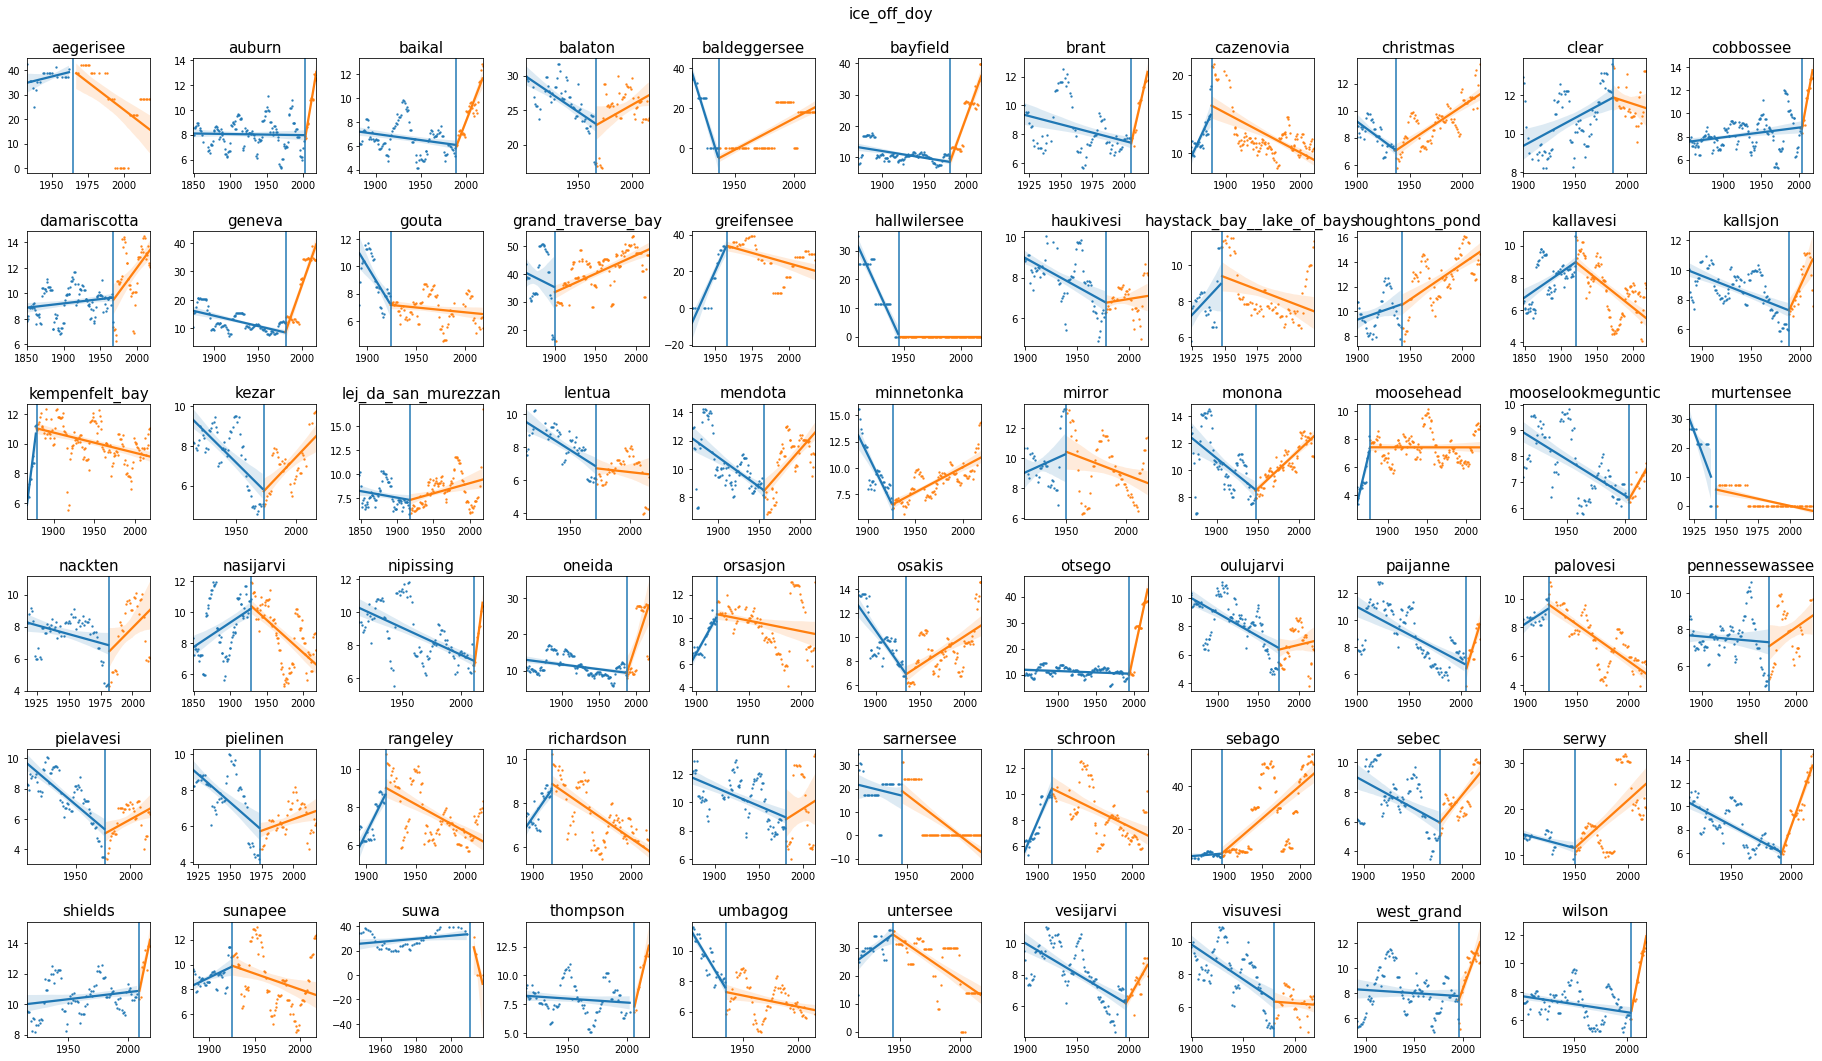

In [16]:
path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_project/Analysis/'

variable_df = []
for variable in ['ice_off_doy', 'ice_on_doy', 'total_duration']:
    print(variable)
    
    if variable == 'ice_off_doy':
        fig = graph.figure(figsize=(32, 18))
    else:
        fig = graph.figure(figsize=(21, 21))
    
    for file, i in zip(os.listdir(f'{path}Segmented/Data/{variable}'), 
                       range(1, len(os.listdir(f'{path}Segmented/Data/{variable}')))):
        lake_name = file.split(f'_{variable}')[0]
        lake_df = pd.read_csv(f'{path}Segmented/Data/{variable}/{file}')
        pre_break_year = lake_df.loc[lake_df['start_year'] < lake_df['sizer_break_year'].mean()]
        post_break_year = lake_df.loc[lake_df['start_year'] >= lake_df['sizer_break_year'].mean()]
        
        #plot graphs
        if variable == 'ice_off_doy':
            ax = fig.add_subplot(6, 11, i)
        else:
            ax = fig.add_subplot(10, 7, i)
        ax.set_title(lake_name, fontsize=15)
        sns.regplot(pre_break_year['start_year'], pre_break_year['lake'], ax=ax, scatter_kws={'s': 2})
        sns.regplot(post_break_year['start_year'], post_break_year['lake'], ax=ax, scatter_kws={'s': 2}, 
                    truncate=True)
        graph.axvline(lake_df['sizer_break_year'].mean())
        ax.set_ylabel('')
        ax.set_xlabel('')

    fig.subplots_adjust(wspace=0.35, hspace=0.5, top=0.88)
    fig.suptitle(variable, fontsize=15, y=0.92)
#     fig.savefig(f'{path}Graphs/{variable}_std_segmented_linear_regress_dec_04_2020.png', bbox_inches= 'tight')
    graph.show()
    break

In [6]:
champlain = pd.read_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/Champlain.csv')
display(champlain.head())

pre_break = champlain.loc[champlain['start_year'] < 1876]
post_break = champlain.loc[champlain['start_year'] >= 1876]

,lakecode,lake,start_year,ice_on,ice_off,Latitude,Longitude,Country,froze,source,...,SH,Global,Daily Total Sunspot Number mean A-DEC,Daily Total Sunspot Number mean A-MAR,Daily Total Sunspot Number mean A-APR,Daily Total Sunspot Number mean JFM,Daily Total Sunspot Number mean lagSON,Daily Total Sunspot Number mean DJF,Daily Total Sunspot Number mean MAM,global_merged_co2_annual (ppm)
0,USGS1,LAKE CHAMPLAIN,1815,1816-02-09,NaN,44.5,-73.33,NaN,Y,NaN,...,51.03,109.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.566
1,USGS1,LAKE CHAMPLAIN,1816,1817-01-29,NaN,44.5,-73.33,NaN,Y,NaN,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.460
2,USGS1,LAKE CHAMPLAIN,1817,1818-02-02,NaN,44.5,-73.33,NaN,Y,NaN,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.325
3,USGS1,LAKE CHAMPLAIN,1818,1819-03-04,NaN,44.5,-73.33,NaN,Y,NaN,...,0.00,0.00,52.938967,NaN,NaN,43.944444,NaN,44.954545,66.883333,283.170
4,USGS1,LAKE CHAMPLAIN,1819,1820-02-03,NaN,44.5,-73.33,NaN,Y,NaN,...,0.00,0.00,38.534137,NaN,NaN,25.466667,41.576923,44.600000,25.077922,283.002


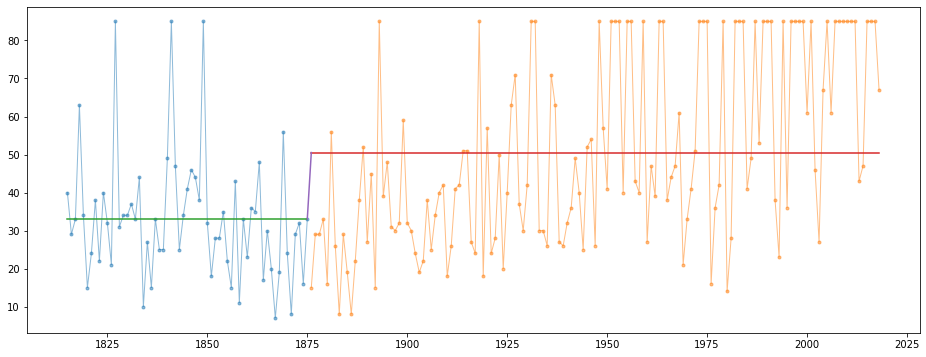

In [28]:
graph.figure(figsize=(16,6))

graph.plot(pre_break['start_year'], pre_break['ice_on_doy'], linewidth=1, alpha=0.5, markersize=3, marker='o')
graph.plot(post_break['start_year'], post_break['ice_on_doy'], linewidth=1, alpha=0.5, markersize=3, marker='o')

graph.plot([pre_break['start_year'].min(), pre_break['start_year'].max()], 
           [pre_break['ice_on_doy'].mean(), pre_break['ice_on_doy'].mean()])
graph.plot([post_break['start_year'].min(), post_break['start_year'].max()], 
           [post_break['ice_on_doy'].mean(), post_break['ice_on_doy'].mean()])

graph.plot([pre_break['start_year'].max(), post_break['start_year'].min()], 
           [pre_break['ice_on_doy'].mean(), post_break['ice_on_doy'].mean()])
graph.show()

In [98]:
path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_project/'
# path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/'

for file in os.listdir(f'{path}Data'):
    variable = file.split('lakes_')[1].split('_oct')[0]
    print(variable)
    df = pd.read_csv(f'{path}Data/{file}')
    df = df.T
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    df['start_year'] = df.index
    df = df[['start_year'] + [col for col in df.columns if col != 'start_year']]
    lake_names = df.columns[1:]
    
    var_df = []    
#     ! mkdir /mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Linear_sens/{variable}
    
    for lake in lake_names:
        lake_df = df[['start_year', lake]]
        lake_df.dropna(inplace=True)
        lake_df['start_year'] = lake_df['start_year'].astype(float)
        lake_df[lake] = lake_df[lake].astype(float)
        
        lr_model = sm.OLS(lake_df[lake], sm.add_constant(lake_df['start_year'])).fit()
        
        r_var = robjects.IntVector(lake_df[lake])
        sens = trend.sens_slope(r_var)
        slope_sens = np.array(sens[0]).item()
        p_sens = np.array(sens[2]).item()
        
        df_lake_model = pd.DataFrame(columns=['lake', 'sens_slope', 'sens_p', 'linear_slope', 'linear_p'])
        df_lake_model = df_lake_model.append({'lake': lake, 
                                              'sens_slope': slope_sens, 
                                              'sens_p': p_sens, 
                                              'linear_slope': lr_model.params.values[1], 
                                              'linear_p': lr_model.pvalues.values.item(0)}, 
                                             ignore_index=True)
        
        var_df.append(df_lake_model)
        
    var_df = pd.concat(var_df)
    display(var_df.head())
    var_df.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Analysis/Linear_sens/{variable}_linear_sens.csv', index=False)

total_duration


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

,lake,sens_slope,sens_p,linear_slope,linear_p
0,aegerisee,0.000000,4.415548e-02,-0.254634,5.712739e-03
0,baikal,-0.159091,4.767887e-08,-0.153475,3.466509e-13
0,balaton,-0.020408,6.889281e-01,-0.020162,5.570221e-01
0,baldeggersee,0.000000,7.713502e-02,-0.082082,3.915336e-03
0,bayfield,-0.344828,2.109488e-17,-0.380201,6.694632e-21


ice_on_doy


,lake,sens_slope,sens_p,linear_slope,linear_p
0,aegerisee,0.000000,1.312555e-03,0.285377,1.927112e-03
0,baikal,0.111111,3.195718e-08,0.114409,2.605139e-08
0,balaton,0.069366,2.077189e-01,0.063141,4.141237e-01
0,baldeggersee,0.000000,4.569257e-05,0.250068,2.372334e-04
0,bayfield,0.166667,5.558742e-11,0.212799,1.813334e-11


ice_off_doy


,lake,sens_slope,sens_p,linear_slope,linear_p
0,aegerisee,0.000000,5.548752e-02,-0.244158,2.718965e-02
0,auburn,-0.082278,2.985282e-09,-0.083955,2.205792e-22
0,baikal,-0.044248,6.362221e-03,-0.039066,1.720203e-10
0,balaton,-0.015749,6.997828e-01,0.004114,7.513239e-01
0,baldeggersee,0.000000,1.921856e-01,-0.070623,1.449936e-01


In [21]:
path = '/mnt/c/Users/imrit/Downloads/Sapna_work/Data_google_drive/Variability_project/'
# path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/'

for file in os.listdir(f'{path}Data'):
    variable = file.split('lakes_')[1].split('_oct')[0]
    print(variable)
    df = pd.read_csv(f'{path}Data/{file}')
    df = df.T
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    df['start_year'] = df.index
    df = df[['start_year'] + [col for col in df.columns if col != 'start_year']]
    lake_names = df.columns[1:]
    
    new_sizer = []
    
    ! mkdir /mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/{variable}
    
    for lake in lake_names:
        lake_df = df[['start_year', lake]]
        lake_df.dropna(inplace=True)
        lake_df['start_year'] = lake_df['start_year'].astype(float)
        lake_df[lake] = lake_df[lake].astype(float)
        
        # sizer data
        linear_piecewise = sizer.piecewise_linear(lake_df['start_year'], lake_df[lake])
        break_year = linear_piecewise[0].item()
        new_sizer.append([lake, break_year])
        
        # make csv files for R
        
        lake_df.rename(columns={lake: 'lake'}, inplace=True)
        lake_df['lake_name'] = lake
        lake_df['sizer_break_year'] = round(break_year)
        lake_df.to_csv(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/{variable}/{lake}_{variable}.csv', index=False)
    
    sizer_df = pd.DataFrame(new_sizer)
    sizer_df.rename(columns={0: 'lake', 1: 'break_year', 2: 'sizer_aic'}, inplace=True)

total_duration


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

ice_on_doy
ice_off_doy


ice_off_doy


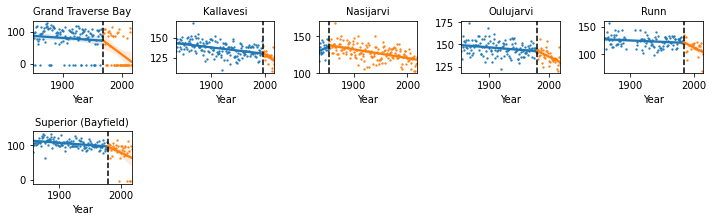

In [8]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/'

variable_df = []
for variable in ['ice_off_doy', 'ice_on_doy', 'total_duration']:
    print(variable)
    
    fig = graph.figure(figsize=(12, 3))
    
    for file, i in zip(os.listdir(f'{path}{variable}'), 
                       range(1, len(os.listdir(f'{path}{variable}')) + 1)):
        
        lake_name = file.split(f'_{variable}')[0].replace('_', ' ').title()
        lake_df = pd.read_csv(f'{path}{variable}/{file}')
        pre_break_year = lake_df.loc[lake_df['start_year'] < lake_df['sizer_break_year'].mean()]
        post_break_year = lake_df.loc[lake_df['start_year'] >= lake_df['sizer_break_year'].mean()]
        
        #plot graphs
        if variable == 'ice_off_doy':
            ax = fig.add_subplot(2, 5, i)
        elif variable == 'ice_on_doy':
            ax = fig.add_subplot(2, 5, i)
        else:
            ax = fig.add_subplot(2, 5, i)
            
        ax.set_title(lake_name, fontsize=10)
        sns.regplot(x=pre_break_year['start_year'], y=pre_break_year['lake'], ax=ax, scatter_kws={'s': 2})
        sns.regplot(x=post_break_year['start_year'], y=post_break_year['lake'], ax=ax, scatter_kws={'s': 2}, 
                    truncate=True)
        graph.axvline(lake_df['sizer_break_year'].mean(), linestyle='--', color='black')
        ax.set_ylabel('')
        ax.set_xlabel('Year')

    fig.subplots_adjust(wspace=0.45, hspace=1.1, top=0.88)
#     fig.suptitle(variable, fontsize=15, y=0.92)
#     fig.savefig(f'/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Graphs/{variable}_segmented.png', bbox_inches= 'tight')
    graph.show()
    break

# Lake morphologies and stuff

In [75]:
path = '/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/Lakes_with_climate/'

morphologies_df = []

for file in os.listdir(path):
    lake_name = file.split('.csv')[0]
    df = pd.read_csv(f'{path}{file}')
    start_year, end_year, year_range = df['start_year'].min(), df['start_year'].max(), len(df)
    range_year_str = str(start_year) + '-' + str(end_year)
    
    df.dropna(subset=['ice_on', 'ice_off'], how='all', inplace=True)
    years_missing = year_range - len(df)
    
    lat, long = df['Latitude'].unique()[0], df['Longitude'].unique()[0]
    
    morphologies_df.append([lake_name, lat, long, range_year_str, years_missing])

In [81]:
df_morphologies = pd.DataFrame(morphologies_df, columns = ['lake', 'latitude', 'longitude', 'year_range', 'years_missing'])
df_morphologies.to_csv('/mnt/c/Users/imrit/Desktop/Hypothesis_MS/Data/hypothesis_lakes_morphologies.csv', index=False)